# Adaptive time-stepper for ODEs
In this notebook, we show how to train a neural network to suggest optimal step sizes for Runge-Kutta methods. Consider the Lorenz system, i.e.
    $$ \frac{d}{dt} \begin{bmatrix} x_1 \\
            x_2 \\
            x_3
       \end{bmatrix} = \begin{bmatrix} \sigma (x_2 - x_1) \\
            x_1 (\rho - x_3) - x_2 \\
            x_1 x_2 - \beta x_3
       \end{bmatrix}$$
where $\sigma = 10$, $\beta = \tfrac{8}{3}$, and $\rho = 28$. We aim to integrate this ODE from initial conditions $t_0 = 0$, $x_0 = [10, 10, 10]^T$ until $t_1 = 10$. <br>
Let us first gather some information about the Lorenz system in the following variables:

In [1]:
import numpy as np

x0 = np.array([1, 0])  # start point of integration
t0 = 0
t1 = 200
d = 2  # dimension of the ODE state space

#step_sizes = [0.025, 0.029, 0.033, 0.039, 0.045, 0.052, 0.060, 0.070]  # the NN will choose from these step sizes
step_sizes= np.linspace(0.02, 0.15, 20)
tol = 0.0001  # target integration error tolerance

For the integration itself we will use the 5th order Runge-Kutta method that is part of the Dormand-Prince Runge Kutta method (RKDP) (to which we will later compare). Thus, we define the following variables as a preparation for creating the NN:

In [2]:
from adaptive.integrator import RKDP
integrator = RKDP()

nodes_per_step = 6  # the RKDP method has 6 stages
dim_action = len(step_sizes)  # the dimension of the action space of the NN
memory = 0  # how many integration steps the predictor can look back

Furthermore, it is a good idea to scale the inputs of the NN to order $\approx 10^{-1}$. For this purpose we will use a scikit-learn `StandardScaler`. Note that the input dimension of the NN is given by `nodes_per_step * d + 1`. We will load a `StandardScaler` that has already been fitted to typical states for the Lorenz system. (To fit the scaler yourself, you can obtain the data by integrating the Lorenz system with randomly selected step sizes from `step_sizes`.)

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.mean_ = np.zeros((nodes_per_step * d + 1) * (memory + 1))
scaler.mean_[0] = -0.045
scaler.scale_ = 10 * np.ones((nodes_per_step * d + 1) * (memory + 1))
scaler.scale_[0] = 0.1

Now we can initialize the NN. It is encapsuled by the `Predictor` object, which handles the interaction with the NN. The NN itself is created using tensorflow.

In [4]:
from adaptive.predictor import PredictorQODE
from adaptive.build_models import build_value_modelODE

predictor = PredictorQODE(step_sizes=step_sizes,
                          model=build_value_modelODE(dim_state=nodes_per_step * d + 1,
                                                     dim_action=dim_action,
                                                     memory=memory),
                          scaler=scaler)

2024-08-29 16:57:44.718793: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-29 16:57:44.723526: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-29 16:57:44.782880: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-29 16:57:45.754050: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


During the training process we have to reward or penalize the NN for its time step choices. We choose a reward function of the following form: if the integration error is below the tolerance, reward the NN with a value scaling with the chosen time step, i.e., larger time steps yield larger rewards. If the integration error is larger than the tolerance, penalize the NN with a value scaling with the error, i.e., bigger errors yield more negative rewards. Here we use the `RewardLog10` reward function, which has a logarithmic scaling for both positive and negative rewards.

In [5]:
from adaptive.reward_functions import RewardLog10

step_size_range = (step_sizes[0], step_sizes[-1])  # range of expected step sizes
reward_range = (0.1, 2)  # range of positive rewards

reward_fun = RewardLog10(error_tol=tol, step_size_range=step_size_range, reward_range=reward_range)

# print some example rewards
errors = [0.1 * tol, 0.1 * tol, 0.1 * tol]
hs = [step_sizes[0], step_sizes[2], step_sizes[-1]]
print(f"positive rewards (error is smaller than tol={tol}):")
print("error, step size, reward")
for er, h in zip(errors, hs):
    print(er, h, round(reward_fun(er, h), 3))
print()
errors = [2 * tol, 10 * tol, 100 * tol]
hs = [step_sizes[0], step_sizes[0], step_sizes[0]]
print(f"negative rewards (error is larger than tol={tol}):")
print("error, step size, reward")
for er, h in zip(errors, hs):
    print(er, h, round(reward_fun(er, h), 3))

positive rewards (error is smaller than tol=0.0001):
error, step size, reward
1e-05 0.02 0.1
1e-05 0.03368421052631579 0.592
1e-05 0.15 2.0

negative rewards (error is larger than tol=0.0001):
error, step size, reward
0.0002 0.02 -0.301
0.001 0.02 -1.0
0.01 0.02 -2.0


In order to train the NN, we will need to repeatedly integrate the given ODE. The `ODEEnv` class handles the integration process. The most important method is `ODEEnv.iterate`, which takes a step size as an argument, integrates the ODE with the provided step size for one step, and provides the next state as an output. Moreover, the `ODEEnv` class keeps track of the integration error and calculates the rewards for the step size choices.

In [6]:
from adaptive.environments import ODEEnv
from functions import LorenzSystem, VanDerPol

env = ODEEnv(fun=VanDerPol(), max_iterations=10000, initial_step_size=step_sizes[0],
             step_size_range=step_size_range, reward_fun=reward_fun,
             error_tol=tol, nodes_per_integ=nodes_per_step, memory=memory, x0=x0, t0=t0, max_dist=t1 - t0)

During the integration process we will store a few past states and desired NN outputs in an `Experience` object. If a certain number of experiences is stored or the integration is finished, we use the stored data (batch) to train the NN.

In [7]:
from adaptive.experience import ExperienceODE

experience = ExperienceODE(batch_size=64)

During training it is important that the NN explores sufficiently large parts of the action space in order to find the optimal step sizes for a given input. We will use the following function to randomly choose actions given the NN's output:

In [11]:
def choose_action(actions, eps, dim_action):
    """
    With probability 0.5*eps choose the action one above the favored action and with probability 0.5*eps the action
    below the favored.
    Otherwise choose the favored action.

    Parameters
    ----------
    actions : np.ndarray
    eps : float
    dim_action : int

    Returns
    -------
    int
    """
    favored = np.argmax(actions)
    rn = np.random.sample()

    if rn < 0.5 * eps:
        return min(favored + 1, dim_action - 1)
    if rn < eps:
        return max(favored - 1, 0)

    return favored

Finally, we train the NN. The following training loop illustrates the training process for a few episodes. However, we will load a fully trained NN afterwards, so that you do not have to do the training yourself.

In [14]:
import warnings
warnings.filterwarnings('ignore')

num_episodes = 3
gamma = 0  # discount factor for future rewards

for episode in range(3):
    state = env.reset(integrator=integrator)
    print("state",state)
    done = False
    eps = 0.5
    print('episode: {}'.format(episode))

    while not done:
        # get action from actor
        actions = predictor.get_actions(state)  # Q-value of each step size
        print("actions", actions)
        action = choose_action(actions, eps, dim_action)  # randomize step size
        print("action", action)
        step_size = predictor.action_to_stepsize(action)

        # execute action
        next_state, reward, done, _ = env.iterate(step_size, integrator)

        # find target values (more correct Q-values) for NN output
        action_next_state = predictor.get_actions(next_state)
        target = reward + gamma * np.max(action_next_state)
        target_actions = actions.squeeze()
        target_actions[action] = target
        # append target values to experience (batch)
        experience.append(state=state, target=target_actions)
        
        # train the NN
        if experience.is_full() or done:
            states, targets = experience.get_samples()
            predictor.train_on_batch(states, targets)
            experience.reset()

        state = next_state.copy()
    
    # uncomment if you want to train the NN yourself and save the weights:
    # predictor.model.save_weights('predictorODE')

state [<adaptive.integrator.StateODE object at 0x73604c33e890>]
episode: 0
actions [[-0.25845832  0.38085425  0.79924804  0.70172685  0.4495652   0.4508931
   0.40837926  0.6035003   0.2968397   0.4289969   0.78004694  0.9704142
   0.7953959   0.7901029   0.58594334  0.2014559  -0.87944984 -0.16386981
  -0.08942035  0.01291851]]
action 12
actions [[-0.47779056  0.6822949   1.4824605   1.242219    0.79554164  0.8008927
   0.79111207  1.1470386   0.62522966  0.8544739   1.5271956   1.7657632
   1.552427    1.6268847   1.1428262   0.5031934  -1.647637   -0.25477487
  -0.15216306  0.00950975]]
action 11
actions [[-0.46154514  0.6603525   1.4226398   1.1990985   0.77853626  0.769859
   0.7685434   1.1073921   0.62194866  0.84275454  1.4703256   1.6936734
   1.4914973   1.5716616   1.0916245   0.49268392 -1.5851222  -0.25010946
  -0.14374858  0.00297985]]
action 10
actions [[-4.32518065e-01  6.28428578e-01  1.33213818e+00  1.13460779e+00
   7.42846906e-01  7.25535750e-01  7.30425775e-01  1.0

actions [[-0.4427202   0.6126823   1.3609449   1.12702     0.7496878   0.72041744
   0.72428447  1.0442511   0.5614536   0.7697242   1.4022095   1.6248965
   1.4148002   1.47569     1.0370173   0.4552307  -1.5300705  -0.23048803
  -0.15575722 -0.00279202]]
action 11
actions [[-4.5398936e-01  6.3474059e-01  1.3954695e+00  1.1620954e+00
   7.6208144e-01  7.4604779e-01  7.4566996e-01  1.0727332e+00
   5.8251333e-01  7.9862005e-01  1.4380755e+00  1.6644340e+00
   1.4545112e+00  1.5209388e+00  1.0670098e+00  4.7055399e-01
  -1.5644834e+00 -2.3939344e-01 -1.5255040e-01 -2.0976923e-04]]
action 11
actions [[-4.5522049e-01  6.3744986e-01  1.4003943e+00  1.1671981e+00
   7.6266819e-01  7.5047159e-01  7.4830085e-01  1.0762588e+00
   5.8392632e-01  8.0133373e-01  1.4429750e+00  1.6702521e+00
   1.4605492e+00  1.5269552e+00  1.0730640e+00  4.7126210e-01
  -1.5695546e+00 -2.4118218e-01 -1.5262517e-01  6.7433901e-04]]
action 12
actions [[-0.47102526  0.65808344  1.4484633   1.2053986   0.78566015  0.

actions [[-0.03641319  0.19273281  0.4429417   0.5488611   0.41129372  0.16951387
   0.16610771  0.252002   -0.1193788   0.14284705  0.26058164  0.22291252
   0.12212058 -0.11778465  0.10059364 -0.04949893 -0.6035891  -0.19857812
   0.04057406  0.063403  ]]
action 3
actions [[-0.05357228  0.18206404  0.43140158  0.4127928   0.36180887  0.11816888
   0.0607624   0.23674196 -0.17121877  0.14399822  0.2553249   0.24081951
   0.09071783  0.03950763  0.12339337 -0.1197065  -0.6151157  -0.15465313
  -0.07163432  0.07331794]]
action 1
actions [[-0.05514553  0.13670032  0.32747048  0.3174861   0.32730404  0.10838818
   0.0772057   0.1836743  -0.18234587  0.08415066  0.14713466  0.09403872
  -0.03682917 -0.07065281  0.16217592 -0.25576955 -0.434786   -0.08924474
  -0.14461471 -0.01217928]]
action 2
actions [[-0.09702861  0.10391897  0.31710592  0.32846817  0.34231818  0.12395745
   0.13377029  0.11717577 -0.28768438  0.02494338  0.07328766 -0.09380469
  -0.16809145 -0.23198579  0.13687168 -0.34

actions [[-0.46261886  0.65896976  1.3947031   1.1900526   0.77149093  0.7564806
   0.7569076   1.0921348   0.602558    0.8267462   1.4866699   1.6399995
   1.4697351   1.5346497   1.0859056   0.4826185  -1.5450842  -0.23204786
  -0.15408212 -0.00343018]]
action 10
actions [[-0.4403002   0.6352085   1.3268335   1.1406565   0.7418438   0.7239637
   0.7277866   1.0409228   0.5833456   0.7927793   1.4151316   1.5574782
   1.394044    1.4559844   1.0251335   0.46457472 -1.4667995  -0.22183229
  -0.14041005 -0.00564748]]
action 11
actions [[-0.44598174  0.65113276  1.3524448   1.1696056   0.7610584   0.7379285
   0.7482629   1.0635842   0.6072342   0.8186251   1.4484638   1.5877743
   1.4229403   1.4900554   1.0430522   0.47945797 -1.4967734  -0.2279705
  -0.13662305 -0.00552476]]
action 12
actions [[-0.44829327  0.6597501   1.3623395   1.1970688   0.78466415  0.7451154
   0.7651144   1.0745783   0.6238466   0.8329656   1.5072557   1.575734
   1.4377018   1.5070517   1.0520303   0.48786512 

actions [[-0.449683    0.6185491   1.3426802   1.1519768   0.743802    0.7297485
   0.72427845  1.028516    0.55060214  0.7609718   1.4714984   1.5624908
   1.4107376   1.4619558   1.0546443   0.4403244  -1.5022418  -0.21670055
  -0.15867719 -0.01031049]]
action 12
actions [[-0.48098907  0.66005164  1.4355421   1.227771    0.79085517  0.7765912
   0.77355826  1.1020931   0.58770496  0.813331    1.5758454   1.6739664
   1.5125483   1.5690817   1.1311558   0.4734093  -1.6057572  -0.22802259
  -0.16792253 -0.00896159]]
action 12
actions [[-0.4804376   0.66053706  1.4335005   1.228172    0.7879305   0.7750503
   0.769252    1.1017402   0.5850988   0.81048566  1.5747912   1.6739562
   1.5116124   1.5659704   1.1306112   0.4696482  -1.6022545  -0.22725089
  -0.16813067 -0.00728544]]
action 11
actions [[-0.46549907  0.64253485  1.3891572   1.1942642   0.76380986  0.75326365
   0.7435347   1.0685912   0.56858504  0.78642946  1.5255394   1.6229478
   1.4650061   1.5166607   1.0958093   0.452168

actions [[-0.46960446  0.6473201   1.3942691   1.2181455   0.79506713  0.7611902
   0.7748317   1.0763968   0.6179528   0.8334135   1.5773928   1.5959386
   1.4773954   1.5595967   1.0852262   0.48906103 -1.5761069  -0.22720891
  -0.15142691 -0.02170225]]
action 11
actions [[-0.42579964  0.62343323  1.3158591   1.1727334   0.77703875  0.7372174
   0.7586704   1.0321981   0.62172383  0.80824685  1.495142    1.49382
   1.3887311   1.4689438   0.9958633   0.476037   -1.4833614  -0.21818551
  -0.12596    -0.0088293 ]]
action 9
actions [[-0.31879562  0.53703177  1.0609449   0.99510527  0.68505514  0.63155794
   0.65601027  0.8385653   0.5447948   0.68167317  1.20386     1.1752551
   1.0788219   1.1128399   0.75640595  0.3695113  -1.207535   -0.1934104
  -0.08136463  0.00827158]]
action 10
actions [[-0.27019694  0.50792944  0.91994464  0.9365909   0.67719835  0.5782395
   0.6374674   0.7280518   0.47659954  0.63336736  1.0357598   1.0170482
   0.8864873   0.8489038   0.61587286  0.2869754  -

actions [[-0.42880782  0.58713496  1.2889365   1.1308644   0.7644267   0.69727
   0.7232248   1.0009531   0.5713085   0.7687891   1.4677706   1.4771682
   1.3585893   1.4261115   0.99693114  0.4552651  -1.4737083  -0.20735125
  -0.1477683  -0.02169874]]
action 10
actions [[-0.41519758  0.56124246  1.2584639   1.0905362   0.73833746  0.67432725
   0.69301635  0.9678639   0.53503585  0.7310916   1.4239011   1.4435427
   1.320535    1.3800733   0.9688773   0.43045044 -1.4428533  -0.20197064
  -0.15736994 -0.02112454]]
action 10
actions [[-0.42703283  0.5761434   1.294507    1.1087985   0.7417673   0.68985206
   0.70220065  0.98637444  0.5276184   0.730763    1.4530547   1.4833882
   1.3552442   1.4085177   0.9982722   0.4342347  -1.4776608  -0.2039697
  -0.16681054 -0.01979469]]
action 11
actions [[-0.45491993  0.60699165  1.3488438   1.1562321   0.75835496  0.7242556
   0.7282398   1.025861    0.53632176  0.7506984   1.5164467   1.5548186
   1.4162953   1.4609513   1.0576577   0.43818566

actions [[-0.4761063   0.64325196  1.393102    1.2131507   0.78912634  0.7569598
   0.7601988   1.0680447   0.5743181   0.7988451   1.6014061   1.5856928
   1.477429    1.5298064   1.1067868   0.4616668  -1.5637162  -0.21256587
  -0.1734892  -0.02204233]]
action 10
actions [[-0.45958376  0.6215711   1.3417997   1.1733859   0.7606147   0.73101735
   0.7288767   1.0285685   0.5512226   0.7667458   1.543237    1.5290908
   1.4218684   1.4683489   1.0677484   0.43786585 -1.5035819  -0.20553634
  -0.16860248 -0.02024672]]
action 10
actions [[-0.45901927  0.62094665  1.3380808   1.1720388   0.7573942   0.72819245
   0.7238799   1.0266675   0.5476058   0.7621208   1.5408543   1.5276921
   1.4192785   1.4632047   1.0663482   0.43311298 -1.4986188  -0.20427564
  -0.16901018 -0.01905395]]
action 11
actions [[-0.47680295  0.6445508   1.3889449   1.2147021   0.78381956  0.7545197
   0.75223196  1.067643    0.57020074  0.7923579   1.6010507   1.5879778
   1.4770682   1.524808    1.1091832   0.45279

actions [[-0.04928491  0.14575863  0.36236066  0.36617476  0.38656497  0.12844361
   0.09037302  0.2384916  -0.16470478  0.12254108  0.22334453  0.13258749
  -0.00318237 -0.03560602  0.18339789 -0.26340348 -0.48909038 -0.10302667
  -0.14579274 -0.0135939 ]]
action 4
actions [[-0.12903306  0.10467967  0.3395766   0.41834006  0.45553386  0.18747991
   0.17810594  0.17887908 -0.25960934  0.07905224  0.19056569 -0.01263414
  -0.13575538 -0.22275457  0.15899664 -0.3852754  -0.4279742  -0.12152905
  -0.21400742 -0.03570452]]
action 5
actions [[-0.20144445  0.21838947  0.41949657  0.5774516   0.50016445  0.30824545
   0.25350273  0.19889176 -0.3057498   0.15536943  0.19765171  0.03392924
  -0.14858003 -0.3704465   0.12823348 -0.4633203  -0.43263122 -0.15744764
  -0.22861259 -0.03617701]]
action 3
actions [[-0.20619123  0.2762419   0.43997294  0.59390837  0.46373844  0.3062303
   0.25245818  0.20068593 -0.28627804  0.18917587  0.18911894  0.07507157
  -0.12104319 -0.3738443   0.11843213 -0.423

actions [[-0.49119753  0.66808915  1.4124533   1.2511733   0.81030357  0.76963824
   0.7770026   1.0970107   0.6061066   0.8603016   1.656521    1.5936186
   1.5203307   1.5784575   1.1373405   0.48727384 -1.5756739  -0.20950787
  -0.17656186 -0.02502244]]
action 10
actions [[-0.47329837  0.64657253  1.3612622   1.2082942   0.78406     0.74372387
   0.7497082   1.0579879   0.58584213  0.83077186  1.5948325   1.5331193
   1.4625413   1.5170711   1.0937471   0.4694359  -1.5167475  -0.20342427
  -0.17076255 -0.0248922 ]]
action 10
actions [[-0.47255224  0.64700544  1.3593357   1.2069817   0.78463054  0.74232054
   0.74919456  1.0582567   0.5878259   0.83253103  1.5922625   1.5292536
   1.459558    1.5146627   1.0912496   0.4702509  -1.5141555  -0.20364253
  -0.17051677 -0.02497948]]
action 11
actions [[-0.4879377   0.6674664   1.4031111   1.2434981   0.8106286   0.7630884
   0.7736557   1.0951773   0.6101091   0.86271185  1.6446687   1.578015
   1.507204    1.5665301   1.1267508   0.48803

actions [[-0.25077     0.27008933  0.5121092   0.81497675  0.7131903   0.4030817
   0.28252652  0.13785534 -0.42901117  0.16595143  0.21288025 -0.33086774
  -0.3409372  -0.64340633  0.26337728 -0.616007   -0.77608454 -0.20996359
  -0.3337803   0.07436161]]
action 4
actions [[-0.28822663  0.42110893  0.5845781   0.96291494  0.8469732   0.44576263
   0.34810606  0.13758205 -0.55545276  0.260736    0.16686034 -0.36726373
  -0.42447576 -0.89755106  0.27847844 -0.727082   -0.8764357  -0.24843428
  -0.3518278   0.10376845]]
action 2
actions [[-0.25020424  0.51168984  0.6289606   0.9596289   0.74983406  0.2794135
   0.29730347  0.13440464 -0.6699726   0.26325265  0.02255728 -0.3370116
  -0.5159428  -1.0474886   0.17936248 -0.7769487  -0.94126505 -0.3293628
  -0.32089648  0.09921002]]
action 3
actions [[-0.17760903  0.51267475  0.75415164  0.7219948   0.54697716  0.10152717
   0.10635155  0.10743998 -0.6115902   0.02903596 -0.10352805 -0.06020137
  -0.4028525  -0.7943546  -0.03596986 -0.609345

actions [[-0.45312685  0.613912    1.3012604   1.1673928   0.76727164  0.7092439
   0.7193275   1.0041317   0.57372636  0.8325967   1.5413796   1.4433972
   1.389415    1.4504789   1.0341762   0.45319545 -1.4643936  -0.19814955
  -0.16614845 -0.03065302]]
action 9
actions [[-0.4511702   0.6111997   1.2983873   1.1643832   0.7659265   0.7072745
   0.71746594  1.000945    0.5715621   0.8292607   1.537713    1.4398997
   1.3851924   1.4463198   1.030194    0.4518912  -1.4630013  -0.19790097
  -0.16588938 -0.03053314]]
action 10
actions [[-0.4672366   0.63131887  1.3462158   1.2042742   0.79185283  0.73101526
   0.74320763  1.0379179   0.59189916  0.85997087  1.5951885   1.4938667
   1.4377186   1.5032202   1.0690546   0.47006518 -1.5194885  -0.20438433
  -0.17175299 -0.03078159]]
action 9
actions [[-0.44789988  0.6065768   1.2941928   1.1594719   0.76345074  0.7043614
   0.7145607   0.9954475   0.5672597   0.82324505  1.5318259   1.4344623
   1.3783591   1.4393364   1.0238252   0.44966167

actions [[-0.22134799  0.39477795  0.50570244  0.863226    0.66525316  0.28943217
   0.38899505  0.17572473 -0.6232842   0.25772858  0.11121018 -0.23648417
  -0.43739113 -0.8996116   0.11684247 -0.7778415  -0.6726278  -0.25656694
  -0.31590885 -0.02533758]]
action 3
actions [[-0.22426002  0.36019894  0.48211008  0.7530664   0.5572743   0.2882284
   0.3041584   0.17514943 -0.4554213   0.25759998  0.12025449 -0.05455578
  -0.27825326 -0.6414297   0.08521681 -0.5944776  -0.5569256  -0.23297356
  -0.2246473  -0.01815118]]
action 3
actions [[-0.21563691  0.33011496  0.5250307   0.64291096  0.5188207   0.32735878
   0.2611966   0.23342042 -0.28533965  0.23143667  0.19957158  0.17410809
  -0.10341343 -0.38258678  0.06861255 -0.42506245 -0.5083762  -0.20894113
  -0.17294829 -0.00109476]]
action 4
actions [[-0.16264448  0.3234586   0.6239459   0.6323392   0.543602    0.4150762
   0.29309708  0.3542852  -0.11393759  0.18991438  0.3772068   0.45082772
   0.11110502 -0.08746378  0.16399181 -0.2466

actions [[-0.2072009   0.29294854  0.5647342   0.66758645  0.6099702   0.39128676
   0.23163626  0.31473327 -0.08343703  0.24859266  0.38952985  0.26651108
   0.04878373 -0.15121947  0.19762619 -0.29952964 -0.54907864 -0.19019605
  -0.18402894  0.0111786 ]]
action 3
actions [[-0.23678072  0.28252107  0.54590845  0.70204544  0.6553608   0.39984322
   0.23450448  0.2879159  -0.13780326  0.23898302  0.3334786   0.12444166
  -0.05455905 -0.24623401  0.20758253 -0.36498815 -0.5679603  -0.2088815
  -0.23336583  0.01580644]]
action 4
actions [[-0.25911945  0.26380682  0.5531393   0.767609    0.72358024  0.43519738
   0.24628045  0.2684648  -0.21063665  0.23695962  0.3176706  -0.03071149
  -0.1631909  -0.35281205  0.2586007  -0.456543   -0.657062   -0.22387919
  -0.2921577   0.04018779]]
action 4
actions [[-0.2889183   0.32038298  0.5882192   0.8743808   0.81553507  0.4805052
   0.27359438  0.23473884 -0.32299167  0.27338257  0.28946912 -0.17246123
  -0.26905647 -0.54397887  0.2847359  -0.5779

actions [[-0.45717642  0.6193062   1.297916    1.1894563   0.77809286  0.7061703
   0.71238333  0.9956216   0.5868436   0.9298234   1.5507807   1.4153639
   1.3936381   1.4608425   1.0431918   0.46380228 -1.4695432  -0.19743034
  -0.17420207 -0.03283621]]
action 11
actions [[-0.49240482  0.6640402   1.3975035   1.2746412   0.83240676  0.75656205
   0.76701653  1.0728809   0.630754    1.0021439   1.6716106   1.5264001
   1.5048637   1.5803435   1.1267583   0.5030428  -1.5851717  -0.21019763
  -0.1872295  -0.03391986]]
action 9
actions [[-0.4545553   0.61542654  1.295468    1.1859257   0.77606     0.7044769
   0.71064377  0.99116415  0.5828349   0.9245436   1.5467728   1.4117917
   1.3887856   1.4557393   1.0384332   0.4623332  -1.4698639  -0.19722478
  -0.17398699 -0.0327102 ]]
action 9
actions [[-0.45347115  0.6136564   1.2945958   1.1846598   0.775125    0.7039134
   0.71005476  0.9892837   0.5810164   0.92239463  1.5454111   1.4105188
   1.3870801   1.4538615   1.0367266   0.46176696

actions [[-0.49197417  0.6679628   1.372021    1.2688539   0.8074974   0.74771976
   0.73747736  1.0492527   0.6054608   1.0232165   1.6385381   1.4996557
   1.4882444   1.5450082   1.1351849   0.47745565 -1.5389359  -0.20174561
  -0.19341761 -0.02755555]]
action 11
actions [[-0.51058453  0.69254553  1.4241643   1.3135612   0.83609605  0.7744229
   0.76695734  1.0903957   0.6299195   1.0639993   1.7011812   1.5573157
   1.5477029   1.6093122   1.1795032   0.5002657  -1.5973308  -0.20752445
  -0.19954121 -0.02848335]]
action 11
actions [[-0.51069254  0.6930724   1.4241312   1.3135376   0.83591676  0.7743466
   0.7673271   1.0907279   0.63055253  1.0647063   1.7010797   1.5576715
   1.5487124   1.6107059   1.1795055   0.50158477 -1.5967014  -0.20714396
  -0.19905192 -0.0288562 ]]
action 10
actions [[-0.49232018  0.6694693   1.3718998   1.2687126   0.8069669   0.74740636
   0.7383582   1.0502393   0.60724294  1.0253173   1.6381605   1.5007712
   1.4911773   1.5490077   1.1352755   0.48110

actions [[-0.49546888  0.6780127   1.3821311   1.2842084   0.8360149   0.74618715
   0.7444879   1.0647395   0.64455724  1.1216477   1.6409571   1.4853848
   1.4994886   1.5787562   1.1408491   0.50755644 -1.5546105  -0.2105689
  -0.19861354 -0.02992769]]
action 9
actions [[-0.47592452  0.65169555  1.3259125   1.2355328   0.80561644  0.71751404
   0.71382004  1.0201838   0.6197202   1.0773876   1.5733675   1.4237232
   1.4357071   1.5112394   1.0918579   0.48484996 -1.4916213  -0.20405325
  -0.19026428 -0.02999183]]
action 10
actions [[-0.4923891   0.6727246   1.3737899   1.2771511   0.8331489   0.7413129
   0.73973423  1.057414    0.64243805  1.1170044   1.6312832   1.4754816
   1.488705    1.569547    1.1313267   0.5046999  -1.5479692  -0.21040066
  -0.19664177 -0.03018133]]
action 11
actions [[-0.5091034   0.69388485  1.4221956   1.3191552   0.8606006   0.765364
   0.76588637  1.0946022   0.6648969   1.1566031   1.6897211   1.5279412
   1.5422225   1.62813     1.1711855   0.52463037

actions [[-0.32653195  0.56715274  1.0408833   1.0742409   0.7411835   0.6194853
   0.63271445  0.82246596  0.58749694  0.95848393  1.2465297   1.0676702
   1.0768082   1.1063347   0.7887686   0.37406147 -1.2076888  -0.19802016
  -0.10350709  0.00821514]]
action 11
actions [[-0.2645637   0.53458434  0.8181794   0.9339891   0.7070782   0.5340249
   0.5442491   0.63035095  0.4120507   0.80704343  0.9130203   0.8027414
   0.7151357   0.6220659   0.4981416   0.14822261 -0.9159735  -0.18985021
  -0.05991592  0.0487708 ]]
action 2
actions [[-0.14253609  0.3560228   0.4522937   0.6666565   0.5564798   0.3442489
   0.3275383   0.28274035  0.05342039  0.4460983   0.39427423  0.22181155
   0.21444753  0.04659036  0.20059995 -0.02295387 -0.566269   -0.15323773
   0.06821919  0.03428335]]
action 3
actions [[-0.14586428  0.3927346   0.44929045  0.687545    0.5795795   0.3390591
   0.29238054  0.25404873 -0.03879759  0.42299777  0.33938515  0.12902758
   0.16085178 -0.03853644  0.19672538 -0.0456548

actions [[-0.48634297  0.6659841   1.3338692   1.2586462   0.7985269   0.7223326
   0.7038721   1.0146568   0.61111706  1.1260861   1.5771873   1.4399586
   1.4553864   1.5188179   1.1189713   0.4777407  -1.4949671  -0.19908577
  -0.19750702 -0.02718953]]
action 10
actions [[-0.5041946   0.6903247   1.3866749   1.3033978   0.82827806  0.74882877
   0.73260397  1.0563987   0.6354868   1.1707014   1.6390492   1.4957186
   1.514063    1.5828301   1.1631329   0.50081855 -1.5535128  -0.20522037
  -0.20439298 -0.02723489]]
action 10
actions [[-0.5038847   0.6905473   1.3870128   1.3029946   0.82848847  0.7488103
   0.7329725   1.0570843   0.6357859   1.1710068   1.638819    1.4954714
   1.514564    1.5837934   1.1628343   0.502134   -1.552988   -0.20495969
  -0.20408727 -0.02725185]]
action 9
actions [[-0.48525164  0.6663996   1.3343987   1.2570889   0.7988837   0.722103
   0.70478463  1.0162181   0.6116438   1.1264286   1.5759767   1.4387021
   1.456243    1.5208881   1.1177515   0.48138624

actions [[-0.38112357  0.5145104   1.1061912   1.0533139   0.7392602   0.57865053
   0.56571984  0.82589483  0.47602332  0.9902626   1.2743884   1.1497073
   1.1331328   1.1815838   0.8816375   0.37882048 -1.2996569  -0.19145983
  -0.17714837 -0.01332261]]
action 9
actions [[-0.46289003  0.63454497  1.2744011   1.2038581   0.79260725  0.678322
   0.662359    0.9705793   0.61070484  1.1610066   1.4790442   1.3459487
   1.372625    1.4543124   1.0583805   0.47331452 -1.4393332  -0.20203957
  -0.19487104 -0.02847877]]
action 10
actions [[-0.5001996   0.6874441   1.3796861   1.2960893   0.8470309   0.73467684
   0.71762586  1.055749    0.6583996   1.2490971   1.6040591   1.4585688
   1.4920783   1.5819662   1.1505595   0.5121905  -1.5500658  -0.21640292
  -0.21104458 -0.0258559 ]]
action 10
actions [[-0.5032749   0.6933503   1.3923147   1.309309    0.85426563  0.74269205
   0.725578    1.0669085   0.6659668   1.2603498   1.6210552   1.4721506
   1.5078619   1.6000825   1.1621802   0.517424

actions [[-0.46714774  0.6533915   1.3268036   1.2723875   0.84387976  0.7138325
   0.69609195  1.0136491   0.6676285   1.275423    1.5340657   1.3788825
   1.4213781   1.5351791   1.092632    0.5106542  -1.5188786  -0.22376528
  -0.18633118 -0.0206737 ]]
action 14
actions [[-0.5279361   0.75442326  1.5316179   1.4610302   0.96936786  0.8225442
   0.81079197  1.1836371   0.78412765  1.4773464   1.7799742   1.5875587
   1.6494864   1.7906657   1.2657485   0.5993358  -1.7466981  -0.25463995
  -0.20670117 -0.01325024]]
action 12
actions [[-0.44505078  0.66498023  1.3287774   1.3107791   0.8870852   0.73783827
   0.7353415   1.0388266   0.7236296   1.3034799   1.5674382   1.3683199
   1.4277157   1.5428307   1.0749843   0.5191571  -1.5339438  -0.23440191
  -0.15946616 -0.00620407]]
action 11
actions [[-0.331016    0.6148914   1.0867511   1.1356525   0.78525615  0.64899313
   0.647097    0.85516196  0.63467664  1.1019533   1.258431    1.0896395
   1.1091455   1.1351501   0.81609946  0.37690

actions [[-0.51058316  0.70652986  1.3957636   1.3263652   0.8466665   0.74563664
   0.7135306   1.0625745   0.65929264  1.3086176   1.60876     1.4868242
   1.5239697   1.6080866   1.1842543   0.5141525  -1.5640175  -0.21442369
  -0.21818468 -0.02107822]]
action 10
actions [[-0.5101866   0.70669484  1.3961208   1.3258528   0.8468792   0.74557143
   0.7139648   1.0632999   0.65950817  1.3088332   1.6085168   1.4865688
   1.5244875   1.6090035   1.183893    0.5155597  -1.563474   -0.21407181
  -0.21798062 -0.02107045]]
action 13
actions [[-0.5653198   0.7807569   1.5534352   1.4638186   0.9373776   0.8237862
   0.79595894  1.1870966   0.7350932   1.4588838   1.7914217   1.652764
   1.700085    1.80095     1.3195544   0.58191895 -1.740164   -0.23438683
  -0.2411587  -0.0204103 ]]
action 12
actions [[-0.5467454   0.7561779   1.500605    1.4176575   0.90745026  0.79701626
   0.7679884   1.146568    0.71101904  1.4108925   1.7301389   1.5965247
   1.64202     1.7381232   1.2743925   0.56062

actions [[-0.5381733   0.74437606  1.4855349   1.4060754   0.92025864  0.7802478
   0.7504102   1.1320193   0.72907495  1.4738019   1.6878598   1.5569497
   1.608659    1.7269502   1.2505995   0.5655299  -1.6849151  -0.24186364
  -0.23659964 -0.02104853]]
action 13
actions [[-0.5556935   0.76720405  1.5356956   1.4501204   0.94886017  0.8051307
   0.7764381   1.1701945   0.7520887   1.5225215   1.745205    1.6105012
   1.6643418   1.7879887   1.2933635   0.58690727 -1.7448032  -0.24869159
  -0.244739   -0.02107499]]
action 13
actions [[-0.5549873   0.7656558   1.5352285   1.4487162   0.94827414  0.8054853
   0.7774364   1.1686301   0.7502206   1.5195923   1.7438393   1.6098166
   1.6628541   1.7864605   1.2913784   0.58777297 -1.7466347  -0.24819034
  -0.244576   -0.02146115]]
action 14
actions [[-0.5722449   0.7881448   1.583869    1.4914337   0.975661    0.82993513
   0.8026652   1.2057599   0.7723989   1.5666938   1.7994977   1.6621338
   1.7172579   1.8457004   1.3337884   0.607987

actions [[-0.26164654  0.41429263  0.55041176  0.8390141   0.67535555  0.33175045
   0.28163105  0.18810944 -0.4587072   0.46152782  0.08861166 -0.02009176
  -0.30537426 -0.6616518   0.06232559 -0.6213713  -0.6226029  -0.28077078
  -0.2514255   0.03166166]]
action 2
actions [[-0.22413488  0.34637406  0.5471412   0.6741171   0.60065144  0.37392688
   0.23673278  0.2652301  -0.17791952  0.40258783  0.19927944  0.22918594
  -0.07094766 -0.2971229   0.09745052 -0.36957473 -0.5003885  -0.23097101
  -0.17058426  0.02552893]]
action 3
actions [[-0.1971783   0.3513551   0.6406294   0.69991374  0.57856727  0.416802
   0.29715714  0.39438123  0.01085926  0.4617132   0.46709508  0.5373069
   0.25126788  0.10142184  0.2687344  -0.1377484  -0.6544592  -0.20058699
  -0.11682624  0.03860029]]
action 3
actions [[-0.29954264  0.4433466   0.84055036  0.86197925  0.59288377  0.47381645
   0.41307494  0.61845475  0.30481306  0.7734381   0.9097091   0.8827099
   0.7895653   0.7711195   0.6471925   0.166226

actions [[-0.3654332   0.5228188   0.9612703   1.0701542   0.75150174  0.60844994
   0.4970374   0.6530198   0.2390642   0.8571825   0.97295946  0.945355
   0.6967986   0.5597106   0.6795897   0.00783638 -1.0260175  -0.23631054
  -0.16966772 -0.00816506]]
action 2
actions [[-0.22615798  0.35181704  0.6111057   0.70872426  0.60232276  0.40075636
   0.25917912  0.33586127 -0.03784093  0.44950187  0.3850626   0.41306922
   0.1340665  -0.0625156   0.22803292 -0.2183512  -0.6061831  -0.22751498
  -0.14593565  0.01564823]]
action 4
actions [[-0.20320329  0.39662954  0.7200755   0.79742444  0.5884721   0.40631068
   0.33849913  0.4573192   0.09656614  0.5747173   0.58061826  0.6314425
   0.41673744  0.28441954  0.37487954  0.0213499  -0.8315957  -0.16965239
  -0.10052948  0.02442867]]
action 2
actions [[-0.16334169  0.32420492  0.6191896   0.64139724  0.43905818  0.30413496
   0.27221134  0.4055236   0.16865069  0.55239135  0.5709655   0.5728716
   0.49745905  0.46666405  0.4268789   0.128716

actions [[-0.5358853   0.7591319   1.4356952   1.4083626   0.88631517  0.7578468
   0.6963329   1.0982314   0.70235604  1.5069575   1.6272658   1.5520942
   1.5891134   1.6684965   1.2790014   0.5125742  -1.6163079  -0.22610907
  -0.24756084 -0.02628022]]
action 13
actions [[-0.5611949   0.7962403   1.5189183   1.4759942   0.9264605   0.79378635
   0.74350166  1.1580379   0.7399003   1.5991218   1.7163172   1.6239067
   1.6806519   1.7714524   1.3464401   0.564563   -1.7048453  -0.2376119
  -0.25806946 -0.02087135]]
action 13
actions [[-0.563102    0.8014704   1.5230515   1.4839876   0.9396378   0.7917
   0.7453759   1.1691623   0.7594929   1.6331804   1.7261137   1.6124842
   1.681169    1.7774465   1.3513632   0.5731308  -1.7039312  -0.24830687
  -0.25917178 -0.01729566]]
action 13
actions [[-0.5398999   0.7873347   1.4852489   1.4499385   0.9321458   0.7712006
   0.72830266  1.1461381   0.7568778   1.6013663   1.6810573   1.5570774
   1.6242187   1.7256767   1.3070351   0.55836445 -

actions [[-0.5681957   0.800933    1.5463276   1.4886868   0.96133363  0.80250007
   0.7549823   1.1811494   0.7765122   1.6628547   1.7358147   1.6218835
   1.6903707   1.8095357   1.3552693   0.58476114 -1.7436922  -0.2588589
  -0.26126593 -0.01805778]]
action 13
actions [[-0.56793773  0.79665375  1.542654    1.4828135   0.9581491   0.79997563
   0.7529331   1.1752105   0.7709928   1.6562629   1.7287484   1.618492
   1.6846374   1.8031752   1.3497299   0.5843072  -1.7436208  -0.25707567
  -0.26208368 -0.01909592]]
action 13
actions [[-0.57060564  0.8097487   1.5421035   1.4949386   0.9566289   0.79907995
   0.745815    1.1718135   0.7692795   1.7018417   1.7154149   1.6195197
   1.6869421   1.7932277   1.3832928   0.58093697 -1.7431836  -0.25801912
  -0.27067262 -0.02080067]]
action 12
actions [[-0.5541505   0.7868803   1.4962496   1.4526409   0.92730224  0.7802408
   0.7265441   1.1348277   0.7416261   1.6447191   1.6628503   1.5722951
   1.6361133   1.734925    1.3429928   0.561603

actions [[-0.5577001   0.78147024  1.4813851   1.4351646   0.91885144  0.76510125
   0.7115559   1.1198757   0.73012114  1.6401191   1.6418694   1.5609475
   1.6196891   1.7115499   1.3362616   0.55185705 -1.6724248  -0.24450587
  -0.26566982 -0.02696262]]
action 14
actions [[-0.5982413   0.8501821   1.6110047   1.5607232   0.98886156  0.8378011
   0.7807399   1.2260916   0.79715544  1.771975    1.7950561   1.6965083
   1.770629    1.8740692   1.4571984   0.6044011  -1.8081142  -0.26383406
  -0.28140673 -0.0194557 ]]
action 14
actions [[-0.60185575  0.8579491   1.6292983   1.5781903   0.99979776  0.8457787
   0.7897954   1.2415465   0.8096176   1.7920225   1.8174692   1.7148515
   1.7925978   1.9002161   1.4717079   0.6142393  -1.8289863  -0.26703
  -0.28406537 -0.01835772]]
action 12
actions [[-0.5647429   0.80691534  1.5279304   1.4841307   0.9424184   0.79506356
   0.7399078   1.1633565   0.76141274  1.6808705   1.7017224   1.6054188
   1.6768364   1.7761955   1.3766438   0.57311875

actions [[-0.18427049  0.48453844  0.51254034  0.8731922   0.7316948   0.35405883
   0.22703496  0.2699596  -0.11985324  0.5911007   0.31195325  0.00550745
   0.11384144 -0.11554186  0.23426989 -0.06189351 -0.76955986 -0.12706758
   0.11492553  0.05592572]]
action 4
actions [[-0.05130941  0.27321744  0.44211233  0.79946125  0.68917954  0.25444135
   0.01443053  0.14455557 -0.3244142   0.28054884  0.06111563 -0.21736833
  -0.15440708 -0.33819667 -0.05752588 -0.1556914  -0.671258   -0.12940258
   0.13661171  0.04540014]]
action 3
actions [[ 0.01552313  0.12307619  0.66451454  0.7113533   0.6452668   0.22932559
  -0.1204644   0.09329145 -0.45907688  0.23114826 -0.08099659 -0.31065986
  -0.26423624 -0.48923725 -0.1030415  -0.16580415 -0.74908394 -0.28834373
   0.08070016  0.02114427]]
action 4
actions [[ 0.05460424  0.06592423  0.7972107   0.34163642  0.5997256   0.10382201
  -0.20662154  0.17674786 -0.5894178   0.23790154  0.01949772 -0.40029323
  -0.47147042 -0.12555605  0.18163309 -0.48

actions [[-0.5814642   0.85631937  1.5417199   1.5388569   0.9477811   0.80479604
   0.7303269   1.1761342   0.7678539   1.8002161   1.7102352   1.6363578
   1.7098889   1.7754093   1.496031    0.5656561  -1.716949   -0.2531138
  -0.2869579  -0.02194635]]
action 9
actions [[-0.5028532   0.74574524  1.3312476   1.3409761   0.827006    0.7022304
   0.63020885  1.013101    0.6642954   1.5524255   1.4734224   1.409062
   1.4699093   1.521039    1.2883823   0.48190472 -1.4784039  -0.22379786
  -0.2479939  -0.02186456]]
action 9
actions [[-0.50245297  0.7454617   1.3300385   1.340536    0.82728606  0.70133656
   0.6296928   1.0129628   0.6648471   1.5530807   1.4730188   1.4072965
   1.4688047   1.5200244   1.2877448   0.48163408 -1.476665   -0.22429705
  -0.24776193 -0.02186803]]
action 10
actions [[-0.5216568   0.7728581   1.3812567   1.3896325   0.85792065  0.72592586
   0.65421355  1.053714    0.69148874  1.6160192   1.5319403   1.4620708
   1.5276021   1.5824245   1.3388826   0.50236106

actions [[-0.51781374  0.762135    1.3881392   1.3860685   0.8742651   0.72818357
   0.6634279   1.0545433   0.7038884   1.6224034   1.5314848   1.4542412
   1.5160967   1.5891813   1.3216416   0.51155347 -1.5656128  -0.24236983
  -0.25685507 -0.02459022]]
action 8
actions [[-0.4786624   0.7061999   1.283893    1.2867169   0.81372017  0.6779048
   0.61498046  0.9721831   0.65075487  1.4964036   1.4130071   1.3417926
   1.3959631   1.4613055   1.2164634   0.4708022  -1.4479692  -0.22627267
  -0.23683928 -0.02521611]]
action 8
actions [[-0.4782377   0.7053424   1.2836229   1.2859086   0.81333905  0.6781442
   0.6155074   0.9712732   0.64964896  1.494629    1.4121238   1.3413744
   1.3950471   1.4604012   1.2153885   0.47117463 -1.4490825  -0.22605127
  -0.23675263 -0.02538744]]
action 9
actions [[-0.4971611   0.73190147  1.3354726   1.3342581   0.84297484  0.7038125
   0.6408031   1.0110204   0.67426956  1.5547355   1.4700195   1.3971045
   1.4538803   1.5230215   1.2663517   0.49243286 

actions [[-0.00848062  0.07611141  0.7819276   0.6034333   0.7160243   0.18593106
  -0.23873574  0.13492231 -0.530719    0.29592603 -0.0873192  -0.3287823
  -0.39670575 -0.48901314 -0.03246715 -0.25539708 -0.8896603  -0.34254572
  -0.08593603  0.09772914]]
action 2
actions [[-0.0315691   0.07872079  0.6866688   0.38998643  0.57740486  0.14367285
  -0.11115411  0.12621608 -0.5475858   0.1492341  -0.03707597 -0.50969934
  -0.49374264 -0.2763067   0.22518638 -0.5872776  -0.9714001  -0.12501976
  -0.39286706  0.06000253]]
action 1
actions [[-0.15078785  0.28758067  0.51231813  0.7241638   0.74664533  0.18178657
   0.31991637  0.12600155 -0.74271476  0.05867771 -0.02106854 -0.8473918
  -0.68883497 -0.98452836  0.35522917 -0.9216932  -1.0351444  -0.09793726
  -0.5517656   0.17400394]]
action 5
actions [[-0.22878906  0.56762433  0.5286094   1.1466892   0.9374275   0.26006275
   0.5503927   0.17648518 -0.9426019   0.4097438   0.05459278 -0.7306362
  -0.7428126  -1.4400359   0.30657837 -1.17739

actions [[-0.50772977  0.7582062   1.3369318   1.3567034   0.8347672   0.7132151
   0.63285697  1.0186671   0.68809325  1.581981    1.4690759   1.4148732
   1.4685421   1.5143507   1.3261995   0.47639015 -1.4925596  -0.22898096
  -0.2548953  -0.02139217]]
action 10
actions [[-0.5244508   0.7963734   1.385947    1.4100727   0.8710328   0.7410071
   0.65730846  1.0646405   0.7483684   1.6604459   1.5158867   1.4625928
   1.5207968   1.5668793   1.4032359   0.49713075 -1.5455173  -0.23920855
  -0.266492   -0.0203095 ]]
action 9
actions [[-0.50497687  0.7680541   1.3330221   1.3599881   0.83971983  0.7142045
   0.6315893   1.0233032   0.7197565   1.5968978   1.4574982   1.4072516
   1.4621986   1.5044732   1.3487402   0.47625455 -1.4856448  -0.23114872
  -0.2566867  -0.02056377]]
action 9
actions [[-0.5047929   0.76842946  1.3333601   1.3600124   0.83948433  0.71376723
   0.63145244  1.0234998   0.7197492   1.5974994   1.4578098   1.4076304
   1.4631803   1.5053068   1.3488157   0.476931  

actions [[-0.5033357   0.76849675  1.346934    1.3665705   0.860931    0.71475714
   0.6411215   1.0357652   0.7416947   1.6266235   1.4710723   1.4034585
   1.4661267   1.5229735   1.3463334   0.4905767  -1.5061202  -0.24248746
  -0.25681344 -0.02309817]]
action 9
actions [[-0.5022478   0.76664037  1.3445216   1.3643918   0.860229    0.7137106
   0.6402678   1.033714    0.7408759   1.6240234   1.4684874   1.4005208
   1.4627525   1.520314    1.3429816   0.4899128  -1.50484    -0.2425515
  -0.25601333 -0.02310186]]
action 9
actions [[-0.50136644  0.765064    1.3426706   1.3626447   0.85970026  0.7129659
   0.6396616   1.0320482   0.74022657  1.6219316   1.466375    1.3982009
   1.4600637   1.5183278   1.3402469   0.48948267 -1.5042238  -0.24267167
  -0.2554267  -0.02306477]]
action 9
actions [[-0.5006739   0.7637382   1.3413235   1.3613131   0.85933864  0.7125024
   0.6392942   1.0307341   0.73973906  1.6203312   1.4647112   1.3964313
   1.4580001   1.5169497   1.3380902   0.48926976 -

actions [[-3.8111869e-01  6.9714957e-01  1.1533691e+00  1.2499511e+00
   8.3125514e-01  6.6732460e-01  6.2368828e-01  9.1829497e-01
   7.6074433e-01  1.4358584e+00  1.2947628e+00  1.1580288e+00
   1.2173429e+00  1.2447028e+00  1.1174521e+00  4.2789328e-01
  -1.3236077e+00 -2.2850594e-01 -1.7087382e-01 -7.1970839e-04]]
action 10
actions [[-0.3189201   0.67386323  0.97229946  1.1444343   0.8031937   0.61048603
   0.58057237  0.78173876  0.65053064  1.2741551   1.0644125   0.9689181
   0.9487464   0.88537556  0.88082355  0.26220018 -1.1088954  -0.23298725
  -0.12469213  0.04012578]]
action 10
actions [[-0.22439092  0.5579462   0.685719    0.9031958   0.73585504  0.5148811
   0.4799281   0.49751896  0.3202268   0.89764446  0.62598044  0.510977
   0.45485848  0.27423954  0.4615565   0.00091236 -0.7293568  -0.17752995
  -0.00785014  0.07920063]]
action 3
actions [[-0.186       0.5248606   0.5806463   0.86541224  0.71435946  0.42897886
   0.3364722   0.3497091   0.05342519  0.71773714  0.4127

actions [[-0.4966352   0.77902883  1.3293085   1.3577019   0.8623004   0.72723085
   0.6433262   1.0386807   0.8007746   1.5912541   1.433461    1.3855352
   1.4385021   1.4843554   1.3760004   0.47989732 -1.4854984  -0.23954535
  -0.2573035  -0.01736419]]
action 10
actions [[-0.5150027   0.8073352   1.3785385   1.4050756   0.89109254  0.7515191
   0.66599697  1.077938    0.82979304  1.6506985   1.4879847   1.4388548
   1.494829    1.5427301   1.428401    0.49923187 -1.5394897  -0.24605668
  -0.26673278 -0.01717093]]
action 8
actions [[-0.47905663  0.7528088   1.2762867   1.307319    0.82827187  0.6997129
   0.6125608   0.9958345   0.7681267   1.5264368   1.375512    1.3339192
   1.382385    1.421034    1.3188878   0.45659277 -1.4218111  -0.22894119
  -0.24980566 -0.01766979]]
action 10
actions [[-0.5158021   0.80943817  1.3781885   1.4048069   0.8891046   0.7502245
   0.66230106  1.07739     0.82881486  1.6499664   1.4878674   1.4413385
   1.4970542   1.5422864   1.4275594   0.4981074

actions [[-0.5193035   0.82034206  1.4046819   1.4247671   0.9084592   0.7568395
   0.6785965   1.0995816   0.8481419   1.6867962   1.5159099   1.4596336
   1.5248145   1.5764717   1.4483199   0.5170984  -1.5659808  -0.25080332
  -0.27145696 -0.01898902]]
action 10
actions [[-0.5198049   0.82146734  1.4076233   1.4273971   0.9113307   0.7575436
   0.68010044  1.1026217   0.85188454  1.6919048   1.5196081   1.4614385
   1.5278678   1.5809791   1.4503933   0.5189011  -1.569598   -0.2525026
  -0.2722671  -0.01920992]]
action 10
actions [[-0.5194765   0.8208833   1.4074737   1.42693     0.91274524  0.7566779
   0.68005073  1.1031227   0.85387856  1.6938661   1.5196756   1.4597117
   1.5268921   1.581493    1.4491984   0.51920223 -1.5698526  -0.25401482
  -0.27242622 -0.01960029]]
action 8
actions [[-0.48065975  0.76196927  1.301587    1.3244305   0.85038424  0.7023928
   0.62773055  1.0187659   0.7913862   1.5662682   1.4019672   1.3463689
   1.4060539   1.4554641   1.3352579   0.47650403 

actions [[-0.4513143   0.73749334  1.2482252   1.2852808   0.8454381   0.684743
   0.6158464   0.9899237   0.8203835   1.5053265   1.3467916   1.2770679
   1.3311105   1.3874844   1.2789854   0.4644493  -1.4006034  -0.23748264
  -0.22698623 -0.01757153]]
action 8
actions [[-0.45106852  0.7352887   1.2481673   1.2856036   0.84620565  0.6853922
   0.6177002   0.98940766  0.82064193  1.5057118   1.3470204   1.2765383
   1.3302836   1.3884226   1.2787623   0.4653219  -1.404593   -0.23834865
  -0.22625086 -0.01786578]]
action 8
actions [[-0.44960743  0.7322452   1.2460017   1.2844372   0.8462562   0.68564343
   0.61835766  0.9872058   0.8206169   1.5040846   1.3452593   1.2733175
   1.326747    1.3864235   1.2754751   0.46548396 -1.4053963  -0.2389755
  -0.2245597  -0.0181121 ]]
action 9
actions [[-0.4654964   0.7585722   1.2951488   1.3330264   0.8787169   0.71213335
   0.6446848   1.0278      0.85533434  1.5658844   1.4007775   1.3235718
   1.3808306   1.4462032   1.3272616   0.4865455  -

actions [[-0.46771574  0.76818264  1.2834721   1.3060455   0.86707205  0.70945424
   0.6240035   1.0218705   0.88808894  1.5318255   1.3673549   1.3148484
   1.370495    1.4244896   1.3190353   0.47598886 -1.4255241  -0.24206844
  -0.2463145  -0.01623746]]
action 9
actions [[-0.486984    0.79767287  1.3362162   1.3553846   0.8986095   0.73652947
   0.6490715   1.064164    0.92294556  1.5954186   1.4228209   1.3707504
   1.4301976   1.4878043   1.3764153   0.49771667 -1.4872761  -0.25084373
  -0.25825047 -0.01548336]]
action 9
actions [[-0.4880676   0.7993723   1.3394586   1.3572655   0.89856     0.73955446
   0.65153855  1.0656188   0.92179203  1.5952848   1.4246246   1.3751017
   1.434168    1.4901687   1.3801906   0.4991964  -1.4917864  -0.25038874
  -0.2597632  -0.01549895]]
action 10
actions [[-0.50676465  0.82774705  1.3895118   1.4050643   0.9273465   0.7676985
   0.67780346  1.1053478   0.9530299   1.651972    1.4784864   1.4291412
   1.4909351   1.5479143   1.4362395   0.518931

actions [[-0.1393172   0.32992     0.4553039   0.58366567  0.43375054  0.3341691
   0.2703501   0.2837166   0.2618003   0.5519016   0.3942009   0.30909675
   0.28602245  0.23173705  0.3517228   0.09491421 -0.50806195 -0.1114549
  -0.01579396  0.03009187]]
action 3
actions [[-0.17815088  0.3583077   0.49267212  0.6639809   0.5203245   0.4224983
   0.3254125   0.35570747  0.3065053   0.6084965   0.45167348  0.31035346
   0.3024407   0.24578966  0.40130657  0.0619197  -0.52415174 -0.173262
  -0.00307613  0.0672719 ]]
action 4
actions [[-0.18892811  0.36119244  0.5605705   0.7508264   0.6311033   0.47868603
   0.37374517  0.4024184   0.33847418  0.6842436   0.50917107  0.33440298
   0.3035751   0.2605269   0.3985677   0.06007255 -0.6293808  -0.2091287
   0.00839821  0.08727966]]
action 3
actions [[-0.17557792  0.34448382  0.5708531   0.755726    0.6526105   0.46396
   0.36413702  0.40498552  0.32028225  0.679107    0.50298375  0.32946134
   0.28076223  0.22915414  0.36649293  0.05387751 -0

actions [[-0.47142345  0.7838179   1.2518431   1.2876904   0.83502054  0.70699495
   0.57832515  0.991094    0.9162532   1.4764118   1.3237878   1.3309349
   1.3414644   1.3655803   1.3035585   0.41378632 -1.363642   -0.22509278
  -0.2513064  -0.02885856]]
action 9
actions [[-0.4629065   0.77350414  1.2312723   1.2717912   0.8235077   0.6947763
   0.56615734  0.9738138   0.90136164  1.4500892   1.3043262   1.3154727
   1.3199586   1.3410288   1.2791319   0.40300667 -1.341933   -0.22001208
  -0.24490768 -0.03115751]]
action 8
actions [[-0.43737605  0.7359532   1.1671318   1.2132305   0.7846595   0.66067255
   0.53733885  0.9205618   0.85225904  1.3685      1.2386267   1.2488168
   1.2497636   1.2656406   1.2062792   0.37963668 -1.2733349  -0.20823388
  -0.22826618 -0.03206339]]
action 10
actions [[-0.47963226  0.8077749   1.3037274   1.3332582   0.87498426  0.7342107
   0.61185217  1.0412351   0.9520291   1.5226178   1.3837998   1.3818184
   1.405179    1.4369345   1.3497472   0.4539677

actions [[-0.15153058  0.6714208   0.4625073   0.9581399   0.622185   -0.03419935
   0.46868005  0.15821438 -0.8863316   0.28750104 -0.06272858 -0.6632811
  -0.67421216 -1.383631    0.31675428 -1.0145118  -1.1140763  -0.19276679
  -0.533149    0.01920436]]
action 4
actions [[-0.1147491   0.58514214  0.5200927   0.89244294  0.5534011   0.09253133
   0.39269695  0.10544598 -0.6968985   0.45351082 -0.06008364 -0.32769638
  -0.53041685 -1.1147238   0.1881939  -0.81024694 -0.83507866 -0.2591536
  -0.40365994 -0.07095226]]
action 4
actions [[-0.14694385  0.44795886  0.4919536   0.7102378   0.4975916   0.18734093
   0.25411275  0.13242991 -0.3801837   0.45900252  0.00312581 -0.01475435
  -0.26020512 -0.6404142   0.12632589 -0.5278104  -0.6496844  -0.21635938
  -0.23529929 -0.01574355]]
action 4
actions [[-0.16598429  0.38673803  0.5074498   0.62017685  0.5459322   0.2898365
   0.20922545  0.2713536  -0.06824408  0.4595748   0.15390936  0.26763988
  -0.02753161 -0.26341766  0.1719023  -0.31453

actions [[-0.5102914   0.8626421   1.3940474   1.405476    0.9401953   0.7922989
   0.66111857  1.1213251   1.0711036   1.6162473   1.4718788   1.4417408
   1.4972694   1.5391284   1.4382801   0.51062244 -1.506651   -0.24901356
  -0.27587652 -0.00800575]]
action 9
actions [[-0.49143228  0.8321161   1.3411152   1.3554698   0.9063042   0.76366466
   0.6349189   1.0777813   1.0301688   1.554594    1.4151518   1.3874404
   1.4397761   1.4778137   1.382152    0.4892425  -1.4479513  -0.24047683
  -0.26593715 -0.00878146]]
action 10
actions [[-0.5093911   0.86256605  1.3941857   1.4045763   0.940471    0.79166806
   0.66195416  1.1225705   1.071163    1.6162093   1.4713955   1.4413193
   1.4980656   1.5407267   1.4375521   0.51296425 -1.5059452  -0.2484257
  -0.2753011  -0.00800489]]
action 9
actions [[-0.4900006   0.83135265  1.3404121   1.353747    0.90613824  0.7628093
   0.63593215  1.0780629   1.0290909   1.5529864   1.4136922   1.3854915
   1.4390588   1.477715    1.3805982   0.4915293 

actions [[-0.49609318  0.85768974  1.3820018   1.3835882   0.949576    0.7890075
   0.66128075  1.1194531   1.121476    1.5815958   1.453351    1.414155
   1.4747481   1.5212173   1.4102769   0.5150762  -1.4870213  -0.25156415
  -0.27150488 -0.00809014]]
action 9
actions [[-0.49590322  0.8574563   1.383101    1.3833772   0.95181817  0.7889016
   0.6629875   1.1213446   1.1235636   1.5835354   1.4539824   1.4134281
   1.4747361   1.5228088   1.410232    0.5165932  -1.4892703  -0.25287312
  -0.27195472 -0.00862484]]
action 8
actions [[-0.47621456  0.8249873   1.3287746   1.3312949   0.91863906  0.75923
   0.63668597  1.076886    1.0805165   1.5215685   1.3952496   1.3551741
   1.412878    1.4592664   1.3510741   0.49478403 -1.4298911  -0.24531624
  -0.26104268 -0.00936905]]
action 8
actions [[-0.47442943  0.8224952   1.3256149   1.3286097   0.9187287   0.7577272
   0.63667303  1.0753386   1.0792863   1.518661    1.392706    1.350527
   1.4081652   1.4560635   1.3466147   0.4944055  -1.42

actions [[-0.4532842   0.8048767   1.3123488   1.33901     0.9380768   0.7611064
   0.65894693  1.07424     1.0966703   1.5189953   1.3993506   1.3183799
   1.3766224   1.4437463   1.3216071   0.50327057 -1.4434564  -0.25421488
  -0.22601146 -0.00624773]]
action 10
actions [[-4.5792639e-01  8.2863832e-01  1.3531432e+00  1.3885225e+00
   9.7723132e-01  7.8895819e-01  6.9209641e-01  1.1176364e+00
   1.1474397e+00  1.5724653e+00  1.4528117e+00  1.3542039e+00
   1.4222020e+00  1.4977596e+00  1.3605663e+00  5.2633220e-01
  -1.4953712e+00 -2.6431486e-01 -2.2247159e-01  9.2304312e-05]]
action 9
actions [[-0.41313016  0.77132535  1.2464403   1.3109097   0.94013804  0.7421095
   0.6688587   1.0453148   1.0932703   1.4653904   1.3596405   1.2411766
   1.3091115   1.3736532   1.2475187   0.48527983 -1.3983122  -0.25379676
  -0.19016789  0.0039861 ]]
action 10
actions [[-0.37459314  0.7731073   1.206361    1.2852652   0.9354277   0.737137
   0.6817712   1.0145956   1.0865866   1.416605    1.314411

actions [[-0.49171236  0.8565211   1.364091    1.3696616   0.94232845  0.78925467
   0.64722866  1.1016141   1.1559136   1.5388758   1.4357846   1.4009162
   1.4531916   1.4915661   1.3952389   0.4953092  -1.4595394  -0.25063887
  -0.2684559  -0.00682948]]
action 9
actions [[-0.49253982  0.85716766  1.3630375   1.3697889   0.94058025  0.7898885
   0.64545876  1.1004074   1.1548742   1.5371263   1.4351069   1.4013925
   1.4525243   1.4895195   1.3957808   0.49270165 -1.4555688  -0.2496697
  -0.26824266 -0.0063936 ]]
action 9
actions [[-0.49314645  0.85776097  1.3620985   1.3696477   0.93900245  0.7898703
   0.6434527   1.0993463   1.1538618   1.5358431   1.434382    1.402073
   1.4523768   1.4881037   1.3959125   0.4908606  -1.452469   -0.24860503
  -0.26843962 -0.00603343]]
action 9
actions [[-0.49323604  0.85791373  1.3595052   1.3677661   0.93620205  0.7881613
   0.6397173   1.0968579   1.1513686   1.5325831   1.4320927   1.4018749
   1.4512267   1.4848393   1.3932397   0.48840454 -1

actions [[-0.18631779  0.39601925  0.55317026  0.7152493   0.60071594  0.47487336
   0.3651676   0.40757415  0.44042483  0.62204     0.51051     0.3485424
   0.3299385   0.27743348  0.43968284  0.06018232 -0.58037126 -0.19264437
  -0.00216188  0.08183213]]
action 3
actions [[-0.18766594  0.38873577  0.59019727  0.76637447  0.6741654   0.49983782
   0.38772556  0.43148702  0.4602724   0.6609295   0.53534174  0.35197428
   0.31414184  0.27021292  0.41898245  0.05901583 -0.6459858  -0.21147542
   0.00749826  0.0912545 ]]
action 3
actions [[-0.18198185  0.3821422   0.60839903  0.77513766  0.6936834   0.49539077
   0.3890304   0.45056266  0.47109944  0.6671463   0.5477179   0.37280005
   0.3155788   0.25951537  0.4046297   0.0704212  -0.67509776 -0.21938671
  -0.00427219  0.09702574]]
action 2
actions [[-0.17441289  0.36523893  0.5770569   0.7376277   0.6455946   0.46263003
   0.3651269   0.43482423  0.4522757   0.6392099   0.52794874  0.37655574
   0.316706    0.25502154  0.3937527   0.080

actions [[-0.46330735  0.85628617  1.3393444   1.3351278   0.9601288   0.7789844
   0.64589214  1.1060864   1.2029405   1.4848493   1.4100991   1.3529336
   1.4076028   1.451841    1.3306918   0.50382066 -1.4069022  -0.24484389
  -0.24785267 -0.00558008]]
action 8
actions [[-0.44657648  0.8235577   1.2871718   1.287673    0.9257827   0.75080884
   0.62071633  1.0606898   1.1556599   1.4273797   1.35504     1.2989253
   1.3492799   1.3904161   1.277898    0.48098552 -1.3532649  -0.23732778
  -0.23741928 -0.00660372]]
action 8
actions [[-0.44793344  0.82280374  1.2899317   1.2922544   0.9271039   0.75259626
   0.6219719   1.061857    1.1584542   1.4326351   1.3595923   1.3021623
   1.353407    1.3959051   1.2836481   0.48159242 -1.3606445  -0.23913349
  -0.23786771 -0.00634593]]
action 8
actions [[-0.45052928  0.823786    1.294118    1.2973518   0.9287082   0.75481987
   0.62363964  1.0637051   1.1618947   1.438595    1.36497     1.3082741
   1.3595536   1.402528    1.2908381   0.4817110

actions [[-0.55636424  1.0078717   1.5907254   1.5677124   1.1234541   0.9204233
   0.7579101   1.3089038   1.4774263   1.7430298   1.6854509   1.6277859
   1.6963453   1.7489319   1.5999361   0.5956237  -1.6820552  -0.2869401
  -0.30688825 -0.00357457]]
action 14
actions [[-0.57566684  1.037461    1.6395608   1.6126179   1.1529027   0.9460145
   0.7779145   1.3455809   1.5189953   1.7979172   1.7353953   1.679814
   1.7506437   1.8047374   1.6524601   0.61360615 -1.7366617  -0.29451257
  -0.3188672  -0.00288044]]
action 12
actions [[-0.542702    0.97382706  1.5351489   1.5140245   1.0793316   0.88830686
   0.7248731   1.2533063   1.4161127   1.6797746   1.6206996   1.5735645
   1.6362398   1.6813161   1.5448449   0.5686846  -1.6236916  -0.2767485
  -0.30102092 -0.00499468]]
action 14
actions [[-0.5783843   1.0325645   1.6305805   1.604054    1.1383971   0.94254535
   0.7703782   1.3299952   1.5003783   1.7818263   1.7232269   1.6766728
   1.7431228   1.7890383   1.6492233   0.60378754

actions [[-0.43005198  0.78205496  1.2028587   1.2138649   0.8932845   0.7126068
   0.5720293   0.96934885  1.152753    1.3136771   1.2739893   1.2360947
   1.2565906   1.2617031   1.1918014   0.44170004 -1.2802078  -0.21795498
  -0.23158883 -0.02223158]]
action 10
actions [[-0.5007489   0.9037647   1.3951259   1.3758734   0.99384713  0.81453836
   0.64662164  1.1345557   1.3242626   1.505583    1.4666022   1.4381108
   1.481842    1.5024183   1.400126    0.50304556 -1.4544708  -0.24682987
  -0.2811899  -0.01082306]]
action 10
actions [[-0.512851    0.9306129   1.4365821   1.421802    1.0177246   0.8451489
   0.6694239   1.1732105   1.3671176   1.5451496   1.5160639   1.4822423
   1.5327799   1.5562807   1.4492216   0.51810706 -1.4916135  -0.2536919
  -0.28501028 -0.004448  ]]
action 13
actions [[-5.6773305e-01  1.0305718e+00  1.6014373e+00  1.5773772e+00
   1.1295125e+00  9.3769413e-01  7.5191444e-01  1.3149787e+00
   1.5283828e+00  1.7218064e+00  1.6970416e+00  1.6548903e+00
   1.716

actions [[-0.26976871  0.7018458   0.89684874  1.028984    0.8819989   0.62989056
   0.5512279   0.7564342   0.89394915  1.0297358   0.89887327  0.80292755
   0.7442031   0.64182484  0.7408306   0.14798857 -0.91456866 -0.22080259
  -0.09474085  0.0747996 ]]
action 10
actions [[-0.19631113  0.655638    0.7737609   0.90939206  0.8556447   0.5918551
   0.542556    0.5776685   0.5698268   0.79453593  0.63991773  0.46653312
   0.44492674  0.264875    0.560962    0.00643428 -0.7677601  -0.15123227
   0.00740905  0.10068137]]
action 3
actions [[-0.17750432  0.6009053   0.66016257  0.93145126  0.82381207  0.49658364
   0.3478436   0.42624933  0.29682064  0.66153765  0.46873954  0.11116399
   0.24095932  0.06983528  0.51733255  0.0044516  -0.83691895 -0.11276133
   0.07745966  0.06043931]]
action 2
actions [[-0.10278063  0.4131201   0.45771214  0.82155216  0.67499226  0.2992853
   0.07746588  0.24243984  0.04366261  0.41251397  0.2657934  -0.16760725
   0.05589934 -0.09031639  0.22814733 -0.038

actions [[-0.54627633  1.0028294   1.5291584   1.5100875   1.0887696   0.90093946
   0.7077969   1.2589296   1.502842    1.6210052   1.6223941   1.5953745
   1.6441813   1.6606191   1.5396738   0.5542992  -1.5723201  -0.26005563
  -0.3033278  -0.00288627]]
action 14
actions [[-0.5814853   1.0648624   1.628529    1.6039464   1.1581161   0.95583963
   0.7570052   1.3446813   1.6027441   1.7287996   1.7318571   1.7009834
   1.7545186   1.7747898   1.6427099   0.5957806  -1.6777287  -0.27492103
  -0.3220759  -0.0024119 ]]
action 12
actions [[-0.54507023  1.0013154   1.5267735   1.5082357   1.0889139   0.89875805
   0.7089266   1.2595389   1.50146     1.6194631   1.6215863   1.5931096
   1.6425235   1.6583369   1.5360615   0.5563206  -1.5700718  -0.25905943
  -0.30214572 -0.00364991]]
action 14
actions [[-0.5787738   1.0633001   1.6246474   1.600956    1.1578529   0.9537069
   0.7580514   1.3446659   1.6006296   1.7255516   1.7296214   1.6960566
   1.750681    1.7697614   1.6375351   0.5973

actions [[-0.5382255   1.004721    1.5407611   1.5181514   1.1258729   0.9096263
   0.7309132   1.275369    1.5647163   1.6244662   1.6333414   1.5874714
   1.6372528   1.6693369   1.5464836   0.5668419  -1.6121509  -0.278273
  -0.29990098 -0.00333182]]
action 14
actions [[-0.57213104  1.0657347   1.6386408   1.6099564   1.1929165   0.96437085
   0.77846926  1.3581715   1.6645439   1.7288461   1.7395141   1.691264
   1.7458565   1.7821044   1.64996     0.6059932  -1.7180481  -0.29384106
  -0.3193097  -0.00213493]]
action 12
actions [[-0.53803855  1.0004872   1.5352076   1.5130814   1.1197462   0.90658027
   0.7274879   1.2675799   1.5554562   1.6163983   1.6269298   1.583781
   1.6312422   1.6613985   1.541929    0.56282705 -1.6083089  -0.27706105
  -0.30006054 -0.00405919]]
action 13
actions [[-0.55529976  1.0307195   1.5835896   1.5585295   1.1518929   0.9340512
   0.7508256   1.307692    1.603572    1.6669939   1.6792465   1.635877
   1.6852714   1.7164966   1.5939919   0.58156884 -

actions [[-0.347762    0.6777348   0.980436    1.0175973   0.72230905  0.59034944
   0.4474847   0.78302497  0.9865475   1.0110316   1.0307467   1.0493314
   1.0292538   1.0051732   0.972547    0.3045741  -1.016648   -0.16923137
  -0.18391688 -0.02707427]]
action 12
actions [[-0.5179075   0.97191983  1.4678546   1.4686812   1.0611463   0.86837137
   0.6924952   1.2064133   1.4849608   1.5211252   1.567272    1.535291
   1.568915    1.571561    1.4750059   0.5327957  -1.5279406  -0.2464199
  -0.28461754 -0.00551956]]
action 12
actions [[-0.54692966  1.0168626   1.5460374   1.527581    1.118322    0.91546595
   0.72538567  1.2806582   1.564798    1.6198012   1.6426582   1.6104769
   1.6556685   1.6728299   1.5605394   0.5623865  -1.5954449  -0.2671701
  -0.30400485 -0.00249394]]
action 13
actions [[-0.5653919   1.0504674   1.600387    1.5771267   1.1575694   0.9455832
   0.7529988   1.328559    1.6214921   1.6804719   1.7007544   1.6658853
   1.7147379   1.7352908   1.6170527   0.5856368

actions [[-0.11522587  0.4160506   0.5562276   0.65489036  0.54716253  0.3073495
   0.23075977  0.35091     0.3098656   0.44065154  0.33369985  0.45075807
   0.228256    0.03992422  0.3376638  -0.0504548  -0.627859   -0.13981904
  -0.08884303  0.03185531]]
action 2
actions [[-0.09008694  0.31304583  0.387876    0.47915     0.39277953  0.2606539
   0.1995704   0.18454677  0.26195168  0.37077022  0.25449923  0.20934942
   0.16942361  0.0796573   0.23220792  0.04774604 -0.4502298  -0.06835575
  -0.0059379   0.03454892]]
action 3
actions [[-0.14824983  0.4040923   0.49161     0.59302914  0.50693166  0.41032034
   0.2866428   0.3072147   0.3624639   0.45767236  0.3769818   0.2427299
   0.24721435  0.163937    0.40774962  0.03749204 -0.4751978  -0.11404786
   0.00389935  0.06761989]]
action 2
actions [[-0.16821687  0.42981106  0.5661539   0.7119003   0.6334965   0.50186634
   0.33664447  0.38284674  0.43510455  0.5527164   0.46658957  0.242962
   0.27473918  0.23781028  0.45634148  0.0279278

actions [[-0.4509616   0.8425013   1.1795286   1.2705052   0.89972425  0.7296724
   0.54843736  0.96016896  1.2489396   1.2531775   1.2757372   1.3072829
   1.2197514   1.1707649   1.2547636   0.28868043 -1.2249779  -0.2256263
  -0.21642199 -0.04177918]]
action 12
actions [[-0.45717207  0.8720919   1.2331706   1.3088496   0.94143057  0.76266927
   0.5867792   1.0047454   1.2993274   1.273859    1.33107     1.3595978
   1.2759385   1.2292149   1.2895813   0.32990962 -1.2802676  -0.21878281
  -0.22312261 -0.04612888]]
action 10
actions [[-0.40095755  0.802636    1.1514834   1.2149802   0.88287205  0.70463765
   0.5606328   0.93298805  1.2170888   1.1746535   1.2319155   1.253041
   1.1998737   1.1618775   1.1833835   0.34475344 -1.2111186  -0.1935
  -0.20297737 -0.03608554]]
action 11
actions [[-0.43197387  0.87016344  1.2549186   1.2748604   0.9368237   0.7395935
   0.6009183   1.0367683   1.3248832   1.265334    1.3261448   1.3388635
   1.3296816   1.3048497   1.2723312   0.44831455 -1

actions [[-0.5461773   1.0514722   1.5811762   1.5716437   1.1943127   0.9430708
   0.7765581   1.3461863   1.6928104   1.6476954   1.6927385   1.639537
   1.6785831   1.7101592   1.6300958   0.5872532  -1.6573316  -0.2887135
  -0.2998323  -0.00262054]]
action 12
actions [[-0.5266429   1.0168638   1.5277319   1.5219486   1.1576177   0.9129313
   0.75043344  1.299613    1.6366265   1.5933777   1.6348677   1.5811055
   1.618641    1.649867    1.5726761   0.5659549  -1.602876   -0.28132558
  -0.2881574  -0.00277711]]
action 13
actions [[-0.54384965  1.0474654   1.5758976   1.5688739   1.1920764   0.9400865
   0.7735062   1.3403691   1.6889305   1.6463326   1.687718    1.6318722
   1.6711634   1.7047424   1.6259562   0.5840702  -1.6575755  -0.29029
  -0.29747847 -0.00194401]]
action 14
actions [[-5.6317383e-01  1.0795621e+00  1.6258217e+00  1.6166960e+00
   1.2255563e+00  9.6786314e-01  7.9544318e-01  1.3805604e+00
   1.7405380e+00  1.7005383e+00  1.7407403e+00  1.6851908e+00
   1.7259706e

actions [[-0.1808227   0.42148474  0.5293894   0.6332158   0.60948634  0.34177
   0.20959243  0.3420098   0.24637812  0.4265169   0.29784194  0.35907882
   0.08126999 -0.13888988  0.28835785 -0.22032334 -0.50106895 -0.22498077
  -0.1680542  -0.00681932]]
action 4
actions [[-0.17701472  0.4602853   0.5887083   0.7219304   0.6372714   0.37032592
   0.25916046  0.38359085  0.32092097  0.49076957  0.35438815  0.44807982
   0.15728766 -0.06932855  0.3603058  -0.19158415 -0.58877784 -0.22164047
  -0.11996073  0.00428456]]
action 3
actions [[-0.15993455  0.46912256  0.6348618   0.7386651   0.6137585   0.3703833
   0.2875763   0.45677418  0.495677    0.5677226   0.49526644  0.5872451
   0.3899892   0.244329    0.48605394  0.02070029 -0.71247894 -0.14258596
  -0.10397303  0.01998502]]
action 4
actions [[-0.14803219  0.4350655   0.60801405  0.66431564  0.5262292   0.34865665
   0.27990124  0.41221878  0.5465012   0.5817307   0.5207548   0.52915233
   0.45742977  0.40156     0.492298    0.1294193

actions [[-0.4482541   0.86039174  1.2171326   1.2750866   0.94054425  0.7520301
   0.5945218   1.0377314   1.3556458   1.2800999   1.3143542   1.3107936
   1.2923454   1.2844371   1.3193679   0.39376506 -1.2947149  -0.23207211
  -0.23283023 -0.01760199]]
action 8
actions [[-0.44356632  0.8553794   1.2001473   1.2608076   0.9238032   0.7393345
   0.5786695   1.0215195   1.3400793   1.2647716   1.2936798   1.3020796
   1.2747118   1.2635307   1.3013304   0.3775776  -1.2729466  -0.22736269
  -0.23081698 -0.02196414]]
action 8
actions [[-0.43702295  0.8479851   1.1834852   1.2466049   0.91288376  0.7275193
   0.565255    1.0084517   1.3257368   1.2511786   1.2741498   1.2926809
   1.257176    1.2451577   1.2838386   0.36394915 -1.2531283  -0.22423513
  -0.22791076 -0.02578508]]
action 8
actions [[-0.42783436  0.83567     1.1613698   1.2278765   0.89923286  0.7130009
   0.5508078   0.98958874  1.3037833   1.229669    1.2504991   1.2763295
   1.2339526   1.2203203   1.2592418   0.35167783 -

state [<adaptive.integrator.StateODE object at 0x736045877550>]
episode: 1
actions [[-0.2965069   0.5958737   0.8026233   0.88074523  0.6487582   0.5091516
   0.3961656   0.6837396   0.9028758   0.8437526   0.858228    0.8689963
   0.83540493  0.8109947   0.86271477  0.23853704 -0.86009544 -0.16282521
  -0.1481529  -0.02301934]]
action 7
actions [[-0.43445578  0.8574103   1.2164085   1.2685692   0.96897644  0.75567997
   0.61299634  1.0721827   1.3791925   1.271905    1.3201267   1.294938
   1.2963195   1.3027148   1.319151    0.4272756  -1.3030831  -0.23450765
  -0.23182662 -0.00774718]]
action 9
actions [[-0.47408345  0.9299501   1.3416367   1.3828146   1.0764544   0.82701105
   0.6848077   1.1959074   1.5262903   1.4058146   1.4610908   1.4175304
   1.4324654   1.4543903   1.4498185   0.49398616 -1.4420961  -0.26011267
  -0.25631118 -0.00358251]]
action 9
actions [[-0.4592887   0.91846496  1.327919    1.3718412   1.0796465   0.8214717
   0.6913017   1.1927947   1.5218687   1.3962054

actions [[-0.01224982  0.25340495  0.46792167  0.6011008   0.48255473  0.22035864
   0.04579436  0.18485287  0.0551015   0.26358238  0.08409712 -0.05237277
  -0.04383773 -0.2519274   0.10422535 -0.04321872 -0.5760062  -0.1968695
   0.05608013  0.00145574]]
action 3
actions [[-0.13514502  0.33654305  0.5225433   0.7091293   0.61303914  0.37767047
   0.30687678  0.42481816  0.4857388   0.5546214   0.49330005  0.36073875
   0.2791924   0.19093071  0.42050773  0.09541786 -0.66783434 -0.20091619
  -0.03846885  0.07134545]]
action 3
actions [[-0.24755979  0.5155526   0.7304713   0.8549892   0.7165897   0.50452983
   0.42517415  0.62600416  0.8212567   0.81653506  0.7848302   0.7235796
   0.6635204   0.6381676   0.73901296  0.22496346 -0.841488   -0.20219313
  -0.10317697  0.00642719]]
action 4
actions [[-0.33711722  0.66893786  0.9436883   1.0160134   0.80658925  0.60330975
   0.49652073  0.8255962   1.078203    1.0059333   1.0312337   0.98697793
   0.9702992   0.96273094  1.0031015   0.3371

actions [[-0.4454627   0.8863771   1.258313    1.3224225   1.0429523   0.7859917
   0.6591766   1.1525198   1.4657032   1.3440967   1.3878658   1.3352032
   1.3471563   1.3725647   1.3880122   0.4660612  -1.3820958  -0.25726655
  -0.23612508 -0.00403913]]
action 9
actions [[-0.4626149   0.9189653   1.3074698   1.3716375   1.0814542   0.8153466
   0.68599236  1.1986698   1.5237526   1.3980428   1.4437134   1.3883674
   1.4021295   1.4306141   1.445805    0.48602113 -1.4387842  -0.26672685
  -0.24550748 -0.00301777]]
action 7
actions [[-0.4277601   0.85007745  1.2056783   1.2713956   1.0019488   0.75538635
   0.63139963  1.1016842   1.4034212   1.2882185   1.3287215   1.277878
   1.2876298   1.3108803   1.3284569   0.44317192 -1.3249799  -0.24910921
  -0.22594906 -0.00497005]]
action 7
actions [[-0.42754728  0.8485266   1.2038946   1.270237    1.0007136   0.75441605
   0.6303132   1.0996068   1.4015222   1.2873228   1.3269261   1.2761178
   1.2856296   1.3091553   1.3273319   0.4417615  

actions [[-0.22844833  0.49455568  0.6431298   0.76413643  0.646661    0.43998623
   0.33800268  0.5313      0.5766255   0.6168279   0.6089365   0.6708235
   0.4537934   0.32128882  0.6060051  -0.04229183 -0.66308093 -0.188816
  -0.12909953  0.00209613]]
action 3
actions [[-0.28456452  0.60486025  0.79516566  0.90548885  0.69418895  0.51515794
   0.4033085   0.6931868   0.8779648   0.8216888   0.84625405  0.8860191
   0.7839373   0.73130924  0.845351    0.16619922 -0.8541428  -0.1741311
  -0.13595988 -0.0160617 ]]
action 2
actions [[-0.3102843   0.6358402   0.84104824  0.9399806   0.7003638   0.5361222
   0.4251101   0.74150014  0.96915364  0.8915042   0.91332495  0.9341479
   0.8834892   0.85535806  0.92271733  0.24408543 -0.9163076  -0.17204002
  -0.14970551 -0.02401689]]
action 8
actions [[-0.44171736  0.87940896  1.2254549   1.2967918   0.99401367  0.7636479
   0.6286051   1.1087743   1.4197637   1.2928718   1.346998    1.3234825
   1.3177816   1.3214439   1.3549535   0.4335309  -1

actions [[-0.44616544  0.89158136  1.22642     1.3097045   1.0230464   0.7688689
   0.64388645  1.1564853   1.4454571   1.3195754   1.3665779   1.3327947
   1.3345084   1.3411083   1.3831425   0.45290107 -1.3408867  -0.23988008
  -0.23394826 -0.00701853]]
action 8
actions [[-0.44580454  0.8910192   1.2277468   1.3089448   1.0267918   0.7697367
   0.6462165   1.1598356   1.4475795   1.319792    1.3685579   1.3319756
   1.3349082   1.3427889   1.3815944   0.45596707 -1.3421873  -0.24103734
  -0.23521264 -0.00689899]]
action 7
actions [[-0.42721432  0.85686344  1.1803212   1.258641    0.99222374  0.7413779
   0.622437    1.1155154   1.3914409   1.2671391   1.3138642   1.2760171
   1.2791525   1.2874545   1.3219199   0.43904015 -1.2887039  -0.23411252
  -0.22650391 -0.00750827]]
action 8
actions [[-0.43909153  0.8853036   1.222626    1.2990756   1.0317588   0.76715696
   0.647206    1.1597685   1.4446129   1.3129447   1.3617752   1.3169214
   1.3234777   1.3374428   1.3667668   0.460534   

actions [[-0.08305334  0.35199523  0.66292804  0.8807647   1.004235    0.42537478
  -0.05540096  0.34768057  0.09172578  0.33542097  0.12505786 -0.28080922
  -0.13966712 -0.1504721   0.1066135  -0.12743156 -0.9243205  -0.09335528
   0.12144356  0.08413941]]
action 4
actions [[-0.02265029  0.24970949  0.46013182  0.6344894   0.59721726  0.23945229
  -0.00193846  0.20571266  0.02614345  0.26244995  0.0708155  -0.13233311
  -0.07133075 -0.23800297  0.06645676 -0.08795381 -0.60381997 -0.1716848
   0.08321047  0.00326061]]
action 3
actions [[-0.08680018  0.29144466  0.43964627  0.6569791   0.5858418   0.3002602
   0.19688463  0.3484101   0.32570875  0.435897    0.31790304  0.16947934
   0.11688096 -0.02166995  0.25758806  0.01015604 -0.58605796 -0.21095076
   0.01396211  0.06518658]]
action 3
actions [[-0.15916507  0.38359338  0.5599757   0.73902786  0.65757495  0.4035605
   0.33495617  0.5073536   0.5845906   0.62309396  0.56658983  0.46132088
   0.36927423  0.30748588  0.52202827  0.11462

actions [[-0.44081157  0.87893355  1.2169868   1.320533    1.0529134   0.7755652
   0.66275024  1.1818081   1.4671786   1.340043    1.3769233   1.3195754
   1.324926    1.3532916   1.4046595   0.45458716 -1.3820851  -0.2635537
  -0.23140515 -0.00402767]]
action 9
actions [[-0.45798185  0.9113783   1.2644767   1.3689682   1.0910059   0.8043066
   0.6890975   1.2288346   1.5244466   1.3923593   1.4318705   1.372579
   1.378983    1.40987     1.4626948   0.47399333 -1.4381157  -0.2726425
  -0.24110486 -0.00318317]]
action 9
actions [[-0.4580332   0.90979517  1.2625439   1.3672798   1.0887771   0.8033343
   0.68755645  1.2260761   1.5213566   1.3898178   1.4295825   1.3709583
   1.3766594   1.407137    1.4611609   0.472155   -1.4365674  -0.27259126
  -0.24125873 -0.00335208]]
action 7
actions [[-0.4224685   0.83983815  1.1606362   1.2649294   1.0057782   0.7429075
   0.63114     1.1232566   1.3971496   1.2769024   1.3124517   1.2586038
   1.2604954   1.2842115   1.3401468   0.42739087 -1.3

actions [[-0.46231496  0.9215705   1.2425679   1.3721471   1.0734988   0.8002933
   0.6783519   1.241072    1.5147192   1.385457    1.4217705   1.381603
   1.3759112   1.3916471   1.4817545   0.45334542 -1.41454    -0.26301435
  -0.23935679 -0.00451137]]
action 8
actions [[-0.4445122   0.88817555  1.1907487   1.3196648   1.0283084   0.7675458
   0.6470718   1.185991    1.4509711   1.3277278   1.3604616   1.3271918
   1.3170359   1.3275687   1.4181552   0.42808867 -1.3536249  -0.25200677
  -0.22982927 -0.00711861]]
action 8
actions [[-0.44451886  0.8888131   1.1894473   1.3187565   1.026103    0.76613516
   0.64494026  1.1843138   1.4494985   1.3264234   1.3587664   1.327722
   1.3164412   1.3256744   1.4164969   0.4264015  -1.3512025  -0.2508202
  -0.2298838  -0.00766408]]
action 9
actions [[-0.4624307   0.92369795  1.2389042   1.3696624   1.0670239   0.7961819
   0.67203015  1.2363174   1.510659    1.381845    1.4169487   1.3835814
   1.3745133   1.3864013   1.4771786   0.44834816 -1.

actions [[-0.43316182  0.87202644  1.1381984   1.2903159   0.9949159   0.7367456
   0.6185705   1.1631505   1.40557     1.293052    1.3164773   1.3028116
   1.2763205   1.2780814   1.3844398   0.3973496  -1.3094939  -0.24158458
  -0.22109015 -0.0140675 ]]
action 9
actions [[-0.45032907  0.9057244   1.1853243   1.3395386   1.0346774   0.76530856
   0.64466125  1.2143621   1.4646353   1.3475189   1.372355    1.3570352
   1.3324273   1.3371917   1.4438201   0.41878447 -1.3638396  -0.24990731
  -0.23033626 -0.01272181]]
action 8
actions [[-0.42877293  0.8658296   1.1277694   1.2810894   0.9860577   0.72915894
   0.61134833  1.1525084   1.3937552   1.2834101   1.3044717   1.2945821
   1.2663039   1.2677368   1.3728079   0.39313182 -1.2979534  -0.23835462
  -0.21822    -0.01536742]]
action 8
actions [[-0.4260059   0.86059856  1.1193774   1.274639    0.97986025  0.7235372
   0.60591686  1.1443026   1.3852435   1.2768239   1.2958935   1.2891215
   1.2581918   1.2590649   1.365347    0.38798305

actions [[-0.45811722  0.91840076  1.2130874   1.3635641   1.0619708   0.7854926
   0.66649646  1.2445475   1.4951073   1.3729796   1.4053726   1.3735638
   1.358687    1.3669939   1.4744067   0.43718237 -1.3966863  -0.25776368
  -0.2355469  -0.00788798]]
action 8
actions [[-0.44065323  0.8861283   1.1686068   1.3154869   1.0245255   0.75747496
   0.6422175   1.1970915   1.4382025   1.3207333   1.3518286   1.3211634
   1.3065076   1.3126484   1.4164056   0.4206264  -1.3441359  -0.24862148
  -0.22637695 -0.00871388]]
action 7
actions [[-0.4238066   0.8546177   1.1266178   1.2693473   0.98982686  0.7312106
   0.6199321   1.1526078   1.3843875   1.2715642   1.3009434   1.270238
   1.2567374   1.2618212   1.3616116   0.4059693  -1.294631   -0.24051307
  -0.21780637 -0.00907842]]
action 8
actions [[-0.44351742  0.8928329   1.187377    1.3289765   1.044319    0.7689962
   0.6573421   1.2200475   1.4592247   1.3390373   1.3723617   1.332339
   1.3264954   1.3391955   1.4350622   0.43923262 -1

actions [[-0.11315066  0.3041181   0.44581643  0.6756273   0.5768224   0.24590954
   0.22726953  0.41492644  0.3295194   0.4961655   0.45980534  0.31562403
   0.23716614  0.10558674  0.39607152  0.02548693 -0.69771963 -0.23346367
  -0.02441091  0.04536654]]
action 2
actions [[-0.12089311  0.33160394  0.4323676   0.53570724  0.4589713   0.17322412
   0.11671885  0.37389997  0.26476762  0.4635106   0.3856256   0.32521975
   0.20340833  0.15651734  0.3920719  -0.03478088 -0.63003945 -0.16854925
  -0.12467682  0.01970951]]
action 2
actions [[-0.04129875  0.31190696  0.32715315  0.4571852   0.37451532  0.10536882
   0.07928102  0.3012344   0.14746955  0.36686078  0.23203339  0.22773594
   0.09267537  0.0166275   0.31513345 -0.13726534 -0.51883966 -0.12265398
  -0.12768058 -0.0169399 ]]
action 3
actions [[-0.05801123  0.3051216   0.34207246  0.4405216   0.38402945  0.10425453
   0.11082255  0.26924407  0.05792913  0.2964396   0.20008928  0.15797165
   0.02486925 -0.09579074  0.30665994 -0.22

actions [[-0.4366337   0.8834822   1.1582333   1.3206654   1.0531006   0.75351536
   0.6621342   1.2563412   1.4312712   1.3386738   1.3656788   1.3156369
   1.3116477   1.3228171   1.4395711   0.4438708  -1.3553603  -0.25019613
  -0.22373666 -0.00599245]]
action 15
actions [[-5.4794431e-01  1.1021975e+00  1.4637995e+00  1.6525201e+00
   1.3273246e+00  9.4473875e-01  8.5148752e-01  1.6095335e+00
   1.8256862e+00  1.7023741e+00  1.7454342e+00  1.6694361e+00
   1.6749046e+00  1.7038624e+00  1.8390266e+00  5.8214295e-01
  -1.7294296e+00 -3.1217554e-01 -2.8171256e-01 -2.1950807e-04]]
action 14
actions [[-0.52998716  1.068929    1.4212984   1.6030059   1.292546    0.9173964
   0.82980895  1.5626308   1.7715998   1.6496679   1.6926435   1.6164312
   1.6217961   1.6510916   1.7775286   0.5674665  -1.6792237  -0.30488726
  -0.27377266 -0.00217386]]
action 14
actions [[-0.5250642   1.0642124   1.4199593   1.5973305   1.2967844   0.9158437
   0.8352011   1.5644745   1.7732176   1.6472108   1.690

actions [[-5.4838562e-01  1.0977557e+00  1.4714935e+00  1.6580229e+00
   1.3346515e+00  9.5043874e-01  8.5793358e-01  1.6066415e+00
   1.8326105e+00  1.7161232e+00  1.7475444e+00  1.6640439e+00
   1.6726673e+00  1.7143606e+00  1.8540614e+00  5.7922530e-01
  -1.7625337e+00 -3.2761994e-01 -2.8460875e-01  6.2752981e-04]]
action 14
actions [[-5.3306824e-01  1.0659380e+00  1.4268794e+00  1.6113223e+00
   1.2943442e+00  9.2381197e-01  8.2978314e-01  1.5556036e+00
   1.7756486e+00  1.6626062e+00  1.6935766e+00  1.6140199e+00
   1.6205747e+00  1.6589649e+00  1.7971187e+00  5.5824733e-01
  -1.7068386e+00 -3.1841803e-01 -2.7598149e-01  4.2396504e-04]]
action 15
actions [[-5.4859591e-01  1.0960536e+00  1.4665071e+00  1.6561152e+00
   1.3279762e+00  9.4965053e-01  8.5223377e-01  1.6002038e+00
   1.8262609e+00  1.7097420e+00  1.7427918e+00  1.6617277e+00
   1.6684010e+00  1.7075895e+00  1.8515805e+00  5.7343924e-01
  -1.7538369e+00 -3.2582721e-01 -2.8280860e-01  1.6547563e-03]]
action 15
actions [[

actions [[-0.33997044  0.7783441   1.005109    1.1854547   1.0556425   0.7037699
   0.69551283  1.1568407   1.3429443   1.2016634   1.2139596   1.0700454
   1.080049    1.1031439   1.2127799   0.41272217 -1.2221277  -0.24879628
  -0.16165335  0.00920527]]
action 8
actions [[-0.26157877  0.7074703   0.82917804  1.0129657   0.97430944  0.61797756
   0.6052885   0.9832223   1.1179137   1.0247155   0.94739115  0.85130167
   0.8028117   0.7756009   0.9604608   0.258344   -0.99361116 -0.24087179
  -0.11918884  0.03201496]]
action 7
actions [[-0.19868347  0.5924963   0.65564185  0.83050513  0.8594947   0.5373935
   0.50483567  0.7538808   0.824327    0.81457925  0.6898698   0.5809264
   0.52647144  0.45505384  0.70300245  0.08986877 -0.7373305  -0.20211518
  -0.06402974  0.04636593]]
action 3
actions [[-0.14839678  0.4879123   0.5320647   0.69557786  0.71973956  0.4595164
   0.38050953  0.5097779   0.5137621   0.60971546  0.46515843  0.29256183
   0.30429006  0.22677545  0.52952415  0.0450203

actions [[-0.50786567  1.0413859   1.3741392   1.5614183   1.2452575   0.8915914
   0.79145193  1.5353154   1.690108    1.6068816   1.6279421   1.5646441
   1.5665517   1.5901415   1.7271076   0.57888466 -1.6305387  -0.28803304
  -0.26893547  0.00519748]]
action 13
actions [[-0.5077906   1.0418181   1.373897    1.5605298   1.2448175   0.8907107
   0.7902909   1.5356585   1.6899064   1.6067988   1.6271461   1.5654896
   1.5675046   1.590968    1.7262745   0.57942986 -1.6287398  -0.28713948
  -0.26932737  0.00512944]]
action 15
actions [[-0.5389123   1.1040603   1.4600698   1.6515045   1.3200412   0.9429984
   0.8421572   1.6357708   1.797494    1.7094378   1.7299283   1.6644797
   1.6687583   1.6979492   1.8379364   0.6213791  -1.7319262  -0.30259016
  -0.28567427  0.00654915]]
action 14
actions [[-0.5216867   1.0686164   1.4099278   1.5982474   1.2765169   0.91142213
   0.81068903  1.5784839   1.7353652   1.6510481   1.669605    1.6098454
   1.6115178   1.6373487   1.7733303   0.597543

actions [[-0.5005189   1.0401435   1.4009811   1.5777794   1.2900807   0.9027209
   0.8380089   1.5746808   1.7308985   1.6473367   1.6605396   1.5689716
   1.5840635   1.6348594   1.7462057   0.6155963  -1.6886196  -0.30586883
  -0.26760033  0.0018999 ]]
action 13
actions [[-0.5000725   1.0377403   1.3985827   1.5752798   1.2881117   0.90135765
   0.83632624  1.5706124   1.7274035   1.6447906   1.6571954   1.5655844
   1.580033    1.631414    1.7434568   0.61349905 -1.6873083  -0.30614132
  -0.26741493  0.00191332]]
action 15
actions [[-0.5314009   1.0997939   1.4866141   1.6706522   1.3659188   0.955989
   0.8915318   1.6729033   1.8382746   1.7508286   1.7652546   1.6667998
   1.6839882   1.7418826   1.859749    0.6552014  -1.7980144  -0.32434258
  -0.28456834  0.00361806]]
action 14
actions [[-0.5153897   1.0658092   1.4400499   1.6202036   1.3242892   0.92743146
   0.86239153  1.6168686   1.7784773   1.6951526   1.707316    1.6123
   1.6276019   1.6829505   1.799503    0.63175136 

actions [[-0.5289483   1.1099714   1.4832367   1.6623279   1.3398765   0.9553274
   0.86751145  1.672748    1.8086488   1.7325493   1.7437681   1.67098
   1.6838942   1.7214772   1.8437594   0.68313473 -1.7629727  -0.2985403
  -0.28788033  0.01008208]]
action 14
actions [[-0.51324093  1.077951    1.4362495   1.6125057   1.2977873   0.9252264
   0.83667606  1.6183158   1.7500392   1.676343    1.6874977   1.6192521
   1.630541    1.6631606   1.7822572   0.65961516 -1.7039949  -0.28838703
  -0.27943006  0.00890858]]
action 13
actions [[-0.49688303  1.0445821   1.388401    1.5617964   1.2552974   0.89478433
   0.8065216   1.5629815   1.6903855   1.6192021   1.630344    1.5659257
   1.5758353   1.6042746   1.7196854   0.63626516 -1.6449283  -0.27855372
  -0.27013516  0.00764567]]
action 14
actions [[-0.5114777   1.0754073   1.4316702   1.6084633   1.2937905   0.920572
   0.8345822   1.6157106   1.7458221   1.6715473   1.684079    1.6166277
   1.6282171   1.6592692   1.7754986   0.66007245 -

actions [[-0.5109667   1.1066988   1.5081967   1.6749393   1.3826246   0.9666957
   0.91352326  1.721       1.8346528   1.7733986   1.7661438   1.670316
   1.6968163   1.7616913   1.8425207   0.7730288  -1.8220925  -0.30383798
  -0.2924725   0.01069671]]
action 14
actions [[-0.4958436   1.0736065   1.462441    1.6259791   1.3419492   0.9388061
   0.884526    1.6652644   1.7769151   1.7188116   1.7100415   1.6171741
   1.6418352   1.7042444   1.7844493   0.7467111  -1.7666862  -0.29634315
  -0.28383037  0.0099469 ]]
action 13
actions [[-0.48070434  1.0399022   1.4156331   1.5758295   1.3000329   0.9101224
   0.8547526   1.6082358   1.717727    1.6627882   1.6525251   1.5631611
   1.5856892   1.6451397   1.7252316   0.7197066  -1.709759   -0.2885083
  -0.27511764  0.00894876]]
action 14
actions [[-0.4952935   1.0696172   1.458299    1.6215818   1.3374379   0.93650585
   0.8815158   1.6578926   1.7702489   1.7144305   1.7038326   1.6116811
   1.6357418   1.6985403   1.7811524   0.7426253 

actions [[ 0.0190496   0.59663856  0.56784767  0.61330605  0.26456773 -0.20169449
   0.31588557  0.06839749 -0.72276944 -0.0542548  -0.25945774 -0.7584928
  -0.63608986 -1.0517826   0.38321307 -0.67928797 -1.2177861   0.02276168
  -0.54997814  0.00140957]]
action 2
actions [[-0.07008582  0.8563139   0.5872973   0.93826944  0.37747037 -0.15850946
   0.45540932  0.129287   -0.7230273   0.29643416 -0.19131154 -0.5968465
  -0.65410036 -1.3969476   0.4048202  -0.8432394  -1.2378     -0.1399152
  -0.52561885 -0.06507101]]
action 3
actions [[-0.09906904  0.81537044  0.57986337  0.9447821   0.37507862 -0.04783158
   0.38987     0.15044226 -0.5426251   0.42595077 -0.11228554 -0.32878518
  -0.49693418 -1.2135358   0.34560865 -0.6788482  -1.0276088  -0.19243705
  -0.42261156 -0.11907965]]
action 4
actions [[-0.11402698  0.61596733  0.56525135  0.8199201   0.4968892   0.13891017
   0.31381497  0.18507805 -0.2960115   0.4946606  -0.06203398 -0.04291606
  -0.31269127 -0.82371205  0.2448336  -0.49088

actions [[-0.39257225  0.88079745  1.167706    1.3069924   1.0641375   0.7526441
   0.6856128   1.3255715   1.3961312   1.3559444   1.3436992   1.2929069
   1.308334    1.3285456   1.3828194   0.6319399  -1.3764093  -0.21628556
  -0.22941792  0.00627242]]
action 7
actions [[-0.37735945  0.8480912   1.1224008   1.2579219   1.0248665   0.72449976
   0.65810925  1.2720424   1.3402028   1.3015981   1.289063    1.2398968
   1.254043    1.2719266   1.3249228   0.6057316  -1.3205891  -0.20898949
  -0.22062391  0.00498694]]
action 7
actions [[-0.3770671   0.8484212   1.1227984   1.257459    1.0258185   0.7246605
   0.65921384  1.2728348   1.3405463   1.301578    1.2894185   1.2392812
   1.2535722   1.2713579   1.3241522   0.6064319  -1.3208625  -0.20911154
  -0.22088274  0.00465719]]
action 8
actions [[-0.39178872  0.8815158   1.1699755   1.3062866   1.0685022   0.75379586
   0.6903853   1.3295966   1.3990928   1.3577355   1.3458575   1.2921463
   1.3081243   1.3295865   1.38201     0.6350554 

actions [[-0.39628196  0.8816052   1.1956644   1.3315878   1.1019562   0.7739917
   0.7174002   1.3496429   1.4309431   1.3948667   1.3733212   1.3048172
   1.3211989   1.3651657   1.4170394   0.6450911  -1.4343038  -0.23687617
  -0.23467073  0.00656231]]
action 9
actions [[-0.40251118  0.9163925   1.2508422   1.3797288   1.1458155   0.8084546
   0.7535219   1.4132211   1.4826475   1.455348    1.4254863   1.3571868
   1.3786949   1.4279952   1.4581169   0.72505385 -1.5008167  -0.23494798
  -0.24799728  0.01108854]]
action 7
actions [[-0.3727237   0.84814936  1.1539093   1.2782371   1.0600597   0.7486276
   0.6925471   1.2977704   1.3635498   1.3378808   1.3110234   1.249806
   1.265771    1.3066226   1.3384119   0.66255367 -1.3812224  -0.21890034
  -0.22831738  0.00749622]]
action 8
actions [[-0.38791358  0.8812397   1.2013047   1.3274329   1.1001741   0.7780094
   0.7217812   1.3525394   1.4194208   1.3926992   1.3663455   1.3030505
   1.3207902   1.3643999   1.3969653   0.6921897  -1

actions [[ 0.00100788  0.2783044   0.3602046   0.63333505  0.530209    0.14112112
  -0.04119379  0.18855166 -0.06956841  0.19736773  0.11987147 -0.2692324
  -0.04952456 -0.15319817  0.09908608 -0.00591811 -0.61960983 -0.03561232
   0.07334299  0.04183151]]
action 3
actions [[ 0.05841589  0.18878669  0.5743904   0.61433554  0.4814561   0.07844266
  -0.12401943  0.16268015 -0.2085284   0.15920518 -0.02903277 -0.3368614
  -0.21623373 -0.44441745 -0.01147919  0.02194194 -0.77305686 -0.22771461
   0.03756344 -0.00276901]]
action 3
actions [[ 0.11066444  0.26535556  0.70006156  0.37000045  0.35036123 -0.08262886
  -0.15043417  0.2182481  -0.2526122   0.20874143  0.00235087 -0.24392222
  -0.3161247  -0.13476294  0.2763742  -0.25132892 -1.139006   -0.03841462
  -0.28398508 -0.06605961]]
action 2
actions [[-0.00315475  0.44520584  0.5680419   0.51938677  0.28766668 -0.16179574
   0.20712288  0.0674115  -0.61384314 -0.09169544 -0.1930782  -0.71231914
  -0.552009   -0.805037    0.34639344 -0.5640

actions [[-0.38095358  0.8874742   1.1864225   1.3147703   1.0705546   0.77287906
   0.69554627  1.3344164   1.3850322   1.3628606   1.343649    1.3023074
   1.3166652   1.3365206   1.3634088   0.71380234 -1.3994296  -0.20022216
  -0.23848607  0.01318056]]
action 8
actions [[-0.3806418   0.8876369   1.186662    1.3147067   1.0706298   0.7725767
   0.695741    1.3351603   1.3854111   1.36319     1.3437847   1.3027359
   1.3176392   1.3378127   1.3632122   0.71507496 -1.3995023  -0.19992392
  -0.23831068  0.01321899]]
action 9
actions [[-0.39565006  0.92308706  1.2374741   1.3663799   1.1141062   0.80342335
   0.72761345  1.3951131   1.4455764   1.422436    1.4023263   1.358431
   1.3768632   1.4012787   1.423376    0.75093025 -1.4610202  -0.20683657
  -0.24791148  0.01509934]]
action 8
actions [[-0.3796058   0.88779247  1.1870134   1.3142868   1.07047     0.771838
   0.69647646  1.3362911   1.3856636   1.3632414   1.3437165   1.30289
   1.3191997   1.3398594   1.3626412   0.71799856 -1.

actions [[-0.37564304  0.89369667  1.2113388   1.3244586   1.0939525   0.78976345
   0.72250164  1.3592458   1.3999546   1.3937253   1.3578982   1.3105191
   1.3337129   1.3659041   1.3720071   0.7736114  -1.4346491  -0.20025526
  -0.24358323  0.01546472]]
action 7
actions [[-0.3607606   0.85851884  1.1581869   1.272299    1.0466076   0.7573919
   0.686906    1.2968963   1.3369193   1.3280888   1.2984973   1.2558911
   1.2747457   1.3003736   1.3088849   0.7344966  -1.3682818  -0.190858
  -0.23330164  0.01424284]]
action 8
actions [[-0.37475848  0.8927902   1.2079325   1.3225405   1.0894768   0.7877635
   0.7186077   1.3553656   1.3951241   1.3844095   1.3559191   1.3103356
   1.33232     1.3621296   1.3655741   0.77127767 -1.4289021  -0.19704516
  -0.2426647   0.01601418]]
action 7
actions [[-0.35991603  0.8593903   1.1604831   1.2728896   1.0485699   0.757589
   0.6895415   1.2997098   1.3384751   1.3276811   1.3005762   1.256809
   1.2768434   1.3030576   1.3072678   0.7390336  -1.3

actions [[-0.33866072  0.83665735  1.1123801   1.2164477   1.0330524   0.71493316
   0.6702937   1.2660536   1.3062946   1.2793785   1.2425995   1.1976588
   1.213221    1.2401291   1.215521    0.7248822  -1.3048297  -0.18409601
  -0.22153825  0.008891  ]]
action 7
actions [[-0.3137394   0.7868043   1.0413866   1.1538665   1.0049047   0.6862064
   0.65330875  1.1987959   1.2474633   1.2163032   1.1726819   1.1148068
   1.1226928   1.1519331   1.1458652   0.67003226 -1.2315141  -0.1893428
  -0.20024312  0.00369304]]
action 8
actions [[-0.32581952  0.8230421   1.0947856   1.2122298   1.0589498   0.72429097
   0.6922759   1.2629387   1.3163774   1.2844412   1.2373505   1.1710657
   1.1821712   1.2174594   1.2131265   0.7076211  -1.3038198  -0.19961835
  -0.21002093  0.00740202]]
action 8
actions [[-0.33180922  0.8318549   1.1117996   1.230757    1.0692542   0.7346294
   0.6983319   1.277791    1.3306108   1.3056239   1.2569755   1.188896
   1.2002258   1.2393436   1.2363952   0.7175011  -

actions [[-0.3767638   0.92484415  1.2685937   1.370434    1.1572453   0.8246242
   0.7724327   1.4311396   1.4671352   1.4703641   1.4192724   1.3595802
   1.3920422   1.4442705   1.4096892   0.86142683 -1.5099608  -0.206167
  -0.25617352  0.01744474]]
action 8
actions [[-0.36180076  0.88901603  1.2183471   1.3192279   1.1157042   0.7941702
   0.74186456  1.3721997   1.4087771   1.412358    1.361403    1.3027343
   1.3321525   1.3823872   1.3509738   0.8241943  -1.4497695  -0.20045151
  -0.24530755  0.01562482]]
action 8
actions [[-0.36097288  0.8861102   1.2153833   1.3170854   1.1146702   0.7928917
   0.7409736   1.3685802   1.4059787   1.4103309   1.3586977   1.2985642
   1.3274385   1.3786275   1.3482383   0.8217493  -1.4481857  -0.20102423
  -0.2441557   0.0154882 ]]
action 9
actions [[-0.3745127   0.91711193  1.2612255   1.3657718   1.1555271   0.8219276
   0.7708153   1.4221207   1.4605772   1.4662784   1.4131267   1.3485821
   1.3798556   1.4352398   1.4034488   0.85526246 -1.

actions [[-0.3426838   0.8686429   1.1827279   1.2745303   1.0947455   0.77288264
   0.7220715   1.3318352   1.3615639   1.3735868   1.3120506   1.2564187
   1.2827982   1.3318701   1.2834448   0.8287199  -1.4019653  -0.19013244
  -0.23756167  0.01530854]]
action 10
actions [[-0.36745393  0.9306261   1.273836    1.3690118   1.1807516   0.8308976
   0.7820072   1.4406546   1.4729223   1.4857782   1.4194373   1.3565775
   1.3860747   1.4459813   1.3895155   0.896329   -1.5194023  -0.20586628
  -0.25534597  0.01803633]]
action 9
actions [[-0.3526818   0.8948029   1.2257603   1.3224301   1.1440208   0.80320096
   0.75612265  1.3854624   1.4194784   1.4312627   1.3667716   1.3008667
   1.3272572   1.386573    1.3337651   0.8597109  -1.463359   -0.2014995
  -0.24248216  0.01671913]]
action 10
actions [[-0.36510515  0.9244219   1.2709478   1.3712339   1.1882862   0.83359873
   0.7876709   1.4396348   1.4753329   1.4897844   1.4218048   1.3491035
   1.3771701   1.443778    1.3891678   0.892221

actions [[-0.37343946  0.91779625  1.2676562   1.3661058   1.1512834   0.82908976
   0.7703838   1.4139266   1.4439442   1.468032    1.4108545   1.3522103
   1.3844866   1.4378769   1.3983073   0.8856939  -1.5209782  -0.20223244
  -0.258961    0.02039799]]
action 9
actions [[-0.37367666  0.91718346  1.2666552   1.3651524   1.1490717   0.8289391
   0.7696737   1.4118998   1.4411312   1.46468     1.4096029   1.3520063
   1.3836068   1.435491    1.3975552   0.8842581  -1.5198313  -0.20157214
  -0.25878644  0.02007264]]
action 8
actions [[-0.3601585   0.8833448   1.2183298   1.3155173   1.1048588   0.7996229
   0.74013615  1.3540568   1.3820807   1.4036723   1.3535903   1.2991391
   1.3278174   1.3737401   1.3416187   0.8476386  -1.4598613  -0.19379608
  -0.2485556   0.01792145]]
action 9
actions [[-0.37412947  0.91632134  1.2647216   1.3635696   1.1441092   0.8292084
   0.7687013   1.4078705   1.4354056   1.457654    1.4073687   1.3518584
   1.3825613   1.430612    1.3969427   0.8813394  

actions [[-0.03229197  0.60516804  0.49389356  0.6490776   0.26175913 -0.05161072
   0.31314012  0.12861866 -0.5014573   0.15756486 -0.10284211 -0.36782408
  -0.3581639  -0.83833     0.32751605 -0.468076   -0.9270401  -0.01615868
  -0.3874242  -0.04692827]]
action 4
actions [[-0.1179824   0.72789764  0.59505504  0.857913    0.3371263   0.05561882
   0.35825175  0.1827037  -0.3946776   0.42393428 -0.02748905 -0.17933755
  -0.31583533 -0.93571687  0.3329978  -0.43612155 -0.9233781  -0.1225571
  -0.3761357  -0.12911245]]
action 3
actions [[-0.10777604  0.6021328   0.54476637  0.7757251   0.37317103  0.1321833
   0.31064016  0.18518513 -0.27361733  0.46769184  0.00345564 -0.05300076
  -0.23881039 -0.73907983  0.26662707 -0.33715904 -0.74369746 -0.16410428
  -0.28323975 -0.11271402]]
action 3
actions [[-0.10451543  0.5185484   0.517449    0.72543454  0.5022198   0.2454973
   0.29701778  0.2944475  -0.05971978  0.48616436  0.09937664  0.11971156
  -0.11192295 -0.49854183  0.23851442 -0.18622

actions [[-0.3408907   0.8728939   1.1827966   1.2774556   1.0664191   0.7810043
   0.707442    1.3113058   1.3155658   1.3581578   1.314794    1.2755207
   1.3061333   1.3329204   1.2819635   0.87308335 -1.4024066  -0.16414261
  -0.2419594   0.02063933]]
action 9
actions [[-0.35416898  0.90412426  1.2266631   1.3221328   1.1048548   0.80793583
   0.73391867  1.3633292   1.3668631   1.4115117   1.365585    1.325989
   1.3578775   1.3877909   1.3325512   0.907358   -1.4555737  -0.16958179
  -0.25125873  0.02162962]]
action 9
actions [[-0.3529181   0.9008828   1.2208861   1.3171568   1.099324    0.80473226
   0.73027545  1.3568273   1.3603203   1.4046601   1.3595595   1.3216629
   1.352478    1.3806152   1.3274729   0.90286446 -1.4487284  -0.16808355
  -0.2497315   0.02088302]]
action 10
actions [[-0.3645482   0.9301591   1.2604625   1.3571528   1.1328719   0.8291463
   0.7527248   1.4026129   1.4051882   1.4508398   1.4047711   1.3685445
   1.3994485   1.4285729   1.3728153   0.93332994

actions [[-0.35927764  0.9134307   1.2687507   1.3587224   1.1682698   0.8357206
   0.77794415  1.4145113   1.427248    1.4769845   1.4152793   1.3463037
   1.3809748   1.4436061   1.3704551   0.9398855  -1.5272757  -0.19523874
  -0.25896066  0.02197237]]
action 10
actions [[-0.37243068  0.9449963   1.3149347   1.4058613   1.2092601   0.8646865
   0.8068371   1.4683461   1.4807435   1.5327477   1.4689891   1.3977312
   1.4342692   1.5013525   1.4238572   0.9754609  -1.5857651  -0.20221539
  -0.26892963  0.02351125]]
action 9
actions [[-0.35941565  0.9111804   1.2675323   1.3574901   1.1668289   0.83560413
   0.7777157   1.4114381   1.4248242   1.475738    1.4133474   1.3441129
   1.378465    1.4419171   1.3704451   0.9377739  -1.5281143  -0.19625911
  -0.25915346  0.02196068]]
action 10
actions [[-0.3726878   0.9429762   1.3140029   1.4048382   1.2078198   0.8646901
   0.8066387   1.4654865   1.4784738   1.5316254   1.4672688   1.3959179
   1.4321934   1.4999783   1.4241308   0.9735763

actions [[-0.37147462  0.94832546  1.3161446   1.3983291   1.200297    0.8691149
   0.8020233   1.4591186   1.4552557   1.5191249   1.4670566   1.4014074
   1.4383073   1.4930246   1.4162021   0.9930813  -1.5802305  -0.19151844
  -0.2722221   0.02387843]]
action 9
actions [[-0.35877216  0.9160746   1.2690057   1.3511012   1.1564267   0.84121543
   0.7727046   1.403245    1.3989513   1.4583443   1.4127929   1.3509868
   1.3845711   1.4330595   1.3633492   0.95406574 -1.5202134  -0.18400088
  -0.26122963  0.02220307]]
action 9
actions [[-0.35875595  0.91549665  1.2665027   1.3494372   1.1530215   0.84131974
   0.77117425  1.3999759   1.394787    1.4526283   1.4105653   1.3503153
   1.3824213   1.4285213   1.3620365   0.95047253 -1.5159743  -0.18256913
  -0.25993115  0.02198673]]
action 9
actions [[-0.3587283   0.91555727  1.2646967   1.3480875   1.1499733   0.8410638
   0.76925313  1.3975216   1.3918055   1.4483026   1.4086043   1.3504165
   1.3812976   1.4252306   1.3609512   0.9477426 

actions [[-0.2841246   0.6873018   0.9126388   1.0637411   0.85503227  0.60209334
   0.48951116  0.9837025   0.97855103  1.0897621   1.0452225   1.0207243
   0.9813772   0.9391689   0.99745446  0.6221039  -1.136041   -0.14661819
  -0.20120691  0.01251464]]
action 10
actions [[-0.2920989   0.71725965  0.94043636  1.1016017   0.91372794  0.65351254
   0.5218905   1.0044258   0.9667036   1.0796143   1.0570649   1.0513622
   0.9470333   0.8668569   0.9988303   0.53379846 -1.1060017  -0.15845367
  -0.19652449  0.02566165]]
action 4
actions [[-0.18389408  0.48335734  0.63045716  0.78019536  0.7086968   0.483432
   0.37161678  0.60949945  0.48056668  0.63586676  0.59875154  0.6195094
   0.4009472   0.24012552  0.5375324   0.15126556 -0.6681312  -0.15534922
  -0.12660362  0.04482311]]
action 4
actions [[-0.18429805  0.4978856   0.64833367  0.79722273  0.71880203  0.49766317
   0.39263305  0.629194    0.501083    0.6512161   0.616866    0.63585675
   0.4234839   0.26296932  0.5547753   0.181760

actions [[-0.34123844  0.8764387   1.2142788   1.2932818   1.11074     0.81385165
   0.7423001   1.3345854   1.320965    1.3834655   1.3572335   1.2921147
   1.319639    1.3583833   1.2950718   0.9224907  -1.4523652  -0.17094961
  -0.2481586   0.02001099]]
action 9
actions [[-0.35441977  0.9095092   1.2588853   1.338906    1.148952    0.8421206
   0.7678153   1.3862134   1.3710598   1.4358125   1.4090925   1.3439107
   1.3724744   1.4125698   1.3453958   0.95793563 -1.505308   -0.17504495
  -0.2577109   0.021656  ]]
action 9
actions [[-0.35351133  0.9079039   1.2528675   1.3341994   1.1416364   0.8382617
   0.7616586   1.3788204   1.3637656   1.4269718   1.4029605   1.3400884
   1.3675308   1.4034274   1.3382796   0.95253474 -1.4953679  -0.17172164
  -0.25702518  0.02168824]]
action 9
actions [[-0.35270548  0.9071775   1.2487028   1.3308187   1.1361406   0.8351389
   0.75668436  1.373671    1.3584983   1.4204612   1.3986326   1.3378395
   1.364724    1.3972327   1.332785    0.9492974  

actions [[ 0.0286451   0.29880205  0.43383467  0.50320596  0.35571533  0.08328354
   0.07777547  0.3249238   0.06262848  0.38536125  0.20638794  0.13858996
   0.03765382  0.01329524  0.30627227 -0.00087332 -0.7858052  -0.09578876
  -0.18173833 -0.00146309]]
action 4
actions [[-0.05320626  0.39068356  0.46039551  0.5381511   0.3981955   0.11319199
   0.18536668  0.28078434 -0.10887441  0.26650995  0.15180477  0.01541966
  -0.06890704 -0.3048098   0.2870478  -0.17279653 -0.6493845  -0.05817398
  -0.26501292 -0.06844378]]
action 3
actions [[-0.11293299  0.5286728   0.51201785  0.6731707   0.43559232  0.18464588
   0.28852773  0.29075006 -0.14779739  0.37759584  0.12165785  0.02574523
  -0.12328742 -0.5172244   0.2867518  -0.24904396 -0.6392407  -0.12093915
  -0.2915741  -0.07893442]]
action 2
actions [[-0.1151017   0.5239465   0.52664226  0.68075186  0.4448377   0.21804062
   0.2924498   0.27422965 -0.13242674  0.42099285  0.12325675  0.06384736
  -0.11856043 -0.51725864  0.25898185 -0.22

actions [[-0.33148253  0.8706721   1.1864314   1.2641445   1.0900427   0.7902805
   0.71942556  1.3157322   1.2910846   1.3620385   1.3362374   1.2752055
   1.309373    1.3402903   1.2563374   0.93379027 -1.4135715  -0.15535057
  -0.24717318  0.0210695 ]]
action 9
actions [[-0.3424209   0.9012933   1.2271436   1.3040575   1.1382694   0.8217541
   0.75037986  1.3680313   1.3325359   1.4125512   1.3974698   1.3264039
   1.3617469   1.3959527   1.2989028   0.9862221  -1.471589   -0.15794234
  -0.2573181   0.02175174]]
action 9
actions [[-0.3422377   0.900544    1.2260207   1.3028475   1.1376221   0.82092404
   0.74987924  1.3673043   1.3316383   1.4118901   1.3963363   1.3253111
   1.3606389   1.3947951   1.297884    0.98543787 -1.4701567  -0.15791038
  -0.25733978  0.02154933]]
action 8
actions [[-0.32887235  0.8670626   1.178938    1.2555051   1.0950038   0.7910831
   0.72089696  1.3123956   1.2789233   1.3559533   1.3407115   1.2722911
   1.3060277   1.3370064   1.2463992   0.9457014  

actions [[-0.3335367   0.871524    1.2162992   1.2883513   1.1462694   0.8183594
   0.7587733   1.350206    1.3245966   1.4055016   1.3844218   1.293192
   1.3262327   1.3844264   1.2817382   0.9722436  -1.4798384  -0.17297265
  -0.25423452  0.02105347]]
action 8
actions [[-0.33385354  0.870895    1.2157737   1.2876624   1.1448475   0.8183259
   0.75830925  1.3485881   1.3225774   1.4032314   1.3835235   1.2929696
   1.3252916   1.382714    1.2812566   0.97097296 -1.4796393  -0.1727783
  -0.2542874   0.02079136]]
action 9
actions [[-0.34690025  0.9037091   1.2631086   1.3346994   1.1865772   0.8484489
   0.7873761   1.4028571   1.3743484   1.4584056   1.4388981   1.3461583
   1.3803037   1.4411377   1.3342077   1.0104365  -1.5395906  -0.17846616
  -0.2650889   0.02248177]]
action 9
actions [[-0.34720647  0.9028668   1.2620835   1.3336056   1.1842493   0.8480257
   0.78648317  1.4005466   1.3714017   1.4551151   1.4374515   1.3458174
   1.3792298   1.4386604   1.333355    1.0088991  -1.

actions [[-0.0830202   0.8396331   0.7057226   0.98079574  0.43194434  0.03944801
   0.41546884  0.15310624 -0.5849188   0.5137133  -0.1038995  -0.26104
  -0.48055884 -1.2274975   0.3093489  -0.5352009  -1.0934136  -0.17393927
  -0.4442541  -0.13808757]]
action 3
actions [[-0.10527605  0.6131198   0.6165397   0.8259165   0.51523703  0.19175595
   0.35775337  0.20518099 -0.33112037  0.53686965 -0.01511248 -0.05518013
  -0.27899557 -0.8243697   0.21322888 -0.27997866 -0.8548908  -0.1710636
  -0.29724917 -0.0888105 ]]
action 4
actions [[-0.10915968  0.5030303   0.55647707  0.71853936  0.6490924   0.29550186
   0.30633062  0.349561   -0.01016454  0.500793    0.11738665  0.20618154
  -0.07471521 -0.44555685  0.15049425 -0.11763711 -0.6603675  -0.20985498
  -0.1609166   0.01995781]]
action 3
actions [[-0.09298632  0.4252807   0.58161914  0.6918824   0.7046311   0.42507276
   0.32512793  0.4882583   0.27467942  0.4626903   0.3639045   0.4103295
   0.16541447 -0.05221049  0.27392304  0.1067826

actions [[-0.35782364  0.9402935   1.2702333   1.3548088   1.2060661   0.8746868
   0.79344183  1.4315071   1.3794838   1.4724292   1.4881835   1.392671
   1.4288957   1.4688433   1.354819    1.0581547  -1.5503113  -0.16129908
  -0.26744297  0.02278198]]
action 9
actions [[-0.3441606   0.9066361   1.2229311   1.3075875   1.1624326   0.8431899
   0.76349044  1.3760493   1.327065    1.4167144   1.4310453   1.3384501
   1.3734541   1.4099919   1.3020327   1.0176611  -1.4909042  -0.15589857
  -0.25697502  0.02150167]]
action 10
actions [[-0.3570206   0.93810076  1.2665852   1.3518269   1.2038661   0.8712157
   0.79151165  1.4291207   1.3772032   1.47079     1.4847912   1.3888437
   1.4254507   1.4652346   1.350527    1.0566247  -1.5460263  -0.16104588
  -0.26698038  0.0224949 ]]
action 10
actions [[-0.3563806   0.9372058   1.2647581   1.349967    1.2028733   0.8695279
   0.7905881   1.4279369   1.3758383   1.4695581   1.4828832   1.3866843
   1.423522    1.4630522   1.3477826   1.0559466  

actions [[-0.35847706  0.9422008   1.299252    1.3799782   1.2532625   0.8922032
   0.8261959   1.4693509   1.4231113   1.5203049   1.5262048   1.407775
   1.446691    1.5128365   1.3798667   1.0851717  -1.6051482  -0.17952953
  -0.27475417  0.02369221]]
action 10
actions [[-0.35848606  0.94117785  1.2986553   1.3792484   1.2521348   0.8919943
   0.8256221   1.4676063   1.4215709   1.5189991   1.5250597   1.406494
   1.445314    1.5116516   1.3792323   1.0843816  -1.6050081  -0.1795652
  -0.27464667  0.02382725]]
action 11
actions [[-0.3709869   0.9723804   1.3433778   1.4246101   1.2935553   0.92157906
   0.85433084  1.520155    1.4715235   1.5725195   1.5796269   1.457264
   1.4979172   1.5681272   1.4298042   1.123345   -1.662822   -0.18518196
  -0.28431666  0.0253993 ]]
action 10
actions [[-0.35894543  0.9399857   1.2977549   1.3779653   1.2494408   0.8922375
   0.8243971   1.4638503   1.4174918   1.5149719   1.5227269   1.4049875
   1.4429259   1.5082123   1.3784553   1.0821856  -

actions [[ 0.06595694  0.19784185  0.5992943   0.5769888   0.5382589   0.05651931
  -0.09850234  0.2613793  -0.1833654   0.25163698  0.07862098 -0.23279992
  -0.2199344  -0.3672379   0.04216877  0.10573337 -0.86664826 -0.2492805
  -0.07111348  0.08318662]]
action 2
actions [[ 0.09868175  0.28220865  0.669246    0.41634187  0.38906682 -0.01398089
  -0.04947747  0.24257518 -0.27509558  0.19698319  0.02126422 -0.21489212
  -0.2780594  -0.21002449  0.28157124 -0.20176218 -1.1225547  -0.02287092
  -0.32142043 -0.05037446]]
action 1
actions [[-0.01375868  0.48159724  0.5953285   0.5446082   0.32497436 -0.07827289
   0.21151434  0.11210528 -0.6207068  -0.01546666 -0.1184734  -0.57524353
  -0.46484056 -0.78253996  0.3116282  -0.49532178 -1.0835656   0.02090621
  -0.49080324 -0.02557131]]
action 1
actions [[-0.05271498  0.7821847   0.67364866  0.79592586  0.409662   -0.04762693
   0.39393193  0.18313944 -0.7110807   0.18958381 -0.1252245  -0.50121546
  -0.50903827 -1.143717    0.39861825 -0.612

actions [[-0.36014464  0.9458253   1.2666458   1.3463867   1.2268602   0.90100527
   0.8021401   1.4366194   1.3714833   1.4598749   1.5145148   1.4101008
   1.4371701   1.4748083   1.3473464   1.0818442  -1.5604992  -0.15735175
  -0.2685653   0.0190414 ]]
action 10
actions [[-0.35968614  0.94463694  1.2648385   1.3443825   1.2251843   0.89906067
   0.80067897  1.4350625   1.3701738   1.459066    1.5119247   1.4080917
   1.4355065   1.473543    1.3454652   1.0809858  -1.557813   -0.15714122
  -0.2684573   0.01905922]]
action 9
actions [[-0.34549367  0.9097935   1.2160265   1.2962961   1.179134    0.86566913
   0.76937973  1.3775017   1.3162715   1.4015585   1.4522022   1.3521347
   1.3783121   1.4124329   1.291416    1.0381626  -1.4962339  -0.15145811
  -0.25740048  0.01774894]]
action 11
actions [[-0.37195852  0.9742302   1.305848    1.3856587   1.2646726   0.9256615
   0.82714546  1.4856942   1.4179603   1.5113884   1.5628644   1.4558752
   1.4851742   1.5273365   1.3924513   1.11903

actions [[-0.3766695   0.98655736  1.3398598   1.4138696   1.3091929   0.9443887
   0.8585522   1.5313319   1.4660542   1.5613799   1.6048481   1.4827229
   1.5162237   1.577592    1.4229497   1.1525553  -1.6603581  -0.17592604
  -0.28741494  0.02016366]]
action 10
actions [[-0.36371058  0.95500296  1.2969266   1.3696768   1.270391    0.91489947
   0.8308955   1.4804337   1.4185874   1.5108703   1.5511341   1.4314954
   1.4634641   1.5232668   1.3729726   1.113686   -1.605713   -0.172056
  -0.27833048  0.01895024]]
action 9
actions [[-0.3502596   0.92176056  1.2515272   1.3240194   1.2293775   0.88433295
   0.8018999   1.4265416   1.368273    1.4575821   1.4951167   1.3780141
   1.4080523   1.4657992   1.3213563   1.0725849  -1.5486908  -0.16760305
  -0.26840425  0.01789878]]
action 9
actions [[-0.34897426  0.91922057  1.2495277   1.322809    1.2299209   0.883496
   0.8023826   1.4250984   1.3675214   1.4567287   1.4940882   1.3752905
   1.4052036   1.4641769   1.3194996   1.0709603  -

actions [[-0.1250046   0.5500358   0.6905254   0.83647835  0.9612541   0.7205394
   0.47210255  0.6866487   0.6236675   0.75196457  0.5930167   0.2443522
   0.3561614   0.4445953   0.5665296   0.3968459  -0.89137065 -0.07766902
  -0.00854862  0.09477513]]
action 5
actions [[ 0.1073946   0.17355886  0.50995183  0.66031927  0.512416    0.07469413
  -0.10712902  0.20247886 -0.22100237  0.16103384  0.07210592 -0.37570322
  -0.18135361 -0.392169   -0.07392204  0.13221385 -0.7838864  -0.21909471
   0.07493959  0.02649458]]
action 2
actions [[ 0.07631192  0.22839761  0.52378464  0.388246    0.38991153 -0.00915013
  -0.07382563  0.2551223  -0.16350803  0.27733004  0.0973274  -0.09508166
  -0.19774914 -0.06886567  0.17194891 -0.01696775 -0.89935476 -0.08481289
  -0.22058067  0.00569721]]
action 2
actions [[ 0.04084763  0.27540714  0.63953185  0.41476148  0.39145106  0.00165253
   0.02388506  0.19887707 -0.37658074  0.08869222  0.01331531 -0.34882697
  -0.30632317 -0.32682598  0.26565975 -0.2935

actions [[-0.36436036  0.9515532   1.2577144   1.3320931   1.2448264   0.92600685
   0.80445546  1.4394475   1.3643602   1.4421009   1.5296253   1.433139
   1.442825    1.476808    1.3330358   1.0989023  -1.5611044  -0.15229948
  -0.27201125  0.01355204]]
action 10
actions [[-0.36368537  0.9499417   1.2552546   1.3296474   1.2424697   0.9236706
   0.80258846  1.4371675   1.3623947   1.4405841   1.52635     1.4306489
   1.4406728   1.4749392   1.3307365   1.0974854  -1.5577686  -0.15198217
  -0.27173355  0.01356881]]
action 10
actions [[-0.36267582  0.9477983   1.2520881   1.3266816   1.2394555   0.92090154
   0.8003677   1.4340305   1.3596215   1.4381198   1.5223364   1.4272699
   1.4376446   1.4720228   1.3277823   1.0955007  -1.5537279  -0.15153258
  -0.271145    0.01362046]]
action 11
actions [[-0.37526608  0.9786928   1.2942867   1.3685493   1.2804514   0.94991565
   0.827596    1.4856029   1.4077917   1.4901549   1.5750722   1.477455
   1.4889164   1.5270823   1.3756261   1.134847

actions [[-0.37699738  0.98265934  1.3270955   1.3987857   1.3376715   0.96881366
   0.8654821   1.533834    1.462657    1.5492332   1.62256     1.4972335
   1.512794    1.5811014   1.4033425   1.1680784  -1.6685612  -0.17704807
  -0.28933138  0.01570944]]
action 10
actions [[-0.36380556  0.9479399   1.2805398   1.3521091   1.2922962   0.9366088
   0.83518416  1.4761797   1.40899     1.492824    1.5632634   1.4411817
   1.4552941   1.5201057   1.3513926   1.1246445  -1.6095645  -0.17187066
  -0.27891535  0.01462318]]
action 11
actions [[-0.37635678  0.97905195  1.324997    1.3971013   1.3361518   0.9679766
   0.86500955  1.5298699   1.4596972   1.5466173   1.6201874   1.4933068
   1.5085676   1.5781893   1.4012854   1.1656696  -1.6686995  -0.17775519
  -0.28862572  0.01594758]]
action 10
actions [[-0.363347    0.94488853  1.2790098   1.3509547   1.2910537   0.93626493
   0.8351188   1.4730709   1.406615    1.4909492   1.5615419   1.4380362
   1.4520121   1.5181326   1.3503121   1.12263

actions [[-0.3849572   0.99196017  1.321485    1.3851497   1.3259454   0.990181
   0.85511285  1.5197474   1.4373261   1.5142146   1.6165075   1.5173544
   1.5145012   1.563428    1.399148    1.1613694  -1.652613   -0.16647686
  -0.29055235  0.01202631]]
action 10
actions [[-0.37143055  0.9592351   1.27462     1.3389367   1.2790617   0.95782584
   0.82473296  1.4629887   1.3834487   1.4556423   1.5578475   1.4633305
   1.459108    1.501442    1.3475589   1.1176579  -1.5912017  -0.15970682
  -0.27943966  0.01036639]]
action 10
actions [[-0.371053    0.9595721   1.272621    1.3371278   1.2757984   0.9563123
   0.8221877   1.4601502   1.3803011   1.451333    1.5554253   1.4625181
   1.4580129   1.4977214   1.3443875   1.1163218  -1.5873493  -0.15774944
  -0.27884322  0.01005773]]
action 11
actions [[-0.38461486  0.9943189   1.3185867   1.3827109   1.3198177   0.9886929
   0.8506262   1.5156448   1.4319254   1.5058575   1.6131389   1.5182439
   1.5146972   1.5574794   1.394743    1.1595274

actions [[-0.39124912  1.0055417   1.326739    1.380054    1.3396924   1.0112904
   0.8532928   1.5292852   1.4421144   1.5105659   1.6268702   1.5462974
   1.5297763   1.5727987   1.3940808   1.175033   -1.6520568  -0.16047862
  -0.29660606  0.00872727]]
action 10
actions [[-0.3770794   0.97144973  1.2797114   1.3331074   1.292776    0.9756059
   0.8223018   1.4723531   1.3894472   1.4539919   1.5667275   1.4889019
   1.4727641   1.5117757   1.340005    1.1328291  -1.5907336  -0.15430672
  -0.28560656  0.00757143]]
action 9
actions [[-0.36393556  0.93851644  1.2358217   1.2891632   1.2501343   0.94209737
   0.79371685  1.4198711   1.3412306   1.4039932   1.5103495   1.4339311
   1.4186838   1.4559617   1.2903677   1.0927951  -1.5338404  -0.15008767
  -0.2756992   0.00684856]]
action 9
actions [[-0.36520174  0.94028676  1.2400706   1.2927678   1.2563121   0.94334084
   0.7968855   1.4266838   1.348536    1.4134425   1.5155364   1.4376087
   1.4233475   1.4638398   1.2945815   1.0981617

actions [[-0.3563318   0.9380122   1.262694    1.3294902   1.32908     0.9653698
   0.845682    1.4793118   1.4126616   1.4749461   1.570023    1.4549086
   1.4425311   1.513955    1.3194523   1.1249126  -1.6052742  -0.17590316
  -0.27709898  0.00938497]]
action 10
actions [[-0.3510043   0.934275    1.2599669   1.3327583   1.3397851   0.9671202
   0.8534881   1.4847907   1.4228601   1.4782327   1.5745418   1.451879
   1.4423289   1.5170575   1.3169352   1.1229391  -1.6077775  -0.17863649
  -0.27281305  0.01153886]]
action 10
actions [[-0.33914867  0.92121595  1.2447816   1.3258682   1.3472154   0.9617378
   0.85931695  1.4808072   1.427502    1.4697043   1.5666339   1.4341918
   1.427736    1.5057586   1.2988746   1.1099888  -1.5963318  -0.18128563
  -0.2646681   0.01455957]]
action 11
actions [[-0.3239075   0.93012506  1.2563117   1.3399541   1.3844      0.9832895
   0.8868367   1.506883    1.4671705   1.4907739   1.5784336   1.4317822
   1.4297855   1.5118885   1.2858224   1.1173851 

actions [[-0.36725935  0.93919444  1.2314936   1.2783594   1.256776    0.9598872
   0.7938577   1.4174668   1.3353162   1.3919514   1.5095806   1.4501688
   1.4171888   1.4504126   1.2836769   1.0913808  -1.5332497  -0.14935769
  -0.27879182  0.00223117]]
action 11
actions [[-0.39493558  1.0081971   1.3234522   1.36841     1.3473909   1.0277289
   0.8519366   1.5290929   1.438903    1.500823    1.6258922   1.5637126
   1.5301558   1.570448    1.384099    1.1781621  -1.6501788  -0.1587142
  -0.30041263  0.00449896]]
action 11
actions [[-0.39480737  1.0091264   1.322498    1.367489    1.3452631   1.0267398
   0.8499884   1.5277034   1.4372573   1.4983894   1.624582    1.5638733
   1.5303489   1.5686555   1.3821764   1.1779323  -1.6475916  -0.15709876
  -0.3002001   0.00436595]]
action 11
actions [[-0.39491746  1.0104783   1.3224211   1.3673035   1.3441576   1.0262151
   0.8485895   1.527551    1.4369079   1.4976691   1.6242069   1.5647919
   1.5315504   1.5685078   1.3813889   1.1785553 

actions [[-0.15756398  0.54981375  0.7707198   0.7721585   0.97076744  0.8416808
   0.5252378   0.7368149   0.68474096  0.7495748   0.6961873   0.42438236
   0.43156204  0.5435313   0.61571205  0.42275804 -0.8282892  -0.15491764
  -0.07080234  0.09716775]]
action 3
actions [[-0.15212242  0.47385773  0.70568186  0.7676331   0.9593677   0.7698607
   0.48144117  0.6835831   0.64292014  0.704743    0.64362574  0.37111318
   0.34889242  0.44824144  0.49317932  0.39453155 -0.8183825  -0.16061488
  -0.04702711  0.10082855]]
action 5
actions [[-0.12205824  0.4063297   0.640663    0.7542871   0.92872673  0.63781035
   0.41623783  0.65024424  0.5731416   0.6674708   0.5778348   0.4059134
   0.27547598  0.27462903  0.36067072  0.34623492 -0.78626287 -0.20521264
  -0.05410407  0.10565284]]
action 3
actions [[-0.13625629  0.4612152   0.635066    0.73940253  0.87846744  0.5883064
   0.43051445  0.69312185  0.63389015  0.7306657   0.64486617  0.5249495
   0.4050873   0.38172847  0.47628352  0.4103493

actions [[-3.7387136e-01  9.5779270e-01  1.2738050e+00  1.3184773e+00
   1.3435647e+00  1.0027168e+00  8.4121507e-01  1.4914578e+00
   1.4161465e+00  1.4722975e+00  1.5790453e+00  1.5092038e+00
   1.4671761e+00  1.5322794e+00  1.3177676e+00  1.1489198e+00
  -1.6142111e+00 -1.6957176e-01 -2.9228473e-01  1.0373499e-03]]
action 10
actions [[-3.7039056e-01  9.5396709e-01  1.2712777e+00  1.3195250e+00
   1.3480977e+00  1.0028882e+00  8.4511471e-01  1.4924617e+00
   1.4189109e+00  1.4731526e+00  1.5801891e+00  1.5054806e+00
   1.4643642e+00  1.5321366e+00  1.3169025e+00  1.1470295e+00
  -1.6165428e+00 -1.7185515e-01 -2.8953877e-01  1.5870240e-03]]
action 11
actions [[-0.37828973  0.9833172   1.3132217   1.3662775   1.4042381   1.03791
   0.8823762   1.5533969   1.4803817   1.5297481   1.6423093   1.5585039
   1.5193677   1.5942011   1.3632815   1.1879545  -1.6773307  -0.17958613
  -0.29588363  0.00398952]]
action 11
actions [[-0.36612296  0.9699461   1.2976196   1.3591365   1.4113884   1.032

actions [[-0.38550562  0.98348296  1.2722467   1.2982078   1.3080716   1.0208408
   0.81344104  1.4723767   1.3808275   1.4259802   1.5525523   1.5375587
   1.4781915   1.5075145   1.3127615   1.1450149  -1.5817221  -0.14590596
  -0.29709086 -0.00320223]]
action 10
actions [[-0.38559213  0.98470485  1.2720333   1.29792     1.3068727   1.0202761
   0.81200695  1.4720513   1.3803062   1.4251165   1.5520307   1.5383153
   1.4791713   1.5071218   1.3118895   1.1454402  -1.5801413  -0.14471732
  -0.2971998  -0.00320217]]
action 9
actions [[-0.3706746   0.9488718   1.2216604   1.2504009   1.2553569   0.9815229
   0.7785236   1.4105523   1.3230162   1.365064    1.4891889   1.4766068
   1.41874     1.4402999   1.256614    1.0981286  -1.5146227  -0.13786325
  -0.28461355 -0.00416146]]
action 10
actions [[-0.38496578  0.98452544  1.2685848   1.2955643   1.3021386   1.0168186
   0.8078568   1.4682407   1.3764632   1.4213321   1.5481154   1.5355871
   1.4771907   1.5028713   1.3074999   1.1436014 

actions [[-0.37413532  0.9564027   1.2298894   1.2448006   1.2692922   0.9972599
   0.7809284   1.4237111   1.3355428   1.3740188   1.4876854   1.4961038
   1.4293324   1.457284    1.2556994   1.1142086  -1.5225033  -0.13878936
  -0.29169118 -0.00550041]]
action 11
actions [[-0.40485588  1.0273025   1.3264666   1.3375939   1.3702757   1.0699623
   0.8447169   1.5453799   1.4497523   1.4939499   1.6106809   1.6175679
   1.5483166   1.5872153   1.3609335   1.2083166  -1.6488336  -0.15101647
  -0.31727117 -0.00479047]]
action 10
actions [[-0.39154518  0.9942216   1.2844418   1.2962978   1.3291323   1.0347195
   0.8173146   1.4948622   1.4041394   1.4481006   1.5572244   1.5627111
   1.4958172   1.534345    1.3129889   1.1695695  -1.5946074  -0.14791188
  -0.30735236 -0.00533497]]
action 12
actions [[-0.41959843  1.0600222   1.3734839   1.3818725   1.4228883   1.102076
   0.8770062   1.6070306   1.5095947   1.5560887   1.6716695   1.6753561
   1.6059027   1.6527832   1.4080194   1.2561977 

actions [[-0.34595063  0.93695664  1.2365818   1.2804048   1.3711183   1.0184269
   0.8480969   1.4855336   1.4263145   1.4418582   1.5425255   1.4908944
   1.4351412   1.5065013   1.2606632   1.1291534  -1.5819556  -0.17216435
  -0.28089628  0.00562675]]
action 11
actions [[-0.3304674   0.9502185   1.2527591   1.2919687   1.4059733   1.0444564
   0.87499535  1.5140946   1.4640778   1.4622918   1.5516108   1.4931729
   1.4371958   1.5087223   1.239964    1.1355695  -1.5953296  -0.1823745
  -0.2858519   0.02140111]]
action 9
actions [[-0.2670278   0.8925958   1.1295135   1.1416783   1.3293393   0.9720482
   0.80246556  1.3843361   1.3674333   1.319131    1.34457     1.303983
   1.232847    1.2822052   1.0448984   0.9676252  -1.4018381  -0.18382403
  -0.2726414   0.03001118]]
action 6
actions [[-0.17976828  0.7886425   0.95021236  0.9153708   1.184251    0.8245888
   0.64882874  1.1164163   1.0836831   1.0877517   0.9956146   0.93225867
   0.85182726  0.8559722   0.7473646   0.64706177 -

actions [[-0.388178    0.9924207   1.264853    1.2710478   1.3043196   1.0415657
   0.80091774  1.467617    1.3726516   1.4064769   1.5216355   1.5614889
   1.4798335   1.5011095   1.2899475   1.1520867  -1.5667007  -0.13739136
  -0.30460817 -0.00865189]]
action 12
actions [[-0.41670728  1.0607761   1.3532523   1.3551689   1.3935754   1.1107746
   0.8573031   1.5766677   1.4735582   1.5109415   1.6317542   1.6736683
   1.5893352   1.6161894   1.3865186   1.2367973  -1.6796756  -0.14600416
  -0.3280611  -0.00782864]]
action 10
actions [[-0.38752553  0.99118876  1.260186    1.2676088   1.2985302   1.0365849
   0.79606175  1.4626781   1.368075    1.4027245   1.5160389   1.5566684
   1.4762367   1.495548    1.2850597   1.1490426  -1.5592362  -0.13560162
  -0.3038528  -0.00841417]]
action 11
actions [[-0.40148732  1.0244809   1.3031493   1.3083919   1.342052    1.0699136
   0.8235346   1.5160837   1.4175006   1.4541222   1.569474    1.6111283
   1.5296396   1.5518363   1.3321685   1.1905565

actions [[-0.39427978  0.99982905  1.2832456   1.2743229   1.3392065   1.0599118
   0.8163062   1.5008825   1.4113755   1.4458896   1.5310323   1.5848875
   1.5006603   1.5407202   1.2942123   1.1811312  -1.5955212  -0.14819136
  -0.31825253 -0.01128884]]
action 12
actions [[-0.42093512  1.0643891   1.3692051   1.3571723   1.4291139   1.1290427
   0.8740976   1.6081375   1.5113729   1.5478644   1.6405703   1.695842
   1.6073129   1.6539626   1.3874686   1.2644528  -1.7098157  -0.1579725
  -0.3400222  -0.01113335]]
action 11
actions [[-0.40636498  1.0291712   1.3249458   1.3157198   1.385234    1.0941385
   0.8461712   1.5530927   1.461001    1.4972652   1.5857626   1.63767
   1.55126     1.5966997   1.3400488   1.2216126  -1.6541277  -0.15429962
  -0.32814616 -0.01076886]]
action 11
actions [[-0.40605274  1.0278873   1.3247757   1.3161579   1.385839    1.0943428
   0.8466424   1.5524564   1.4609481   1.497689    1.5861638   1.6366651
   1.5501574   1.5967934   1.3401055   1.22121    -1

actions [[-0.09894507  0.43174314  0.5630466   0.6936277   0.7471435   0.6546016
   0.25544608  0.46890366  0.38280538  0.45850447  0.42225713 -0.01006539
   0.23286378  0.3616236   0.39948338  0.35502785 -0.8064686  -0.00965724
   0.02466337  0.11110385]]
action 4
actions [[ 8.7278910e-02  1.7645751e-01  5.9333986e-01  6.1665702e-01
   5.3705430e-01  1.3900854e-01 -1.2100201e-01  1.9801189e-01
  -2.6085985e-01  1.5085904e-01  8.1279874e-04 -3.7971053e-01
  -2.2592032e-01 -4.4651040e-01 -7.2353736e-02  1.9148895e-01
  -8.6288619e-01 -2.3504451e-01  3.7204161e-02  2.2527281e-02]]
action 3
actions [[ 0.11600398  0.23652893  0.68872476  0.3528543   0.43623093  0.0290862
  -0.12120826  0.25052893 -0.3097018   0.18564048  0.05190832 -0.14413525
  -0.28450096 -0.1069399   0.23281936 -0.12467071 -1.1724312  -0.02837236
  -0.33160055 -0.00999411]]
action 2
actions [[-7.4264929e-02  3.7479126e-01  6.4415169e-01  4.0240455e-01
   4.5524439e-01  5.9979189e-02  1.8022576e-01  1.4306688e-01
  -6.33

actions [[-0.40199056  1.0248184   1.291271    1.2816253   1.3304832   1.0883709
   0.8160321   1.5093567   1.4106431   1.4408747   1.5292751   1.617174
   1.5323067   1.5455208   1.3132163   1.1946808  -1.5989544  -0.13469109
  -0.32227424 -0.01216868]]
action 10
actions [[-0.3870643   0.9894635   1.2456731   1.2386934   1.2846572   1.0504441
   0.7865903   1.4538076   1.3595519   1.3891041   1.4729849   1.5577619
   1.4756773   1.4870648   1.2637736   1.1517022  -1.5403041  -0.13046454
  -0.31032273 -0.01214859]]
action 11
actions [[-0.40076187  1.0226593   1.2876227   1.278171    1.3276343   1.0837147
   0.8132677   1.5065864   1.4080231   1.4390162   1.5251105   1.6133662
   1.5284756   1.5415611   1.3077466   1.1931683  -1.593773   -0.13413444
  -0.32165185 -0.01235157]]
action 10
actions [[-0.38574532  0.9876593   1.2424259   1.2351637   1.282181    1.0459846
   0.7839136   1.4514273   1.3571649   1.3873043   1.468983    1.554189
   1.4719802   1.4833193   1.258058    1.1505367  

actions [[-0.4033992   1.0215013   1.3141116   1.2907454   1.3682623   1.1176455
   0.8423519   1.5373274   1.4456214   1.4763398   1.5450968   1.63375
   1.5506848   1.5870777   1.3252972   1.2228504  -1.6489799  -0.1507528
  -0.33088857 -0.01197743]]
action 10
actions [[-0.3887215   0.98673695  1.2695934   1.2481132   1.3218606   1.0814264
   0.8132641   1.4805686   1.3926935   1.4225194   1.4890093   1.5753838
   1.4935416   1.5270853   1.2774202   1.1788526  -1.5912523  -0.1461364
  -0.31896967 -0.0119335 ]]
action 11
actions [[-0.4024045   1.0199426   1.3125675   1.2886649   1.3647821   1.1177123
   0.84134537  1.5329261   1.4404602   1.4712249   1.5416977   1.631585
   1.547489    1.5825584   1.3245602   1.2201605  -1.6477755  -0.15023957
  -0.3301848  -0.01183832]]
action 10
actions [[-0.38735732  0.98442566  1.2666246   1.2449085   1.3169327   1.0805241
   0.8116366   1.474876    1.38617     1.4153606   1.4842607   1.57218
   1.4892768   1.5207437   1.2755805   1.1747108  -1.58

actions [[-0.24258317  0.68325806  0.85929406  0.8892947   0.91760033  0.76240474
   0.54380125  0.96502435  0.91739374  0.9139856   0.99317837  1.0697163
   0.98793757  0.9567379   0.8157914   0.7694761  -1.0673528  -0.08657265
  -0.19856697 -0.00639324]]
action 11
actions [[-0.36807385  0.97074515  1.2304045   1.222972    1.2742485   1.0521505
   0.7902027   1.4253408   1.3416057   1.3352426   1.444645    1.5382062
   1.456383    1.4505764   1.218513    1.1613253  -1.5473734  -0.11538516
  -0.29727104 -0.01065238]]
action 10
actions [[-0.38786834  0.9932739   1.2558872   1.2383034   1.2953887   1.0749631
   0.798879    1.4640759   1.3706596   1.3912382   1.4720047   1.5710543
   1.4903463   1.5012102   1.26856     1.1657971  -1.5594473  -0.1318446
  -0.3140868  -0.01334543]]
action 10
actions [[-0.3909592   0.9993875   1.2634897   1.2450378   1.3028742   1.0804386
   0.80208594  1.474285    1.3797348   1.4048573   1.4802315   1.5798596
   1.4995136   1.5127364   1.2783514   1.1723247

actions [[-0.39652923  1.0174365   1.2729759   1.253125    1.3113515   1.1012926
   0.8081039   1.4957982   1.396611    1.4241024   1.4851623   1.6063113
   1.5319289   1.533092    1.2923449   1.1950428  -1.5802213  -0.12956767
  -0.32434633 -0.01444313]]
action 11
actions [[-0.39677617  1.016449    1.271923    1.253226    1.3103645   1.1021777
   0.8084142   1.4948168   1.3953203   1.4236655   1.4848769   1.6061378
   1.5320514   1.5327762   1.2953359   1.1929467  -1.5800537  -0.12972666
  -0.3242217  -0.01469304]]
action 11
actions [[-0.39694816  1.0140966   1.2675883   1.2515285   1.3049595   1.1016467
   0.80568695  1.4892479   1.3901141   1.418458    1.4810915   1.603938
   1.5295026   1.5277994   1.2975755   1.185721   -1.5754497  -0.12855583
  -0.3229273  -0.01533457]]
action 11
actions [[-0.390765    1.004545    1.248928    1.2354453   1.2827257   1.0874083
   0.78932536  1.4634472   1.36597     1.3905301   1.4586842   1.5875198
   1.5100696   1.4990555   1.2767735   1.1672758 

actions [[-0.3727322   0.9531841   1.1763157   1.1823226   1.2102312   1.0496031
   0.74746877  1.3736224   1.2895339   1.3009348   1.378185    1.5123768
   1.439082    1.4054475   1.2038454   1.1021932  -1.4715054  -0.10879248
  -0.2972703  -0.02161265]]
action 12
actions [[-0.39446568  0.97567266  1.2042644   1.234142    1.236663    1.0808388
   0.7610773   1.4052439   1.3241355   1.3453479   1.4341879   1.5746796
   1.4832307   1.4301213   1.2478502   1.1243646  -1.5098368  -0.10577947
  -0.30460465 -0.02822693]]
action 10
actions [[-2.91341841e-01  7.18280792e-01  9.17115331e-01  1.01941860e+00
   1.03777468e+00  9.03154790e-01  6.06803179e-01  1.00435078e+00
   8.91463101e-01  1.00107348e+00  1.09348798e+00  1.17283702e+00
   9.99630690e-01  8.49751949e-01  9.01690423e-01  6.87344611e-01
  -1.09903085e+00 -1.10358626e-01 -2.27013454e-01  1.41622499e-04]]
action 12
actions [[-0.15165414  0.5177819   0.7313057   0.9442547   0.98449147  0.7436377
   0.44717836  0.7114764   0.4659863 

actions [[-0.3838561   0.9818039   1.2546186   1.2240124   1.3055847   1.1094064
   0.8119198   1.4725167   1.3871601   1.4117491   1.4452361   1.563653
   1.507934    1.5269378   1.2642332   1.1863697  -1.5835145  -0.14258844
  -0.32176438 -0.01297525]]
action 10
actions [[-0.38337407  0.98051924  1.2540177   1.2233422   1.3047671   1.1093438
   0.81188565  1.470932    1.3855802   1.4102182   1.4443204   1.5624678
   1.5062858   1.5256155   1.2637136   1.1852827  -1.583628   -0.14287716
  -0.32129315 -0.01289571]]
action 11
actions [[-0.39716512  1.0138104   1.2977391   1.2642573   1.3487717   1.1473385
   0.8408702   1.5247071   1.4351534   1.460376    1.49738     1.6193866
   1.5618961   1.5833029   1.3110586   1.2281154  -1.6418895  -0.14748925
  -0.3326482  -0.01277444]]
action 11
actions [[-0.39674994  1.0128161   1.2974317   1.2638115   1.3480545   1.1475898
   0.84097224  1.5233533   1.4337262   1.4588761   1.496715    1.6186122
   1.5606575   1.5822307   1.3108563   1.2272707 

actions [[-0.39769587  1.0273616   1.2860277   1.2555488   1.3172969   1.1466348
   0.82276314  1.5063801   1.4071394   1.4246442   1.479277    1.6214918
   1.5624415   1.5533531   1.3078352   1.2122273  -1.6068724  -0.13017674
  -0.3287268  -0.01404194]]
action 10
actions [[-0.38269144  0.9913835   1.2383062   1.2118913   1.2686834   1.1050256
   0.79083526  1.4475343   1.3525292   1.3692435   1.4224508   1.5604999
   1.5024588   1.4900796   1.2556845   1.166123   -1.544069   -0.12461431
  -0.31554863 -0.01423303]]
action 12
actions [[-0.41107252  1.0599132   1.3256103   1.2925645   1.3564997   1.1794186
   0.847529    1.5562452   1.45299     1.4721382   1.5266899   1.6737158
   1.614347    1.6055607   1.3508772   1.2526628  -1.6570016  -0.13264596
  -0.3400052  -0.01384765]]
action 12
actions [[-0.4106866   1.0589563   1.3233521   1.2906572   1.3539553   1.1766895
   0.84548384  1.553933    1.4507629   1.4704382   1.5240085   1.6711324
   1.6120827   1.602654    1.3483813   1.2512245

actions [[-0.17588301  0.52731144  0.7077489   0.75652754  0.8500838   0.6952447
   0.5008829   0.7794522   0.74604714  0.80780184  0.76243854  0.7998868
   0.70484865  0.67140824  0.6309613   0.6316819  -0.9169036  -0.12351198
  -0.15715007  0.00940699]]
action 4
actions [[-0.2576206   0.70341396  0.8856238   0.89387417  0.96147114  0.81126654
   0.58939546  1.0302176   0.9790577   0.9949007   1.0092694   1.0983251
   1.0388032   1.0179067   0.8731724   0.83413684 -1.1178685  -0.10435492
  -0.22632623 -0.01847482]]
action 12
actions [[-0.362377    0.93720603  1.1935833   1.1592628   1.2325511   1.0609907
   0.7582671   1.3836747   1.3042567   1.3471339   1.3531083   1.4992543
   1.4387722   1.4226468   1.2080926   1.1385587  -1.512284   -0.12082779
  -0.31798166 -0.01958348]]
action 10
actions [[-0.3814059  0.9817194  1.2444777  1.2084564  1.285466   1.1120183
   0.8000788  1.4571987  1.3688028  1.3956952  1.4187154  1.5532153
   1.5049711  1.5099306  1.2561495  1.1795101 -1.5654472 -

actions [[-0.38951012  1.0038426   1.2774967   1.2416146   1.3153872   1.1541821
   0.83538616  1.4966149   1.4040794   1.4248002   1.4581683   1.600798
   1.5604119   1.5577716   1.3020488   1.2171466  -1.6266606  -0.1408325
  -0.32752353 -0.01498204]]
action 11
actions [[-0.38881236  1.0027168   1.2754875   1.2406805   1.3133285   1.1541837
   0.8350105   1.4943815   1.4012834   1.4207947   1.4568529   1.5997713
   1.5586426   1.5545053   1.3010077   1.2147994  -1.6238341  -0.13997215
  -0.32595795 -0.01501985]]
action 11
actions [[-0.38844305  1.0024364   1.2743952   1.2404366   1.3122112   1.1548427
   0.8350554   1.493343    1.3996998   1.4178334   1.4564587   1.5997066
   1.5579891   1.5525028   1.3006155   1.2132666  -1.6218352  -0.13919818
  -0.32472125 -0.01498816]]
action 11
actions [[-0.38875544  1.0036522   1.2750152   1.2413602   1.3127676   1.156575
   0.83588225  1.4943715   1.4003018   1.4169952   1.4576119   1.6013182
   1.5592586   1.5528116   1.30151     1.2131666  -

actions [[-0.39628702  1.037036    1.3075731   1.2612231   1.3649715   1.1671094
   0.8519311   1.5549371   1.4626547   1.4751123   1.4933132   1.6408137
   1.6015245   1.6057134   1.3089021   1.2581925  -1.6488055  -0.14214282
  -0.34166977 -0.01636499]]
action 10
actions [[-0.36149526  0.96022636  1.2131045   1.17648     1.2792886   1.0876485
   0.79482675  1.4401515   1.3591781   1.3696187   1.3827679   1.5142076
   1.4736987   1.4807634   1.2058102   1.1632786  -1.528549   -0.13696377
  -0.31328174 -0.01391734]]
action 11
actions [[-0.37019533  0.98765796  1.2518947   1.2162747   1.3255186   1.124692
   0.8260108   1.4914387   1.4080158   1.4214753   1.4336531   1.5632118
   1.5222013   1.5351263   1.2519802   1.201883   -1.5859835  -0.14446373
  -0.32215673 -0.01223825]]
action 12
actions [[-0.38300472  1.0182898   1.295108    1.2600906   1.3698949   1.1649129
   0.856618    1.5438943   1.4561504   1.4772488   1.4886194   1.6183606
   1.5767759   1.5939167   1.3067383   1.2440474 

actions [[-0.39283967  1.0176884   1.279481    1.2426776   1.3115457   1.1634578
   0.8311141   1.5021125   1.4070802   1.4266185   1.4559633   1.6085699
   1.5790887   1.5630566   1.3075962   1.2223243  -1.619314   -0.13472627
  -0.32993522 -0.01362867]]
action 11
actions [[-0.39268902  1.0180107   1.2779343   1.2419733   1.3092611   1.1642395
   0.83059573  1.500459    1.404373    1.4226259   1.454843    1.6088138
   1.5783793   1.5599071   1.3078011   1.219697   -1.6160659  -0.13354455
  -0.32888687 -0.01384768]]
action 12
actions [[-0.40638733  1.0533239   1.3196331   1.2809314   1.3499056   1.2020656
   0.8570316   1.5520624   1.4510574   1.4683759   1.5046701   1.6653563
   1.634349    1.6134483   1.3523757   1.2611593  -1.6687385  -0.13544996
  -0.33977962 -0.01414664]]
action 11
actions [[-0.3912398   1.018216    1.2715452   1.2361932   1.2998973   1.1601895
   0.82391316  1.4916737   1.3944259   1.4082286   1.4475371   1.6050129
   1.5733341   1.5471946   1.2981586   1.213677 

actions [[-0.03060115  0.30938488  0.4101963   0.48758098  0.52424854  0.30271742
   0.14186414  0.4016316   0.16886765  0.42555708  0.31056118  0.34369397
   0.19851303  0.07819687  0.26621604  0.09153131 -0.6042648  -0.12350103
  -0.19672953  0.02774751]]
action 5
actions [[-0.08779193  0.3153835   0.45095485  0.5008949   0.62175715  0.46242288
   0.2741818   0.39562607  0.07867578  0.31352633  0.30493048  0.32865995
   0.11527026 -0.10171753  0.22245766 -0.01947001 -0.44886097 -0.11426853
  -0.23648976 -0.00332922]]
action 3
actions [[-0.12344234  0.37505054  0.49790013  0.53293097  0.64444244  0.5633638
   0.3300254   0.37300676  0.03309319  0.3274105   0.22729003  0.3058457
   0.04856901 -0.22981581  0.2000736  -0.06007268 -0.41589886 -0.1441352
  -0.23441774 -0.01196863]]
action 4
actions [[-0.12931614  0.40728348  0.5498231   0.5727938   0.7112022   0.6371454
   0.3594757   0.41512465  0.09072611  0.37147763  0.24398264  0.3862341
   0.08204532 -0.2124186   0.19433431  0.0065244

actions [[-0.355652    0.91981834  1.1350574   1.1336591   1.1678852   1.0600944
   0.72818273  1.3275809   1.250015    1.2495711   1.3069353   1.4575249
   1.4217491   1.3715284   1.1633826   1.0779706  -1.438395   -0.10605278
  -0.29491293 -0.01706177]]
action 12
actions [[-0.3932334   1.01538     1.2537092   1.2363733   1.2823049   1.1594119
   0.80789006  1.4750631   1.3849952   1.3874766   1.4407347   1.603317
   1.5771501   1.5315831   1.2926304   1.1994475  -1.5900873  -0.11814675
  -0.32860586 -0.01695785]]
action 12
actions [[-0.39616328  1.0289683   1.2697891   1.2448156   1.294647    1.1678057
   0.81676054  1.4937679   1.3994018   1.4051547   1.4527284   1.6176345
   1.5942274   1.5511      1.3050259   1.2179427  -1.6067079  -0.11949243
  -0.33126667 -0.01637232]]
action 10
actions [[-0.36978596  0.96533996  1.1888309   1.1685605   1.213523    1.094001
   0.7619684   1.3937265   1.3064955   1.3140048   1.354754    1.5097955
   1.4871382   1.4448074   1.2160385   1.1372107  

actions [[-0.40945435  1.0569139   1.3201923   1.2837974   1.3511232   1.1988466
   0.8554559   1.5660783   1.4691863   1.4936581   1.507827    1.6612095
   1.6616414   1.6378164   1.3571894   1.2831283  -1.6796304  -0.13630931
  -0.34839806 -0.01446271]]
action 13
actions [[-0.42202583  1.0870314   1.3606262   1.3209568   1.3945359   1.2330015
   0.88366365  1.6185188   1.5188069   1.544122    1.5571096   1.7133919
   1.7150577   1.694415    1.3997514   1.3253574  -1.7350849  -0.14192691
  -0.36023435 -0.01506905]]
action 13
actions [[-0.42135113  1.0853173   1.3601794   1.3203307   1.3962344   1.2315104
   0.8836123   1.6185384   1.5195054   1.5455096   1.5570751   1.7116838
   1.7130611   1.694901    1.3975708   1.3253547  -1.7359307  -0.14301391
  -0.36005512 -0.014956  ]]
action 13
actions [[-0.42078277  1.0837164   1.3599548   1.3203027   1.39784     1.2308033
   0.8839122   1.6184213   1.5201137   1.5467752   1.5574765   1.7101403
   1.7113214   1.6954905   1.3963418   1.3252342

actions [[ 0.07884565  0.17201668  0.3218506   0.47866255  0.36286718  0.12019423
   0.00781884  0.1835376  -0.08001347  0.16404054  0.16447893 -0.15728036
   0.01253929 -0.15533331  0.03225265  0.17568776 -0.6035029  -0.11108214
   0.02505291  0.0580991 ]]
action 3
actions [[ 0.04419278  0.24525008  0.42546073  0.44583535  0.4699524   0.15131214
  -0.00088025  0.30206597 -0.05548781  0.31725693  0.12783219  0.00358149
  -0.07767697 -0.11175246  0.11284962  0.09918928 -0.7085346  -0.14722522
  -0.1601358   0.0719071 ]]
action 4
actions [[ 0.0571169   0.20427132  0.48578605  0.33370066  0.36570573  0.1872362
   0.01822929  0.26631957 -0.09983875  0.17146125  0.16042285  0.05593796
   0.01074113  0.01148575  0.22724812 -0.0413203  -0.7776842  -0.03514672
  -0.2850641  -0.01174069]]
action 2
actions [[-0.08170633  0.37219018  0.45620775  0.38442403  0.351071    0.26591486
   0.23318234  0.19120263 -0.34575987  0.01791942  0.06441011 -0.07444289
  -0.09901911 -0.4302481   0.21529588 -0.248

actions [[-0.38129416  1.0002564   1.2226263   1.2078649   1.2412846   1.1287514
   0.78318226  1.4448462   1.353251    1.3686799   1.3980849   1.5563761
   1.5620202   1.5074396   1.2666076   1.1873883  -1.5546262  -0.11357145
  -0.3205348  -0.01715152]]
action 12
actions [[-0.39542437  1.0310099   1.2585121   1.2482355   1.2776681   1.1637725
   0.80816996  1.4906074   1.3959465   1.4128301   1.4469012   1.6129398
   1.6164675   1.5550375   1.3111073   1.225488   -1.6068944  -0.11388911
  -0.329749   -0.01951591]]
action 12
actions [[-0.39762685  1.0137576   1.233764    1.2395276   1.2519166   1.1478308
   0.7897209   1.4591548   1.3696783   1.38972     1.4285061   1.5983552
   1.5899335   1.5152836   1.294621    1.195969   -1.5742193  -0.10697433
  -0.3247521  -0.02393682]]
action 12
actions [[-0.35904965  0.880985    1.0872437   1.1589061   1.1285866   1.0538738
   0.71416616  1.2555041   1.1864864   1.2513938   1.2967345   1.4450926
   1.3898299   1.2679566   1.1523023   1.0185503

actions [[-0.3967083   1.0303866   1.2979991   1.2767979   1.3371023   1.1823153
   0.8491531   1.541415    1.4513713   1.4853145   1.4853016   1.6160029
   1.6388946   1.6208756   1.3420738   1.2740709  -1.6774995  -0.14158829
  -0.3397557  -0.01142191]]
action 12
actions [[-0.3962615   1.0287018   1.2971972   1.2761432   1.3361478   1.1818693
   0.84906685  1.5396286   1.4499484   1.4843053   1.4842973   1.6141793
   1.6369826   1.6198058   1.3416115   1.2729089  -1.6775688  -0.14210448
  -0.3392794  -0.01121475]]
action 11
actions [[-0.38193798  0.99354523  1.2539163   1.2350085   1.2924397   1.1440303
   0.8208514   1.4840474   1.3985436   1.4319293   1.4318106   1.5570546
   1.5775492   1.560361    1.2937628   1.2280422  -1.6204921  -0.1383726
  -0.32702905 -0.01117425]]
action 11
actions [[-0.38146445  0.99244326  1.2536143   1.2346603   1.2918972   1.1442225
   0.8211123   1.4827884   1.3973621   1.4306237   1.4313109   1.5561807
   1.576284    1.5594958   1.2934648   1.2273002 

actions [[-0.39901835  1.0488509   1.2991565   1.2792379   1.319644    1.1950184
   0.84315217  1.537139    1.4383453   1.4632832   1.4818375   1.6302302
   1.652286    1.6092423   1.3530087   1.2677499  -1.6633518  -0.13014686
  -0.33735958 -0.01119036]]
action 12
actions [[-0.3992341   1.0495106   1.2981774   1.2781494   1.3179224   1.1938367
   0.84137046  1.5361437   1.4371548   1.4618939   1.4803596   1.6300488
   1.6522182   1.607541    1.3518398   1.2671927  -1.6607575  -0.12891194
  -0.33780256 -0.01140956]]
action 12
actions [[-0.39427522  1.0446054   1.288508    1.2760729   1.3103414   1.1855677
   0.8387162   1.5263996   1.4267234   1.4537157   1.4663678   1.6134367
   1.6445527   1.5920115   1.348774    1.2635638  -1.6527482  -0.12667654
  -0.33470714 -0.01131223]]
action 13
actions [[-0.40688753  1.0761847   1.3271668   1.312569    1.3485979   1.2191647
   0.86408854  1.5752926   1.4716495   1.5001602   1.512246    1.6638709
   1.6971614   1.6439447   1.3921788   1.3041536

actions [[-0.39134738  1.0248142   1.2892423   1.274734    1.3291572   1.1755233
   0.8472243   1.530532    1.4395078   1.4761587   1.4709629   1.598921
   1.6301558   1.6050584   1.340376    1.2701256  -1.6715319  -0.1399763
  -0.33648846 -0.01098076]]
action 12
actions [[-0.39083597  1.0238215   1.2888974   1.2741753   1.3282121   1.1757045
   0.84722996  1.5289315   1.4378388   1.4744358   1.4701041   1.5979846
   1.6286962   1.6037388   1.3400208   1.2692345  -1.6718782  -0.14014784
  -0.3359902  -0.01083955]]
action 12
actions [[-0.39027998  1.0229      1.2884225   1.2735468   1.3270851   1.1758924
   0.8472217   1.5271888   1.4359928   1.4724609   1.469065    1.5969979
   1.6272808   1.6022353   1.3397048   1.2682564  -1.6720641  -0.14021778
  -0.33548245 -0.01069871]]
action 12
actions [[-0.38979274  1.0223067   1.2881535   1.2730628   1.3259802   1.1763326
   0.84726274  1.5256292   1.4342237   1.4704843   1.4681457   1.5963714
   1.6262447   1.6008606   1.3396703   1.2674594  

actions [[-0.08055352  0.40934262  0.5241209   0.55962867  0.6120763   0.56658965
   0.3333037   0.3410227   0.05220486  0.35346135  0.15408102  0.31405407
   0.06491135 -0.2595352   0.14384757  0.04928897 -0.5040285  -0.13325693
  -0.16582704  0.0172312 ]]
action 5
actions [[-0.07266243  0.41517934  0.6195994   0.6295268   0.81111574  0.6614028
   0.3920978   0.5623773   0.35426775  0.44644153  0.39757854  0.52079487
   0.31889835  0.11026499  0.24927023  0.31423488 -0.67665046 -0.10244028
  -0.13589925  0.09955269]]
action 3
actions [[-1.9109365e-01  6.0639864e-01  7.5809795e-01  7.8978664e-01
   8.1164497e-01  7.4099523e-01  4.9416494e-01  8.3894223e-01
   7.9629475e-01  7.9798341e-01  8.1854779e-01  9.2550886e-01
   9.0015042e-01  8.2148677e-01  7.0429534e-01  6.9468749e-01
  -9.5081329e-01 -7.1269751e-02 -1.7354317e-01 -2.9421225e-04]]
action 11
actions [[-3.0863547e-01  8.8774109e-01  1.1085701e+00  1.1247157e+00
   1.1399064e+00  1.0319817e+00  7.3986107e-01  1.2866902e+00
   1.

actions [[-0.37882102  1.0177056   1.2496623   1.2506015   1.2854426   1.142028
   0.81811273  1.4914473   1.3935905   1.429671    1.4171398   1.5552626
   1.6037897   1.5465617   1.3079911   1.2448425  -1.6070019  -0.1226016
  -0.32734722 -0.01266835]]
action 12
actions [[-0.37834942  1.0156349   1.2495171   1.2483901   1.2870774   1.1404159
   0.8189026   1.4921105   1.3945774   1.4296649   1.416489    1.553712
   1.6015515   1.5470033   1.305252    1.2447557  -1.6071192  -0.12403854
  -0.32813528 -0.01365047]]
action 12
actions [[-0.37690508  1.0124815   1.248056    1.2451816   1.2886801   1.1379472
   0.8193124   1.4913586   1.394731    1.4286373   1.4145592   1.54976
   1.5969132   1.5462618   1.3007065   1.2434348  -1.6059494  -0.12546965
  -0.32784614 -0.0141574 ]]
action 13
actions [[-0.38788068  1.0418283   1.2877167   1.2817518   1.3328135   1.1721917
   0.84793913  1.5422206   1.4433355   1.4775605   1.4614869   1.5985137
   1.6482136   1.6011454   1.3425539   1.2849014  -1.

actions [[-0.38176072  1.0250705   1.255412    1.2621491   1.2826996   1.1663663
   0.8227533   1.4863329   1.3892941   1.4086862   1.4269236   1.5698047
   1.6146259   1.5444562   1.3223013   1.2373692  -1.618298   -0.11809408
  -0.32393113 -0.01318742]]
action 11
actions [[-0.36905134  0.99265957  1.2174132   1.22404     1.24595     1.1283356
   0.7986276   1.4402926   1.3469267   1.368618    1.3803085   1.5158694
   1.5617028   1.4961686   1.2785271   1.2013236  -1.5675505  -0.1165512
  -0.31413302 -0.01269322]]
action 12
actions [[-0.3844173   1.0285933   1.2657748   1.2693911   1.2960896   1.16539
   0.8306741   1.502801    1.4056098   1.4353265   1.4364474   1.5737693
   1.6232772   1.5630974   1.3322155   1.2542717  -1.6317093  -0.12298246
  -0.32844964 -0.01084112]]
action 11
actions [[-0.37258995  0.99612343  1.2300916   1.2330979   1.2664697   1.1281208
   0.808272    1.4627942   1.3702794   1.4036447   1.3942553   1.5249759
   1.5731436   1.5210329   1.2890601   1.2205977  -

actions [[-0.38028428  1.02302     1.2692859   1.2749376   1.3191242   1.1639502
   0.8410773   1.5148077   1.421392    1.459482    1.4387344   1.5639325
   1.6238483   1.5807291   1.3336097   1.2659329  -1.6479487  -0.13288827
  -0.33132812 -0.01134724]]
action 11
actions [[-0.3659797   0.9861933   1.2254862   1.233017    1.2773675   1.1249211
   0.81317306  1.4600476   1.3717537   1.4089267   1.3877256   1.5061269
   1.5629777   1.5228179   1.2840858   1.220293   -1.5908387  -0.13006553
  -0.31874204 -0.01130192]]
action 13
actions [[-0.39049086  1.0490044   1.3062787   1.3123982   1.3604203   1.1969893
   0.8687427   1.5614512   1.4660071   1.5071338   1.4854357   1.6091697
   1.6716406   1.6326609   1.3754371   1.3051735  -1.7035372  -0.13826704
  -0.339745   -0.01052054]]
action 12
actions [[-0.37840387  1.016966    1.2673589   1.2756864   1.3201187   1.162818
   0.84166235  1.5102922   1.4189037   1.4610798   1.4387916   1.5573624
   1.6170051   1.5792685   1.3326049   1.263578  

actions [[-0.19045363  0.5907452   0.75302315  0.81306404  0.86507016  0.73193514
   0.54911315  0.8638728   0.8318397   0.88530874  0.841432    0.89566714
   0.8970169   0.8387128   0.7546381   0.7419651  -0.99422437 -0.08933632
  -0.17874733 -0.01347422]]
action 13
actions [[-0.33625022  0.9286962   1.1660923   1.1858805   1.2178557   1.0685829
   0.7700642   1.3652282   1.2915157   1.3504261   1.3107681   1.4311012
   1.4810772   1.4177197   1.2299571   1.1808969  -1.5427158  -0.11034828
  -0.30409738 -0.01607681]]
action 11
actions [[-0.35981223  0.981845    1.2138423   1.2335554   1.2587246   1.127044
   0.80533224  1.4341015   1.3431873   1.3853868   1.3688294   1.4900463
   1.5495039   1.492829    1.2893516   1.2038513  -1.5793575  -0.12473629
  -0.3095453  -0.00865413]]
action 13
actions [[-0.38917106  1.0617516   1.3099831   1.327657    1.3539231   1.2185409
   0.87202424  1.5550449   1.4534272   1.4909493   1.4835739   1.6129969
   1.6817048   1.6219898   1.3979071   1.301785

actions [[-0.09107493  0.3397985   0.46763557  0.5496242   0.6425584   0.50057995
   0.28383568  0.4425832   0.17932913  0.38016692  0.38046774  0.41767117
   0.23105712  0.00578793  0.2774979   0.06734743 -0.4873586  -0.1166602
  -0.20214285  0.01894134]]
action 4
actions [[-0.13297208  0.39575312  0.55147433  0.59466577  0.7153545   0.6704489
   0.3895115   0.4554103   0.13792914  0.36924285  0.32123595  0.44164982
   0.16042474 -0.13553359  0.25433865  0.02917561 -0.44338462 -0.15015121
  -0.21905115  0.02088725]]
action 4
actions [[-0.11344517  0.4237728   0.57374245  0.6135396   0.7342257   0.6916294
   0.3893565   0.45401603  0.15514803  0.3795102   0.28763554  0.44961163
   0.1544606  -0.14985086  0.22330707  0.05934053 -0.48552066 -0.1532433
  -0.18773738  0.04612286]]
action 4
actions [[-0.10756446  0.43771064  0.6062      0.6382197   0.7822094   0.7160119
   0.3926946   0.5184991   0.26634425  0.41107562  0.35174453  0.51839656
   0.2355858  -0.04277913  0.2536912   0.1682287

actions [[-0.3734071   1.0271016   1.2503855   1.2760781   1.2964299   1.1730024
   0.8250517   1.4805186   1.3847895   1.4111782   1.409939    1.5447296
   1.6138879   1.5389543   1.3305929   1.2418526  -1.6184853  -0.11676034
  -0.31891835 -0.01056565]]
action 12
actions [[-0.3725857   1.0252545   1.2455391   1.2716101   1.2912521   1.1685566
   0.819948    1.4753394   1.380158    1.4060919   1.4039892   1.5408779
   1.609413    1.533052    1.3258147   1.2368032  -1.6112888  -0.11531176
  -0.3187941  -0.01131128]]
action 11
actions [[-0.3572029   0.98476684  1.1936889   1.2253776   1.2410179   1.1238885
   0.784532    1.4128591   1.3241875   1.3482691   1.3467822   1.480734
   1.5446086   1.4667759   1.2714263   1.1837783  -1.545582   -0.11016308
  -0.30641446 -0.01253708]]
action 11
actions [[-0.3594118   0.9835141   1.1899786   1.2306525   1.2388651   1.1246481
   0.7845524   1.4101816   1.3231485   1.3478004   1.3500537   1.4855257
   1.5469711   1.462647    1.273923    1.1812227 

actions [[-0.37106964  1.0156974   1.2650838   1.2896376   1.3394808   1.1727788
   0.84641445  1.5045612   1.415829    1.4579837   1.4246246   1.53655
   1.6140094   1.5739231   1.3391532   1.2679762  -1.6536776  -0.13298482
  -0.32426575 -0.00755839]]
action 11
actions [[-0.35799578  0.98170006  1.2238529   1.2500565   1.2979861   1.136044
   0.81897587  1.4521719   1.3679905   1.4096863   1.3764044   1.4829413
   1.5570107   1.5186322   1.2925344   1.2247008  -1.5991662  -0.12993787
  -0.31262344 -0.00725433]]
action 12
actions [[-0.3700551   1.0120907   1.263658    1.2895966   1.3397099   1.1719432
   0.846652    1.5017896   1.4144337   1.4577463   1.4242853   1.5329955
   1.6100762   1.5727109   1.3377043   1.2663488  -1.6552566  -0.13414142
  -0.32284418 -0.00682282]]
action 11
actions [[-0.35726318  0.97834605  1.222836    1.2501613   1.2980361   1.1356258
   0.8193157   1.4495157   1.3666594   1.4093276   1.3762075   1.4800438
   1.5535957   1.5175782   1.291701    1.2233112  -

actions [[-0.37398955  1.0310779   1.2689866   1.2969838   1.3271694   1.1893651
   0.84461766  1.502454    1.4073741   1.4417008   1.4273498   1.5514162
   1.628518    1.568652    1.353536    1.2640188  -1.6489211  -0.12480776
  -0.3213796  -0.00631788]]
action 12
actions [[-0.37380344  1.0305141   1.2669231   1.2950118   1.3245559   1.187022
   0.8424108   1.5001988   1.4050789   1.4394844   1.4248065   1.5495286
   1.6266266   1.5656592   1.3511338   1.2624542  -1.6451342  -0.12374805
  -0.32124203 -0.00643224]]
action 13
actions [[-0.38581303  1.0616208   1.3051351   1.3322036   1.363576    1.2207088
   0.868193    1.5485756   1.4496734   1.485892    1.469646    1.5980631
   1.67883     1.6172385   1.3949357   1.3032526  -1.6964297  -0.12649047
  -0.33180746 -0.00610385]]
action 12
actions [[-0.37288725  1.0276688   1.2612697   1.2899036   1.3182226   1.1805055
   0.8373887   1.4940681   1.3991032   1.434388    1.4182369   1.5432878
   1.6203166   1.5580481   1.3447893   1.2580057 

actions [[ 0.08101686  0.10800123  0.4175751   0.5581842   0.43521827  0.07209112
  -0.18282032  0.03056774 -0.4280428   0.07352291 -0.04679716 -0.4129278
  -0.14025846 -0.2750887  -0.07296751  0.03311598 -0.69887114 -0.10129607
   0.02878517 -0.09227196]]
action 2
actions [[ 0.02074366  0.17816058  0.33031023  0.5098575   0.45212626  0.16951728
  -0.00497965  0.14391701 -0.12048274  0.22690107  0.05898914 -0.12579416
   0.02301805 -0.13416593  0.0326286   0.03404658 -0.5195376  -0.11206339
   0.05696645 -0.05044246]]
action 3
actions [[-0.02109773  0.25167382  0.34067735  0.57869613  0.5208918   0.25093466
   0.11336627  0.28234664  0.08445487  0.35725024  0.16641998  0.04329947
   0.08203661 -0.11884296  0.11973257  0.09733813 -0.5253258  -0.16522653
   0.05510651  0.03202496]]
action 4
actions [[-0.09109759  0.29721484  0.4429173   0.62138534  0.65337837  0.4306596
   0.26749554  0.45303634  0.3273224   0.5217209   0.37992468  0.31179178
   0.26404992  0.12432049  0.28919885  0.2876

actions [[-0.36552814  1.0033108   1.264564    1.3008903   1.3521961   1.1914386
   0.85515904  1.4905612   1.4060656   1.4444578   1.4207298   1.5296493
   1.608895    1.5753798   1.3448896   1.2636895  -1.6686323  -0.13563094
  -0.31554806 -0.00555812]]
action 11
actions [[-0.35262853  0.9703415   1.2220551   1.2589911   1.3062459   1.1541742
   0.82667285  1.4366803   1.3552126   1.3905693   1.3704205   1.4772749
   1.5517819   1.5156927   1.2972012   1.2181969  -1.6094248  -0.1309577
  -0.30347654 -0.00646532]]
action 12
actions [[-0.36562115  1.0054957   1.2653048   1.3025191   1.351054    1.1950289
   0.8566673   1.4911782   1.4055139   1.4412289   1.4221389   1.5326244
   1.6119258   1.5750176   1.34754     1.2634126  -1.6682764  -0.13449799
  -0.31431377 -0.00563023]]
action 12
actions [[-0.36584577  1.007089    1.2660673   1.3036672   1.351301    1.1971133
   0.8575664   1.4922017   1.4060981   1.4401383   1.4233545   1.5343521
   1.6136434   1.5754509   1.3487182   1.2634574 

actions [[-0.35096297  0.9985944   1.2548724   1.2909567   1.3733228   1.1716943
   0.8561704   1.5003275   1.422145    1.4608932   1.4149003   1.5096579
   1.5889843   1.5716555   1.3165139   1.2659254  -1.6527934  -0.1381855
  -0.3109352  -0.00274881]]
action 13
actions [[-0.34945783  0.9859239   1.2476215   1.2841712   1.3596418   1.1656736
   0.8490397   1.4817551   1.4050981   1.4489396   1.4053062   1.5008832
   1.5757445   1.5556395   1.312846    1.260985   -1.6520194  -0.13421896
  -0.30979186 -0.00516897]]
action 13
actions [[-0.3625842   0.9995689   1.2663423   1.2976761   1.3618706   1.1805446
   0.84998757  1.4913722   1.4116684   1.4622811   1.4187865   1.5255941
   1.602153    1.574879    1.3363584   1.276871   -1.6758978  -0.13228917
  -0.3195945  -0.0065442 ]]
action 12
actions [[-0.35972178  0.99255717  1.245424    1.2825966   1.326745    1.1728655
   0.836924    1.463818    1.3784175   1.4232421   1.3961368   1.5104196
   1.5858326   1.544209    1.3270743   1.2466159 

actions [[-0.38341576  1.0565734   1.3177059   1.3550476   1.4074888   1.250879
   0.88277644  1.5552863   1.463295    1.4980952   1.4768789   1.5988755
   1.6831034   1.6473963   1.4056076   1.3130269  -1.7216413  -0.13328582
  -0.3281969  -0.00229969]]
action 13
actions [[-0.38371435  1.059199    1.3175789   1.354659    1.4057516   1.2520597
   0.88135505  1.5548085   1.4619408   1.494127    1.4763887   1.6005635
   1.6843442   1.6450679   1.4039363   1.3123167  -1.718335   -0.13121077
  -0.32784683 -0.00281847]]
action 12
actions [[-0.3706529   1.0265033   1.2733623   1.3102617   1.3580925   1.2120923
   0.8495246   1.4992346   1.4097648   1.4378928   1.4238667   1.546799
   1.6261206   1.5829493   1.351592    1.2662903  -1.655682   -0.12490506
  -0.3167161  -0.00406504]]
action 13
actions [[-0.3835928   1.0594995   1.3137186   1.3495574   1.4001502   1.248148
   0.8759947   1.5502098   1.4574214   1.4867603   1.4705949   1.5979705
   1.6817493   1.6384455   1.3977442   1.3091419  -

actions [[-0.14791948  0.54164416  0.71786726  0.7647382   0.85097075  0.76720756
   0.4760651   0.7493705   0.64565414  0.68569976  0.6899003   0.7968433
   0.7186385   0.6052254   0.5878299   0.5456033  -0.8467587  -0.08802488
  -0.16780868  0.03953109]]
action 3
actions [[-0.1950236   0.62269497  0.7844196   0.84373784  0.878409    0.8002319
   0.520607    0.86272347  0.8239886   0.8384214   0.83560306  0.9320955
   0.9317456   0.8709723   0.7484501   0.71897    -0.9864618  -0.07906585
  -0.17856243  0.00873109]]
action 12
actions [[-0.34382918  0.9705014   1.2116876   1.2518367   1.3026681   1.1628025
   0.8097861   1.410071    1.3350395   1.3375282   1.3424233   1.4623452
   1.5265769   1.4796823   1.2504511   1.2127825  -1.58003    -0.10728611
  -0.2968548  -0.00234488]]
action 13
actions [[-0.3832416   1.0463916   1.3191544   1.3551064   1.4327958   1.2504935
   0.88892823  1.5623783   1.4793931   1.510161    1.4773238   1.5952753
   1.6775298   1.6632146   1.3958554   1.3212619

actions [[-0.3798092   1.0487324   1.2873982   1.3296058   1.3800709   1.2363069
   0.84834594  1.5188304   1.4307727   1.4518429   1.4385266   1.5807171
   1.6550075   1.6082954   1.3688102   1.2790457  -1.6689346  -0.11744512
  -0.3265879  -0.00750797]]
action 11
actions [[-0.3562445   0.97871685  1.1978722   1.2537055   1.2898242   1.1600044
   0.79152495  1.4108219   1.3332907   1.351993    1.3449719   1.4792358
   1.5443884   1.4901644   1.2769799   1.1869835  -1.5550475  -0.10903593
  -0.30276406 -0.01011824]]
action 13
actions [[-0.38521928  1.0337526   1.2628415   1.3263978   1.3549045   1.2246
   0.8298141   1.4899294   1.4079118   1.4324225   1.4261584   1.576352
   1.6353354   1.5699022   1.3576214   1.249236   -1.6382899  -0.10871565
  -0.322749   -0.01379918]]
action 12
actions [[-0.33370507  0.8697103   1.0933645   1.2081819   1.2079073   1.1170788
   0.7464477   1.2405732   1.1774513   1.2621449   1.2552141   1.3906422
   1.3814746   1.269604    1.169527    1.0250242  -1

actions [[-3.8188839e-01  1.0421284e+00  1.3201685e+00  1.3582230e+00
   1.4469799e+00  1.2543312e+00  8.8508666e-01  1.5608165e+00
   1.4810836e+00  1.5211726e+00  1.4766290e+00  1.5880318e+00
   1.6666821e+00  1.6722161e+00  1.3907368e+00  1.3211386e+00
  -1.7327441e+00 -1.4098294e-01 -3.3270714e-01 -8.2219113e-04]]
action 12
actions [[-3.6886492e-01  1.0078743e+00  1.2780211e+00  1.3164542e+00
   1.4017595e+00  1.2157383e+00  8.5669249e-01  1.5069447e+00
   1.4312136e+00  1.4705353e+00  1.4267486e+00  1.5339055e+00
   1.6088277e+00  1.6140529e+00  1.3433459e+00  1.2767460e+00
  -1.6763269e+00 -1.3753888e-01 -3.2137382e-01 -9.4789732e-04]]
action 13
actions [[-3.8122597e-01  1.0395298e+00  1.3194118e+00  1.3576533e+00
   1.4457941e+00  1.2543561e+00  8.8534093e-01  1.5580611e+00
   1.4789366e+00  1.5196152e+00  1.4756138e+00  1.5856158e+00
   1.6639621e+00  1.6709554e+00  1.3903916e+00  1.3196647e+00
  -1.7340595e+00 -1.4190240e-01 -3.3191708e-01 -3.4498516e-04]]
action 12
actions [[

actions [[-3.7312755e-01  1.0297850e+00  1.2900487e+00  1.3305688e+00
   1.4035573e+00  1.2461559e+00  8.5926509e-01  1.5143449e+00
   1.4318022e+00  1.4589664e+00  1.4318669e+00  1.5557612e+00
   1.6301540e+00  1.6241862e+00  1.3644679e+00  1.2796172e+00
  -1.6747237e+00 -1.2887155e-01 -3.2111177e-01 -2.3954175e-04]]
action 11
actions [[-3.6145222e-01  9.9931461e-01  1.2492249e+00  1.2901394e+00
   1.3583949e+00  1.2078407e+00  8.2944238e-01  1.4635148e+00
   1.3835008e+00  1.4108982e+00  1.3836776e+00  1.5049711e+00
   1.5760087e+00  1.5676674e+00  1.3186016e+00  1.2365483e+00
  -1.6166537e+00 -1.2455439e-01 -3.1071243e-01 -6.2091090e-04]]
action 11
actions [[-3.6163276e-01  9.9960500e-01  1.2484045e+00  1.2892969e+00
   1.3569077e+00  1.2066493e+00  8.2798058e-01  1.4627017e+00
   1.3824782e+00  1.4102894e+00  1.3824624e+00  1.5043298e+00
   1.5755116e+00  1.5664443e+00  1.3177713e+00  1.2359962e+00
  -1.6144384e+00 -1.2386503e-01 -3.1091002e-01 -6.3071586e-04]]
action 12
actions [[

actions [[ 0.0677566   0.18896511  0.4735258   0.74911976  0.5628939   0.13411129
  -0.16963941  0.06231349 -0.43565503  0.12636796 -0.03498007 -0.39613575
  -0.13367459 -0.33541107 -0.04849891  0.00390007 -0.78473604 -0.13932385
   0.11541052 -0.13084346]]
action 2
actions [[ 0.03299352  0.20386562  0.3807357   0.6838238   0.57371914  0.20376769
   0.00072021  0.14927134 -0.18299495  0.2724411   0.05921918 -0.18040012
  -0.00236039 -0.20850864  0.02118512  0.00219861 -0.62903506 -0.15234657
   0.12307963 -0.06783149]]
action 4
actions [[ 0.00096431  0.25649834  0.38803005  0.68159676  0.60827744  0.2709732
   0.0920404   0.26725805  0.00558325  0.37192863  0.10450578 -0.02446797
   0.03359753 -0.21699889  0.08464009  0.05408971 -0.5983106  -0.2073707
   0.10383785  0.01630172]]
action 2
actions [[-0.10455622  0.31355017  0.42397985  0.65604424  0.7238096   0.45045564
   0.27708206  0.45348918  0.33354044  0.54951847  0.34933886  0.29259783
   0.21848078  0.06001963  0.24231276  0.2008

actions [[-0.18660392  0.50250643  0.5670716   0.79464746  0.9514012   0.6638765
   0.4932178   0.682181    0.6564179   0.8544126   0.6002945   0.604639
   0.5200556   0.41816792  0.51464957  0.39971876 -0.79064476 -0.14202183
  -0.07243924  0.03862024]]
action 4
actions [[-0.16266686  0.43765026  0.5044399   0.7842991   0.93666923  0.60166645
   0.46042857  0.61854744  0.56894857  0.80691093  0.5508009   0.50809926
   0.42729115  0.3001598   0.45107576  0.33202103 -0.75620264 -0.14589822
  -0.03896625  0.04986963]]
action 4
actions [[-0.07126231  0.34335017  0.40739316  0.75196016  0.78339607  0.4362706
   0.3363235   0.46889186  0.33815792  0.6191227   0.42527917  0.30120975
   0.26877797  0.0716651   0.30859205  0.21677165 -0.70060664 -0.17598583
   0.03717552  0.07829214]]
action 4
actions [[-0.00766197  0.27723557  0.4071997   0.6778383   0.6264529   0.31752104
   0.23385958  0.37711942  0.13365316  0.4270392   0.28663415  0.14740735
   0.1329067  -0.11121307  0.20794892  0.227269

actions [[-0.38918173  1.0818388   1.3528947   1.3952715   1.4793203   1.3050369
   0.8971729   1.5941124   1.5020425   1.5448033   1.4939154   1.6250554
   1.7031773   1.7214855   1.45407     1.3459448  -1.7470869  -0.13058257
  -0.33705512  0.00331449]]
action 13
actions [[-0.38041288  1.0537511   1.3158516   1.3607535   1.4380115   1.2743895
   0.8723702   1.5483339   1.4595141   1.500792    1.4525435   1.5815419
   1.6579087   1.6733415   1.4202988   1.3027394  -1.6970145  -0.12786178
  -0.32752553  0.00232142]]
action 13
actions [[-0.37778893  1.0494595   1.3042301   1.3486221   1.4218448   1.2683334
   0.8587474   1.5301633   1.4419415   1.4776872   1.4369998   1.5778962
   1.6454943   1.6497823   1.4074123   1.2864188  -1.6804433  -0.12083098
  -0.32569176 -0.00205481]]
action 13
actions [[-0.37712651  1.0215827   1.2763062   1.3395777   1.3964185   1.2636836
   0.8456779   1.4798461   1.4009231   1.4439808   1.4134154   1.5631299
   1.607183    1.5858386   1.3782995   1.2375065

actions [[-0.33564776  0.96710956  1.2129244   1.2556634   1.3326273   1.1866077
   0.80641204  1.4056023   1.3331633   1.3490199   1.32001     1.4467207
   1.5059997   1.5048331   1.2637228   1.195285   -1.5609009  -0.11314119
  -0.29961738  0.0056935 ]]
action 13
actions [[-3.5901845e-01  1.0101241e+00  1.2683582e+00  1.3052423e+00
   1.4068136e+00  1.2149541e+00  8.4523135e-01  1.4997249e+00
   1.4208530e+00  1.4472258e+00  1.3944436e+00  1.5199963e+00
   1.5829808e+00  1.6057940e+00  1.3290807e+00  1.2675308e+00
  -1.6379559e+00 -1.2676141e-01 -3.1837574e-01 -1.1947677e-03]]
action 13
actions [[-0.34665886  0.98620325  1.2524297   1.281208    1.4153104   1.2006168
   0.8497782   1.478639    1.3996797   1.4356407   1.3700079   1.4889823
   1.5334674   1.5642078   1.2966974   1.2387679  -1.6068999  -0.12691902
  -0.30642125 -0.00211398]]
action 14
actions [[-3.6057889e-01  1.0275854e+00  1.3036138e+00  1.3396184e+00
   1.4731731e+00  1.2500207e+00  8.8634568e-01  1.5507751e+00
   1.4

actions [[-0.37719044  1.0515711   1.3454368   1.3861532   1.4864721   1.3025911
   0.9045177   1.5768368   1.4931964   1.5409117   1.4818722   1.5888451
   1.6654772   1.7186562   1.4594598   1.3295875  -1.756618   -0.14483155
  -0.33249068  0.00693032]]
action 12
actions [[-0.36611804  1.0218692   1.3057576   1.3469813   1.4396323   1.2682955
   0.877306    1.5256635   1.4437604   1.4874976   1.4354956   1.5426677
   1.6144994   1.6607376   1.4147862   1.286715   -1.7012088  -0.13984092
  -0.32122624  0.00557113]]
action 12
actions [[-0.3665185   1.0246581   1.3071526   1.3489598   1.4387358   1.2726462
   0.87843424  1.5265102   1.4435087   1.4847238   1.4371392   1.5460645
   1.6178192   1.6612917   1.4181954   1.2862701  -1.7016003  -0.13908483
  -0.3205161   0.00571681]]
action 13
actions [[-0.379014    1.059855    1.3498163   1.3919462   1.4829966   1.3154478
   0.9075987   1.5788879   1.491411    1.5319774   1.4866363   1.5999173
   1.6753808   1.7193781   1.4691432   1.3287835

actions [[-0.15685438  0.45070273  0.6211232   0.7644005   0.9326747   0.7121813
   0.47546905  0.6869662   0.6084723   0.77578497  0.58188087  0.5952409
   0.49224624  0.4408705   0.53525215  0.45089582 -0.81044763 -0.15991174
  -0.10082249  0.05094689]]
action 4
actions [[-0.18107656  0.559993    0.7419602   0.842376    0.98020935  0.80299556
   0.58604145  0.8235537   0.79627633  0.9046687   0.76972437  0.82033235
   0.7687825   0.75861514  0.74066687  0.6630477  -0.95664245 -0.11087897
  -0.14147668  0.00608525]]
action 4
actions [[-0.21233766  0.6527544   0.8615004   0.9113276   1.028485    0.8748377
   0.6221567   0.9712199   0.92723405  0.98610157  0.9145989   0.98072803
   0.97545666  0.98892486  0.88962615  0.80167526 -1.0886554  -0.09586656
  -0.19964758 -0.00181711]]
action 4
actions [[-2.4094659e-01  7.1508551e-01  9.2711657e-01  9.5892000e-01
   1.0607857e+00  9.1702318e-01  6.3501477e-01  1.0501584e+00
   9.9693203e-01  1.0422001e+00  9.7818649e-01  1.0614984e+00
   1.072

actions [[-0.36524877  1.0418031   1.3399055   1.3837557   1.499938    1.3008695
   0.91640455  1.5814706   1.4995594   1.5452657   1.481       1.5720514
   1.6487671   1.7228907   1.4730693   1.325409   -1.7585149  -0.1504469
  -0.32765204  0.00777065]]
action 12
actions [[-0.35332677  1.0089376   1.2998451   1.3456448   1.4574128   1.2641399
   0.89034456  1.5310161   1.4534554   1.4984256   1.436024    1.5215769
   1.5951979   1.6679479   1.4269105   1.2836881  -1.7064024  -0.14772172
  -0.31608015  0.00771957]]
action 13
actions [[-0.36510155  1.0407765   1.3434744   1.3910363   1.506562    1.3062298
   0.922927    1.5854847   1.5051258   1.5522574   1.4888412   1.5743122
   1.6518216   1.7299118   1.4794111   1.3289248  -1.7693454  -0.15348925
  -0.32587755  0.00891733]]
action 13
actions [[-0.36375976  1.0379828   1.3429606   1.3927124   1.5091704   1.3068881
   0.9263802   1.5859264   1.5067204   1.5539824   1.4912041   1.5727123
   1.6503456   1.7310126   1.4800075   1.3287003 

actions [[-0.37214142  1.053911    1.3468605   1.3872497   1.4966508   1.3066139
   0.91277695  1.5877508   1.5013294   1.5459231   1.482749    1.585698
   1.6623065   1.7277213   1.4806485   1.3308202  -1.7564908  -0.14661789
  -0.33289957  0.00645288]]
action 12
actions [[-0.35867897  1.0190669   1.3040609   1.3451953   1.4530051   1.266062
   0.8850059   1.5350928   1.453315    1.4972582   1.4343888   1.531069
   1.6045778   1.6695126   1.4307839   1.2864773  -1.7004333  -0.14372921
  -0.32119367  0.00618191]]
action 13
actions [[-0.3655247   1.0545852   1.3519818   1.3957272   1.5031877   1.3165051
   0.9255356   1.5945919   1.5049336   1.5563985   1.487994    1.5778036
   1.6542863   1.7347101   1.5165689   1.3320503  -1.769651   -0.15115453
  -0.3303125   0.00935656]]
action 12
actions [[-0.35489115  1.0230397   1.3123732   1.356977    1.4582652   1.2793283
   0.8964612   1.5425416   1.4564935   1.5088532   1.4414064   1.5279857
   1.600778    1.6781684   1.4700341   1.2900476  -

actions [[-0.11218227  0.43065143  0.49280745  0.6987642   0.8353923   0.5731507
   0.37286016  0.4199378   0.31021243  0.6300958   0.31736803  0.30210546
   0.23489968  0.0514062   0.3672976   0.17782865 -0.60294026 -0.12014551
   0.02872853  0.10032563]]
action 4
actions [[-0.12096138  0.40447652  0.5406533   0.84146726  0.95770836  0.6497386
   0.4060393   0.49780756  0.36657926  0.68378633  0.3868285   0.32018718
   0.21810934  0.04925074  0.3097325   0.1709835  -0.6969363  -0.19738396
   0.0559502   0.10330074]]
action 4
actions [[-0.1362526   0.36885494  0.5274799   0.8298494   0.9553097   0.64462537
   0.3978818   0.5146437   0.3985749   0.6943537   0.40369272  0.34155056
   0.2237578   0.0818436   0.28135222  0.18118706 -0.699708   -0.21448402
   0.04373518  0.10050108]]
action 4
actions [[-0.15489441  0.40961915  0.5579038   0.80522454  0.95711696  0.6551576
   0.41538158  0.6003891   0.47876933  0.7298107   0.4623942   0.4261122
   0.29692546  0.162841    0.36439756  0.258758

actions [[-0.36355174  1.0580766   1.3638017   1.4136615   1.4989935   1.3452339
   0.9439926   1.5962929   1.4985901   1.5522358   1.4987868   1.5850424
   1.6591877   1.7412524   1.5710741   1.3349704  -1.798286   -0.15438989
  -0.3261478   0.01114762]]
action 14
actions [[-0.37451702  1.0916926   1.4035249   1.4548718   1.5389088   1.3867989
   0.9721825   1.6448774   1.5418483   1.5955939   1.545211    1.635902
   1.713223    1.7946106   1.6230458   1.3747478  -1.8509933  -0.15641855
  -0.33433506  0.01216408]]
action 12
actions [[-0.34910408  1.0257765   1.3116567   1.3633      1.4342995   1.3037673
   0.906984    1.5288329   1.430404    1.475923    1.4391198   1.5311632
   1.5961269   1.6594553   1.5097831   1.2792535  -1.719069   -0.14196377
  -0.30788416  0.008433  ]]
action 13
actions [[-0.35739768  1.0544409   1.3414248   1.3921566   1.4610828   1.3394513
   0.922827    1.5571272   1.4530898   1.5001132   1.4685744   1.5722208
   1.6314428   1.6846653   1.5393049   1.3004628 

actions [[-0.0523236   0.4135777   0.6685352   0.70206326  0.92379624  0.81402117
   0.46002614  0.5731153   0.374251    0.46617606  0.38848582  0.5029896
   0.29171044  0.14167456  0.31484622  0.33128348 -0.70734966 -0.10988578
  -0.12203647  0.1444177 ]]
action 4
actions [[-0.1688095   0.6369036   0.83896524  0.8920763   0.9593693   0.89516634
   0.5858853   0.89163554  0.84878606  0.8743058   0.8461623   0.9309816
   0.9225064   0.9176334   0.840497    0.7436712  -1.0463778  -0.08617675
  -0.17129919  0.03060354]]
action 5
actions [[-0.23200235  0.74769473  0.96251035  1.0087724   1.0671682   0.98492104
   0.6617609   1.0690522   1.009424    1.0404218   1.0072064   1.0860442
   1.1122507   1.1330123   1.0345411   0.89844143 -1.2180313  -0.09933268
  -0.2167254   0.01742889]]
action 14
actions [[-0.34986645  1.0574255   1.3556929   1.4080375   1.4901975   1.3433963
   0.9407276   1.5819541   1.4874763   1.522943    1.4788065   1.5730155
   1.6440958   1.706699    1.5331855   1.332816

actions [[-0.34562135  1.0321332   1.299791    1.3487415   1.4144555   1.2891479
   0.89157563  1.52228     1.4183958   1.4763056   1.4156618   1.5077459
   1.5774022   1.6410662   1.5181057   1.2644678  -1.6811743  -0.13583173
  -0.31252626  0.01265374]]
action 13
actions [[-0.35618156  1.0634259   1.3382398   1.387356    1.4555914   1.3247019
   0.9183786   1.5719495   1.46372     1.5234653   1.460761    1.5555084
   1.6282827   1.6948091   1.566275    1.306337   -1.7337713  -0.13887228
  -0.32238215  0.01306613]]
action 13
actions [[-0.35520214  1.0619761   1.3359298   1.3847456   1.4536763   1.3213208
   0.91652787  1.5698603   1.4615874   1.5220956   1.4579399   1.5527699
   1.6252036   1.6916351   1.5622891   1.3050611  -1.7300481  -0.13844618
  -0.32197532  0.01299983]]
action 12
actions [[-0.34295458  1.02783     1.2931505   1.3412278   1.4089423   1.2792692
   0.8861133   1.5161523   1.4121529   1.4724722   1.4074694   1.499844
   1.5683774   1.6318598   1.5063996   1.2607955 

actions [[-0.35850787  1.0659008   1.3653651   1.4148412   1.5047743   1.3429514
   0.94933     1.6129316   1.5123757   1.5743916   1.5008571   1.5749458
   1.6538323   1.7489734   1.599673    1.3393155  -1.7962475  -0.15691699
  -0.32999995  0.01317763]]
action 13
actions [[-0.35825288  1.0650889   1.365506    1.4151857   1.5050231   1.3434498
   0.94965416  1.6123058   1.512132    1.5745403   1.5010986   1.5741872
   1.6532116   1.7493241   1.5998907   1.3391917  -1.797618   -0.15744731
  -0.32977867  0.01360564]]
action 13
actions [[-0.35803542  1.0639633   1.3651867   1.414813    1.5043097   1.3435055
   0.9494607   1.6107724   1.5108798   1.573549    1.5004325   1.5730772
   1.6519178   1.7485746   1.599452    1.3385317  -1.7981566  -0.15770988
  -0.3295182   0.01389768]]
action 12
actions [[-0.34635457  1.0294882   1.3220084   1.37083     1.456535    1.3024765
   0.91820806  1.5547196   1.4589057   1.5195156   1.4492104   1.5204686
   1.5944761   1.686926    1.5443408   1.2936287

actions [[-0.35633332  1.0758193   1.3609796   1.4102552   1.4778234   1.3538191
   0.9459075   1.604628    1.4934814   1.5541478   1.4884712   1.5730145
   1.6481049   1.7290157   1.6197603   1.3295175  -1.7769866  -0.14792982
  -0.3273049   0.01359485]]
action 13
actions [[-0.356446    1.0746591   1.3597399   1.4092054   1.4778346   1.3509121
   0.945127    1.6047542   1.4941775   1.5553281   1.4881489   1.5717381
   1.6472613   1.7290943   1.618676    1.3297881  -1.7761645  -0.14822818
  -0.32773387  0.01297813]]
action 13
actions [[-0.35633495  1.0732793   1.3584958   1.4077635   1.4781246   1.3479271
   0.94453263  1.6051381   1.4952521   1.5562562   1.4876617   1.5702703
   1.6463436   1.7295293   1.6168494   1.3301898  -1.7756408  -0.14891309
  -0.3283567   0.01226493]]
action 12
actions [[-0.3449909   1.0399421   1.317454    1.3656065   1.435985    1.3066705
   0.91528755  1.5542184   1.4490335   1.5093133   1.4396816   1.5191706
   1.5920523   1.6733595   1.562789    1.2879856

actions [[-0.36143708  1.0965294   1.3748028   1.4255083   1.4877727   1.369452
   0.9521182   1.6225669   1.5048802   1.5726705   1.502656    1.5960041
   1.6727765   1.7453265   1.6422527   1.3420043  -1.7845703  -0.14347354
  -0.33116066  0.01421093]]
action 12
actions [[-0.3375454   1.0255452   1.2868373   1.3369422   1.3956759   1.2892894
   0.88870907  1.507661    1.4006234   1.4645485   1.3978683   1.490959
   1.5577244   1.6203966   1.529407    1.2426628  -1.6618254  -0.13480473
  -0.30911663  0.012752  ]]
action 13
actions [[-0.3469712   1.0539664   1.3233967   1.3720031   1.434679    1.3322096
   0.9138521   1.5432594   1.432557    1.4997064   1.4340204   1.5422577
   1.6000262   1.6551248   1.5711659   1.2708     -1.7078842  -0.13287653
  -0.31864136  0.01057978]]
action 12
actions [[-0.32980925  0.9735471   1.2357805   1.3099756   1.354699    1.2783004
   0.866728    1.4145117   1.3203713   1.4004154   1.3468487   1.4573392
   1.4818496   1.5026171   1.4648408   1.1536137  

actions [[-0.33515003  1.0290089   1.3200468   1.3672355   1.4383849   1.3180574
   0.9309513   1.5535141   1.4480155   1.5143502   1.4435341   1.5058085
   1.574063    1.673187    1.586908    1.2881887  -1.7455626  -0.15634707
  -0.31352484  0.0144297 ]]
action 12
actions [[-0.33580744  1.0292944   1.3202426   1.3677833   1.4367613   1.3193648
   0.93096465  1.5527167   1.4463987   1.5122777   1.4435375   1.507467
   1.574892    1.6723441   1.5875489   1.2879831  -1.745932   -0.15595153
  -0.31307513  0.01405844]]
action 13
actions [[-0.34764647  1.0631478   1.3629367   1.4107229   1.4803016   1.3621823
   0.9617558   1.6051548   1.4934487   1.560829    1.492685    1.560154
   1.6309202   1.7304708   1.6439927   1.3314718  -1.8050529  -0.15971456
  -0.32355317  0.01464569]]
action 13
actions [[-0.34798315  1.0638376   1.3628703   1.4112494   1.4775275   1.3646176
   0.9623423   1.6039968   1.4910725   1.5571274   1.4927092   1.5624404
   1.632952    1.7290372   1.6460398   1.3309261  

actions [[-0.34043846  1.0760657   1.3577797   1.3990937   1.459209    1.3657976
   0.9613341   1.6030424   1.4803815   1.5535381   1.4769055   1.5511401
   1.6198597   1.7058256   1.662751    1.3199581  -1.7753421  -0.15115573
  -0.3237901   0.01691127]]
action 14
actions [[-0.35149848  1.1070226   1.3970019   1.4392097   1.5022024   1.4020917
   0.99049294  1.6556579   1.5293993   1.6036109   1.5248244   1.599643
   1.6724849   1.7633433   1.7159486   1.3635451  -1.8322395  -0.15570374
  -0.3345429   0.0165843 ]]
action 13
actions [[-0.3404913   1.0734801   1.3555949   1.3968726   1.4600328   1.3600851
   0.960268    1.6040038   1.482742    1.5559627   1.4764429   1.5487168
   1.6183872   1.706888    1.6596527   1.3210312  -1.77471    -0.15239432
  -0.324979    0.015527  ]]
action 13
actions [[-0.34074038  1.0728512   1.355682    1.3965265   1.4620793   1.3581438
   0.96083856  1.6063873   1.485857    1.5586091   1.4777116   1.5486169
   1.6192135   1.7097566   1.6597452   1.3229553 

actions [[-0.2030052   0.5518368   0.9049188   1.0345962   1.2298087   1.2037334
   0.65629494  0.82069933  0.5791696   0.7854827   0.80219007  0.8675681
   0.5541441   0.35007057  0.7419452   0.35101107 -0.9149623  -0.1726958
  -0.22009017  0.10252027]]
action 5
actions [[-0.087937    0.45937413  0.70731336  0.72351575  0.9449188   0.9152256
   0.4982824   0.4840386   0.0903253   0.37961847  0.3186169   0.32172155
   0.05360652 -0.22234282  0.344383    0.01744557 -0.60023123 -0.18315572
  -0.3138432   0.04634824]]
action 5
actions [[-0.03937425  0.4760673   0.64079213  0.67573273  0.7634313   0.7189618
   0.40539896  0.32712933 -0.03986938  0.39372444  0.06178774  0.17563522
  -0.10593479 -0.4081288   0.295165   -0.0586944  -0.6551826  -0.17175806
  -0.23639528  0.05569825]]
action 4
actions [[ 0.01485764  0.4498105   0.53006333  0.6460712   0.6087739   0.49938834
   0.2838678   0.21962488 -0.04366302  0.33189386 -0.10715121  0.13096516
  -0.14870071 -0.44484803  0.10013627 -0.0396394

actions [[-0.33565706  1.08995     1.394719    1.4398806   1.5136799   1.4034685
   1.0151002   1.6662283   1.5444247   1.6218101   1.5364888   1.5765074
   1.6507584   1.7677542   1.7356706   1.3691094  -1.859624   -0.17071052
  -0.32633042  0.01721045]]
action 13
actions [[-0.32213733  1.0505229   1.349428    1.398552    1.4756072   1.3612366
   0.9893189   1.6143184   1.4974736   1.571952    1.489568    1.5231733
   1.5912232   1.7065854   1.6792892   1.3217105  -1.8012954  -0.1664139
  -0.31038252  0.01490005]]
action 13
actions [[-0.31683117  1.038963    1.3419837   1.3941913   1.4826854   1.3571985
   0.9945107   1.6124125   1.4964836   1.5698346   1.485828    1.5142963
   1.5763435   1.6946528   1.6695424   1.3100253  -1.7925006  -0.16591176
  -0.30196252  0.01381051]]
action 13
actions [[-0.3019668   1.0128771   1.3200971   1.37307     1.4853499   1.3447198
   0.9961161   1.593906    1.4811444   1.5535052   1.4586216   1.483615
   1.5303315   1.6494286   1.6244726   1.2724289  

actions [[-0.3135824   1.0421078   1.3112454   1.3393879   1.3837395   1.345372
   0.94034714  1.5330737   1.4036454   1.4801229   1.4079598   1.4785451
   1.5334766   1.6061318   1.6267211   1.2563901  -1.7013398  -0.14521922
  -0.30637375  0.01875462]]
action 14
actions [[-0.3355124   1.1093419   1.3937434   1.4216335   1.469068    1.4252377
   1.0012159   1.639825    1.500675    1.5808119   1.5047759   1.5776078
   1.6413409   1.7217062   1.7426239   1.3439357  -1.8161325  -0.15285377
  -0.32813016  0.01992717]]
action 14
actions [[-0.33445072  1.1067564   1.3895744   1.4174631   1.4644282   1.4207824
   0.99744743  1.6339889   1.4949698   1.5761627   1.4991134   1.5727501
   1.6357105   1.714563    1.735775    1.3395804  -1.8086143  -0.15150115
  -0.32707357  0.02018563]]
action 13
actions [[-0.32268116  1.0709355   1.343923    1.3721266   1.4168082   1.3757579
   0.96270573  1.5749204   1.4408709   1.5217017   1.4449606   1.5182714
   1.5765021   1.6498452   1.6713492   1.2915334 

actions [[-0.32532755  1.0661757   1.3576548   1.391473    1.4503882   1.3736656
   0.98285323  1.6106118   1.4856116   1.5669161   1.4794734   1.5264215
   1.5944009   1.6992803   1.7002369   1.3248397  -1.7975025  -0.16309048
  -0.32110918  0.01709027]]
action 15
actions [[-0.34736004  1.1327715   1.4406357   1.475559    1.5357628   1.4552134
   1.0444963   1.7181638   1.5831578   1.6666396   1.5786383   1.6270128
   1.70323     1.8164445   1.8163517   1.4129779  -1.9162774  -0.17204218
  -0.34172687  0.01789251]]
action 14
actions [[-0.3357116   1.0972605   1.3982276   1.4324083   1.4910084   1.4145122
   1.0133885   1.6612426   1.5312586   1.6134611   1.5273087   1.5750253
   1.6461924   1.7554135   1.7566969   1.3672684  -1.8575481  -0.16795844
  -0.33053243  0.01763055]]
action 13
actions [[-0.3242722   1.0620656   1.3560607   1.3896999   1.4465052   1.3741621
   0.98253244  1.6048763   1.4798194   1.5605172   1.4765239   1.5237567
   1.589767    1.6947191   1.6972994   1.3218572

actions [[-0.3158332   1.070052    1.341148    1.3633813   1.3998747   1.3787833
   0.9655564   1.5705669   1.4345114   1.5217348   1.4360409   1.5057817
   1.56331     1.636332    1.679364    1.295038   -1.7368776  -0.14539447
  -0.31472212  0.02072659]]
action 14
actions [[-0.3258796   1.1016932   1.3804636   1.402742    1.4411674   1.41604
   0.9950488   1.6222509   1.4815679   1.57151     1.482579    1.553305
   1.6142966   1.6913623   1.7341495   1.3383113  -1.7924515  -0.1491182
  -0.32501876  0.0209994 ]]
action 14
actions [[-0.32542124  1.1006258   1.3791837   1.4013932   1.4412421   1.4129614
   0.99433947  1.6225016   1.4820848   1.5726355   1.4816638   1.5520643
   1.6131518   1.6911405   1.7319708   1.3389024  -1.7912881  -0.14933434
  -0.32523066  0.02064382]]
action 14
actions [[-0.3252322   1.1000626   1.3789493   1.4010648   1.4430803   1.4103163
   0.9947801   1.6252524   1.4853053   1.5760272   1.4825497   1.5520059
   1.6139191   1.6940104   1.7317685   1.3413638  -1

In [206]:
# load the already trained NN
predictor.model = build_value_modelODE(dim_state=nodes_per_step * d + 1,
                                       dim_action=dim_action,
                                       memory=memory,
                                       filename='predictorODE')

Before we evaluate the performance of the time step predictor, let us plot the time stepping to see which time steps the predictor chooses.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

reward: 1355.7880300720067
nfev: 9546
mean error: 0.0006431702324747587
min error, max error: 0.0, 0.29412
min stepsize: 0.02
max stepsize: 0.11578947368421054


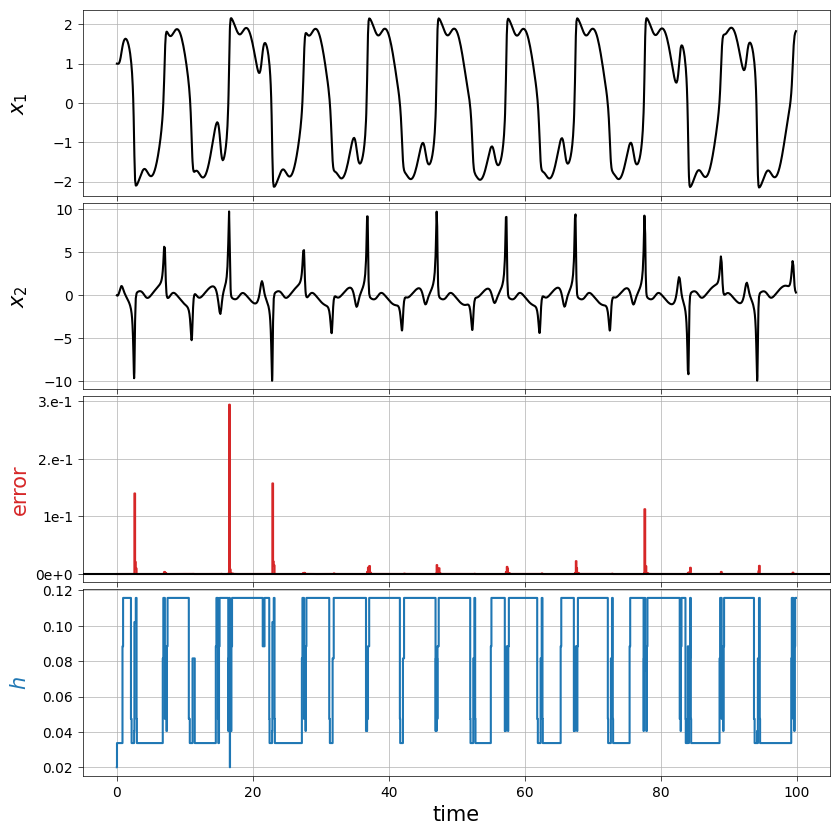

In [207]:
from adaptive.comparison_ode import integrate_env

# Integrate the environment from t0 to t1 using the specified predictor and integrator.
reward, num_evals = integrate_env(predictor, integrator, env, t0=t0, t1=t1)

print("reward: {}".format(reward))
print("nfev: {}".format(num_evals))
print("mean error: {}".format(np.mean(env.errors)))
print("min error, max error: {}, {}".format(*np.round((np.min(env.errors), np.max(env.errors)), 5)))
print("min stepsize: {}".format(np.min(env.deltas)))
print("max stepsize: {}".format(np.max(env.deltas)))

# plot the time-stepping
from adaptive.plots import plot_trajectory
fig, ax = plot_trajectory(x0=env.x0,
                          timesteps=env.timesteps,
                          nodes=env.nodes,
                          errors=env.errors,
                          deltas=env.deltas,
                          t_min=t0,
                          t_max=t1,
                          error_tolerance=env.error_tol,
                          figsize=(8, 8),
                          linewidth=1.5,
                          axislabelsize=15,
                          ticklabelsize=10
                         )

Now we compare the performance of our solver (RK5 with step size controlled by the NN) with the popular adaptive Runge Kutta method `RK45` (ode45).

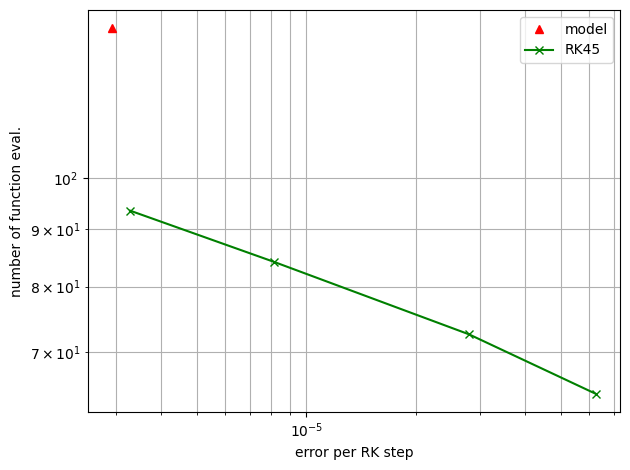

In [205]:
t1 = 100

# evaluate performance of model
reward, num_evals = integrate_env(predictor, integrator, env, t0=t0, t1=t1)
perf_nn = [np.mean(env.errors), num_evals / (t1 - t0)]

# evaluate performance of RK45
from scipy.integrate import solve_ivp  # this function uses RK45 per default

f = VanDerPol()
perf_rk45 = []
tols = [5e-6, 1e-5, 2.5e-5, 5e-5]  # different tolerances for RK45

for tol in tols:
    f.reset()
    sol = solve_ivp(f, (t0, t1), x0, atol=tol, rtol=tol)
    x_predict = sol.y  # array of x (state) values of the RK45 solution
    t_predict = sol.t  # array of t (time) values of the RK45 solution
    # calculate step-wise absolute errors
    this_errors = []
    for idx in range(t_predict.shape[0] - 1):
        # true solution is approximated with very accurate solve_ivp (tolerance=1e-8)
        x_true = f.solve(t_predict[idx], x_predict[:, idx], t_predict[idx + 1]) 
        this_errors.append(np.linalg.norm(x_predict[:, idx + 1] - x_true))
    perf_rk45.append([np.mean(this_errors), sol.nfev / (t1 - t0)])
perf_rk45 = np.array(perf_rk45)

# plot results
from matplotlib import pyplot as plt
plt.loglog(perf_nn[0], perf_nn[1], 'r^', label='model')
plt.loglog(perf_rk45[:, 0], perf_rk45[:, 1], 'gx-', label='RK45')
plt.legend()
plt.xlabel('error per RK step')
plt.ylabel('number of function eval.')
plt.grid(which='both')
plt.tight_layout()
plt.show()